In [ ]:
# Enable autoreload - automatically reloads modules when they change
%load_ext autoreload
%autoreload 2 

import numpy as np

import matplotlib.pyplot as plt

from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import recall_score, precision_score, ConfusionMatrixDisplay, PrecisionRecallDisplay, RocCurveDisplay

from astroML.classification import GMMBayes
from astroML.datasets import fetch_rrlyrae_combined
from astroML.utils import split_samples

from scipy.stats import norm


from astropy.io import ascii
from astropy.io import fits
import os.path

from astropy.table import Table, join, MaskedColumn, vstack, Column


import numpy as np
from astropy.table import vstack
import torch

import pandas as pd
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import LabelEncoder, StandardScaler



import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import numpy as np
from torch.distributions.normal import Normal
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
from sklearn.model_selection import ParameterGrid
import math
import copy
import warnings
import pickle

from itertools import cycle



In [101]:
# Import paths from pipeline_config for multi-machine portability
from pipeline_config import config, project_dir_path, temp_files_path, device

# Use pipeline directory for local imports
pipeline_dir_path = temp_files_path.replace('TempFiles/', '')

# Dataset configuration
dataset_name = 'traintest_data5_v2.pkl'

In [124]:
import torch
torch.get_num_threads()


64

In [125]:
print('hi')

hi


In [77]:

##################################################
###### LOAD THE NN MODEL CLASS ##################
#################################################
# Load in yt datasets
import sys
sys.path.append(project_dir_path)

from GaussianNN_wPeriodogram import DualInputNN


# Load Data and Setup Training

In [78]:
#######################################
###### LOAD THE DATA ##################
#######################################

save_path = temp_files_path
file_name = dataset_name

with open(save_path+file_name, 'rb') as f:
    PROCESSED_DATASET = pickle.load(f)

(   X_train, X_test, 
    period_train, period_test, 
    y_train, y_test, 
    feature_cols,
    train_cluster_names, test_cluster_names) = PROCESSED_DATASET


print("X_train: ", np.shape(X_train))
print("X_test: ", np.shape(X_test))
print("period_train: ", np.shape(period_train))
print("period_test: ", np.shape(period_test))
print("y_train: ", np.shape(y_train))
print("y_test: ", np.shape(y_test))
print("feature_cols: ", feature_cols)
print("\n NOTE: Data is RAW (unscaled). Preprocessing will be done per-fold to prevent data leakage.")


########################################################
###### (Optionaly) Visualize the Data ##################
########################################################

import sys
sys.path.append(pipeline_dir_path+'HelperFcns/')


from VisualizeDataset import visualize_feature_distributions, visualize_mass_bin_distribution
from VisualizeDataset import visualize_summary_stats, plot_correlation_matrix

visualize=False
if visualize:
    #visualize_feature_distributions(X_train, feature_cols)
    visualize_mass_bin_distribution(y_train, y_test)
    visualize_summary_stats(X_train, y_train, feature_cols)
    plot_correlation_matrix(X_train, feature_names=feature_cols, figsize=(14, 11), annot=True)
    #plot_correlation_matrix(period_train, feature_names=None, figsize=(14, 11), annot=False)


#####################################################################
###### Import Base Training Functions + Helper Fcns. ################
#####################################################################

# Import training functions from helper file
import sys
sys.path.append(project_dir_path)

from Training_HelperFcns import (
    GaussianNLLLoss_ME, 
    sanitize_batch,
    Run_Single_Batch, 
    Run_Single_Epoch, 
    Train_Model,
    log_model_progress,
    plot_run_log
)


###################################################
###### Import Kfold Training Functions ############
###################################################
# Import K-fold cross-validation functions from shared module
from Kfold_HelperFcns import kfold_cross_validation, verify_kfold_split

# Verify K-fold split (run this to test the split logic)
verify_kfold_split(train_cluster_names, k=5, seed=42)


X_train:  torch.Size([3154, 16])
X_test:  torch.Size([516, 16])
period_train:  torch.Size([3154, 1089])
period_test:  torch.Size([516, 1089])
y_train:  torch.Size([3154, 1])
y_test:  torch.Size([516, 1])
feature_cols:  ['rms', 'std', 'MAD', 'sigmaG', 'von_neumann_ratio', 'J_Stetson', 'max_power', 'freq_at_max_power', 'ratio_of_power_at_high_v_low_freq', 'max_autocorrelation', 'time_of_max_autocorrelation', 'SumLSP_10_7_Day_Power', 'SumLSP_7_4_Day_Power', 'SumLSP_4_1_Day_Power', 'SumLSP_1_p5_Day_Power', 'Entropy']

 NOTE: Data is RAW (unscaled). Preprocessing will be done per-fold to prevent data leakage.
K-FOLD SPLIT VERIFICATION
Total samples: 3154
Total clusters: 272
Number of folds: 5

--- Fold 1 ---
  ✅ PASS: No cluster overlap (train=217, val=55)
  ✅ PASS: All samples accounted for (train=2522, val=632)
  ✅ PASS: All clusters stay together (not split)

--- Fold 2 ---
  ✅ PASS: No cluster overlap (train=217, val=55)
  ✅ PASS: All samples accounted for (train=2522, val=632)
  ✅ PASS

True

# TRAIN MODELS

The way we will select our model hyper parameters is by:

1) Experiment with different model architectures (ie. for a small grid of hyper-params)
    - With or Without Periodogram data
    - CNN vs Linear for Periodogram
    - Coupled vs decoupled age+uncertainty err.
   
2) Run a course grid of Models (for the identified Architecture)
    - Grid Across:
    - LR
    - Batchsize
    - Dropout Prob.
    - Layer Size
    - Num Layers

4) Take our best model and run a test across different dropout rates.
    - For a choses num_epochs, select the dropout rate that yields best statistics.
  
5) Run a refined parameter search and choose the best model given that dropout rate and epoch #

6) Train a model (on the full training set, no k-folds) with the identified best hyper parameters.
    - evaluate model



We do however need to decide on what metrics we are using at each stage.

1) We can probs do this by eye, idk how papers normaly do this.
2) Take epoch of minimum loss, then compare statistics for all models.
    - key metrics are coverage frac, 

In [79]:
X_train.shape[0]

3154

  Run # 0 , Params: {'Layer1_Size': 16, 'Layer2_Size': 8, 'artificial_loss_weight_factor': 1, 'batch_size': 2, 'decoupled': False, 'dropout_prob': 0.2, 'learn_sigma': False, 'lr': 0.001, 'n_epochs': 25, 'n_layers': 2, 'num_kfolds': 5, 'use_cnn': False, 'use_periodogram': True, 'weight_decay': 1e-06}
[11:11:17] Starting 5-fold cross-validation on device: cpu

[11:11:17] FOLD 1/5 STARTING
Validation clusters: 55 clusters
[11:11:17] [EPOCH START] Epoch 0, Total batches: 1261
[11:11:25] [EPOCH START] Epoch 10, Total batches: 1261
[11:11:33] [EPOCH START] Epoch 20, Total batches: 1261

[11:11:37] FOLD 1/5 COMPLETE
   Final batch loss: 6.5922, Train loss: 8.0422, Val loss: 23.7540
   Fold time: 0.3min, Avg fold time: 0.3min
   Total elapsed: 0.3min, Est. remaining: 1.3min


[11:11:37] FOLD 2/5 STARTING
Validation clusters: 55 clusters
[11:11:37] [EPOCH START] Epoch 0, Total batches: 1261
[11:11:45] [EPOCH START] Epoch 10, Total batches: 1261
[11:11:53] [EPOCH START] Epoch 20, Total batches: 

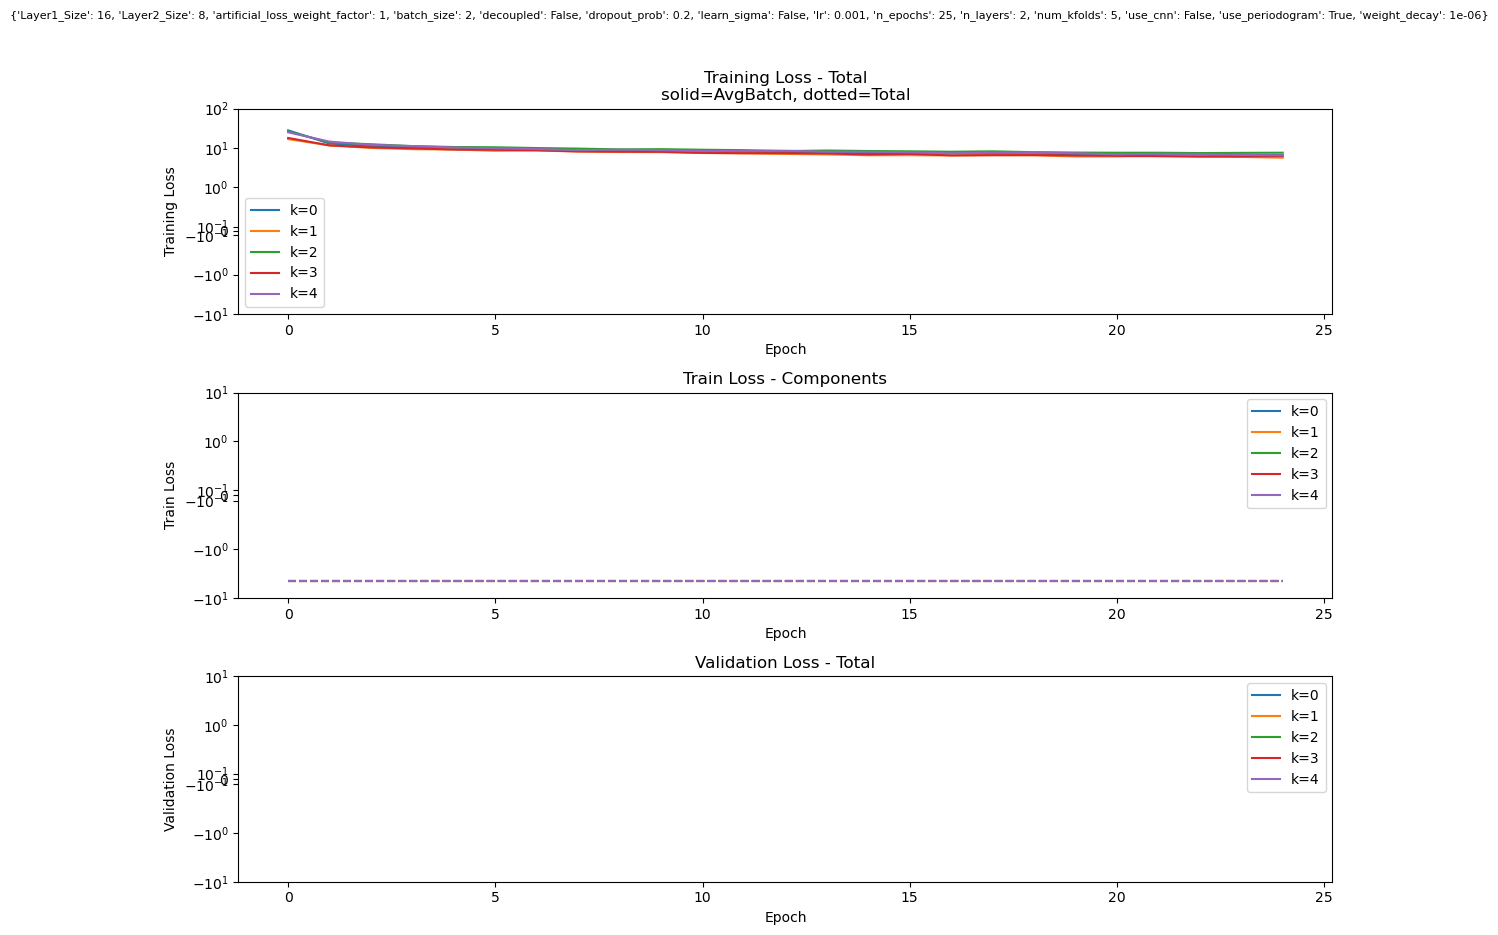

  Run # 1 , Params: {'Layer1_Size': 16, 'Layer2_Size': 8, 'artificial_loss_weight_factor': 1, 'batch_size': 2, 'decoupled': False, 'dropout_prob': 0.2, 'learn_sigma': False, 'lr': 0.004, 'n_epochs': 25, 'n_layers': 2, 'num_kfolds': 5, 'use_cnn': False, 'use_periodogram': True, 'weight_decay': 1e-06}
[11:12:56] Starting 5-fold cross-validation on device: cpu

[11:12:56] FOLD 1/5 STARTING
Validation clusters: 55 clusters
[11:12:56] [EPOCH START] Epoch 0, Total batches: 1261
[11:13:04] [EPOCH START] Epoch 10, Total batches: 1261
[11:13:12] [EPOCH START] Epoch 20, Total batches: 1261

[11:13:16] FOLD 1/5 COMPLETE
   Final batch loss: 7.6573, Train loss: 9.3806, Val loss: 23.7961
   Fold time: 0.3min, Avg fold time: 0.3min
   Total elapsed: 0.3min, Est. remaining: 1.3min


[11:13:16] FOLD 2/5 STARTING
Validation clusters: 55 clusters
[11:13:16] [EPOCH START] Epoch 0, Total batches: 1261
[11:13:24] [EPOCH START] Epoch 10, Total batches: 1261
[11:13:32] [EPOCH START] Epoch 20, Total batches: 

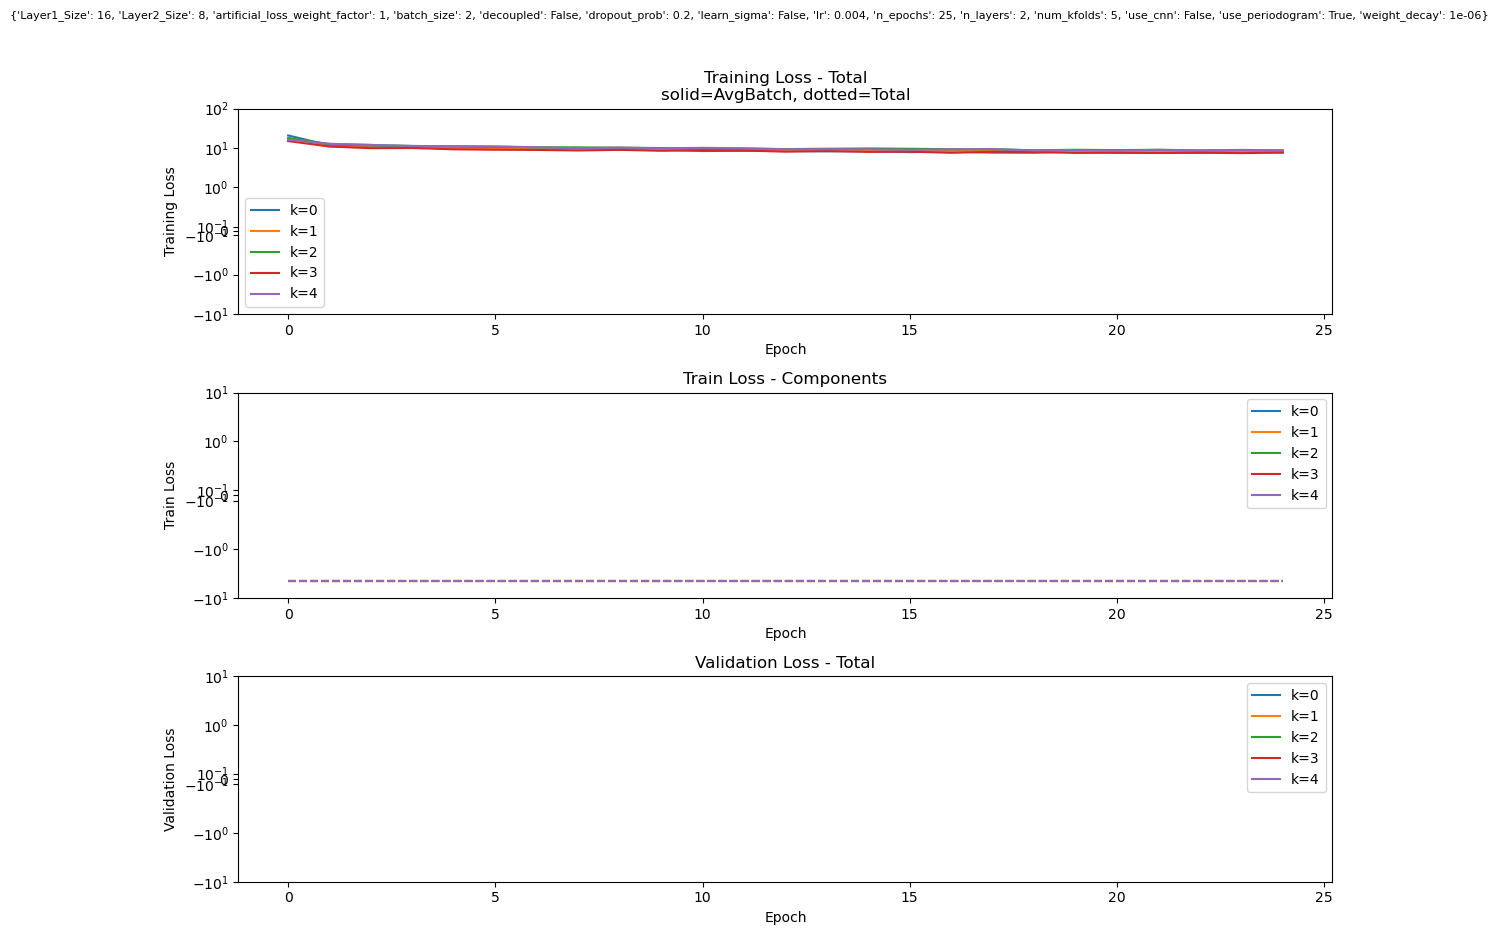

  Run # 2 , Params: {'Layer1_Size': 16, 'Layer2_Size': 8, 'artificial_loss_weight_factor': 1, 'batch_size': 2, 'decoupled': False, 'dropout_prob': 0.2, 'learn_sigma': False, 'lr': 0.016, 'n_epochs': 25, 'n_layers': 2, 'num_kfolds': 5, 'use_cnn': False, 'use_periodogram': True, 'weight_decay': 1e-06}
[11:14:36] Starting 5-fold cross-validation on device: cpu

[11:14:36] FOLD 1/5 STARTING
Validation clusters: 55 clusters
[11:14:36] [EPOCH START] Epoch 0, Total batches: 1261
[11:14:44] [EPOCH START] Epoch 10, Total batches: 1261
[11:14:52] [EPOCH START] Epoch 20, Total batches: 1261

[11:14:56] FOLD 1/5 COMPLETE
   Final batch loss: 13.6458, Train loss: 20.8437, Val loss: 23.3388
   Fold time: 0.3min, Avg fold time: 0.3min
   Total elapsed: 0.3min, Est. remaining: 1.3min


[11:14:56] FOLD 2/5 STARTING
Validation clusters: 55 clusters
[11:14:56] [EPOCH START] Epoch 0, Total batches: 1261
[11:15:04] [EPOCH START] Epoch 10, Total batches: 1261
[11:15:12] [EPOCH START] Epoch 20, Total batches

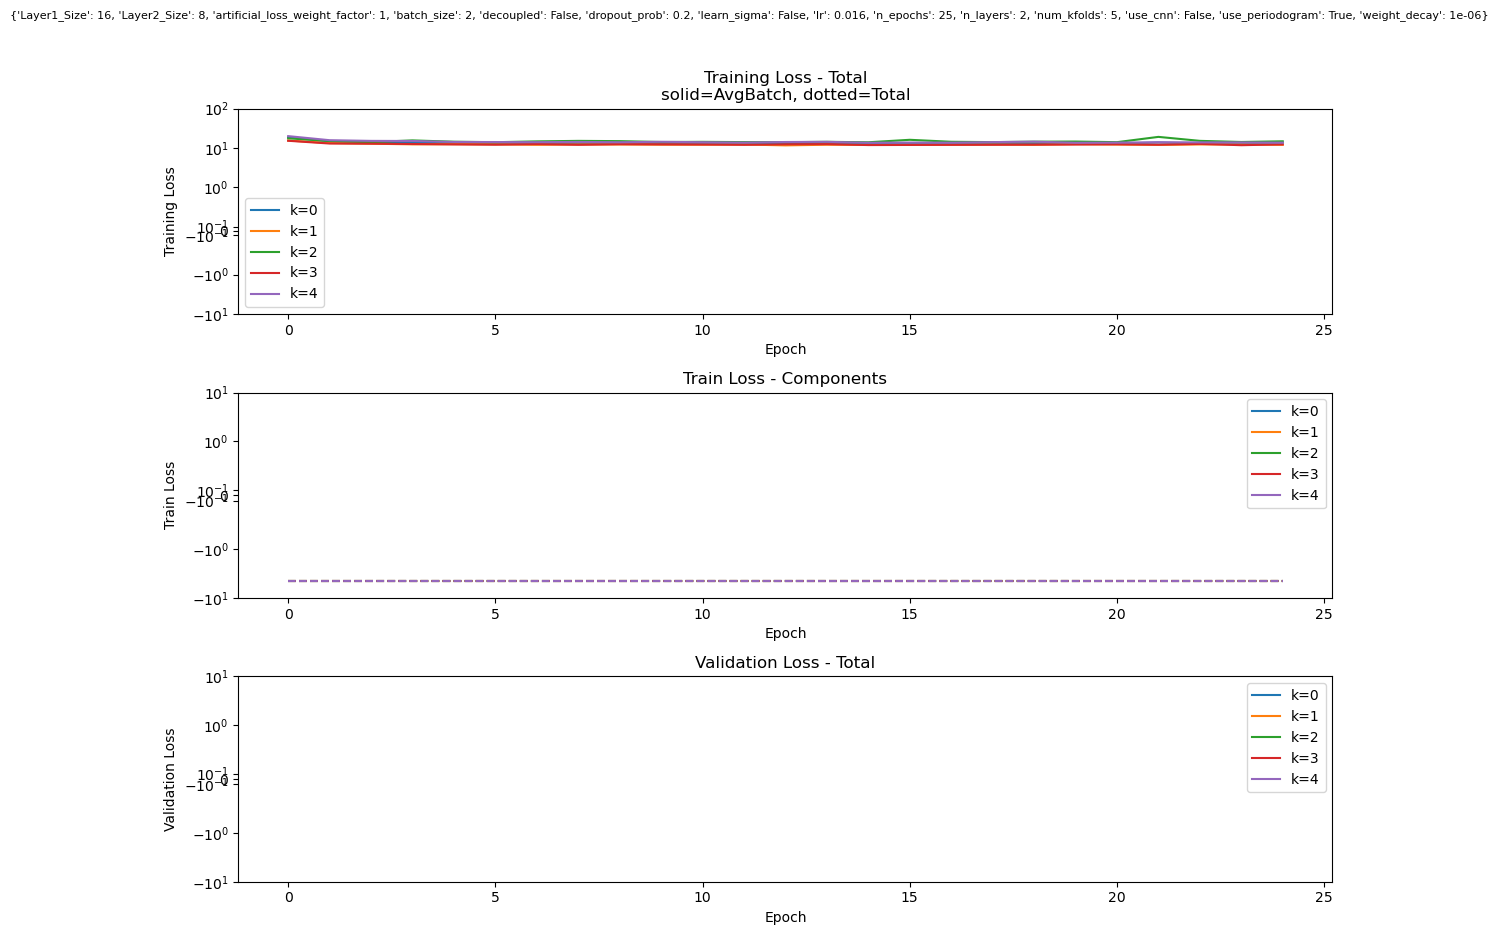

  Run # 3 , Params: {'Layer1_Size': 16, 'Layer2_Size': 8, 'artificial_loss_weight_factor': 1, 'batch_size': 2, 'decoupled': False, 'dropout_prob': 0.2, 'learn_sigma': False, 'lr': 0.064, 'n_epochs': 25, 'n_layers': 2, 'num_kfolds': 5, 'use_cnn': False, 'use_periodogram': True, 'weight_decay': 1e-06}
[11:16:16] Starting 5-fold cross-validation on device: cpu

[11:16:16] FOLD 1/5 STARTING
Validation clusters: 55 clusters
[11:16:16] [EPOCH START] Epoch 0, Total batches: 1261
[11:16:24] [EPOCH START] Epoch 10, Total batches: 1261
[11:16:32] [EPOCH START] Epoch 20, Total batches: 1261

[11:16:36] FOLD 1/5 COMPLETE
   Final batch loss: 16.2446, Train loss: 33.2506, Val loss: 29.2953
   Fold time: 0.3min, Avg fold time: 0.3min
   Total elapsed: 0.3min, Est. remaining: 1.3min


[11:16:36] FOLD 2/5 STARTING
Validation clusters: 55 clusters
[11:16:36] [EPOCH START] Epoch 0, Total batches: 1261
[11:16:44] [EPOCH START] Epoch 10, Total batches: 1261
[11:16:52] [EPOCH START] Epoch 20, Total batches

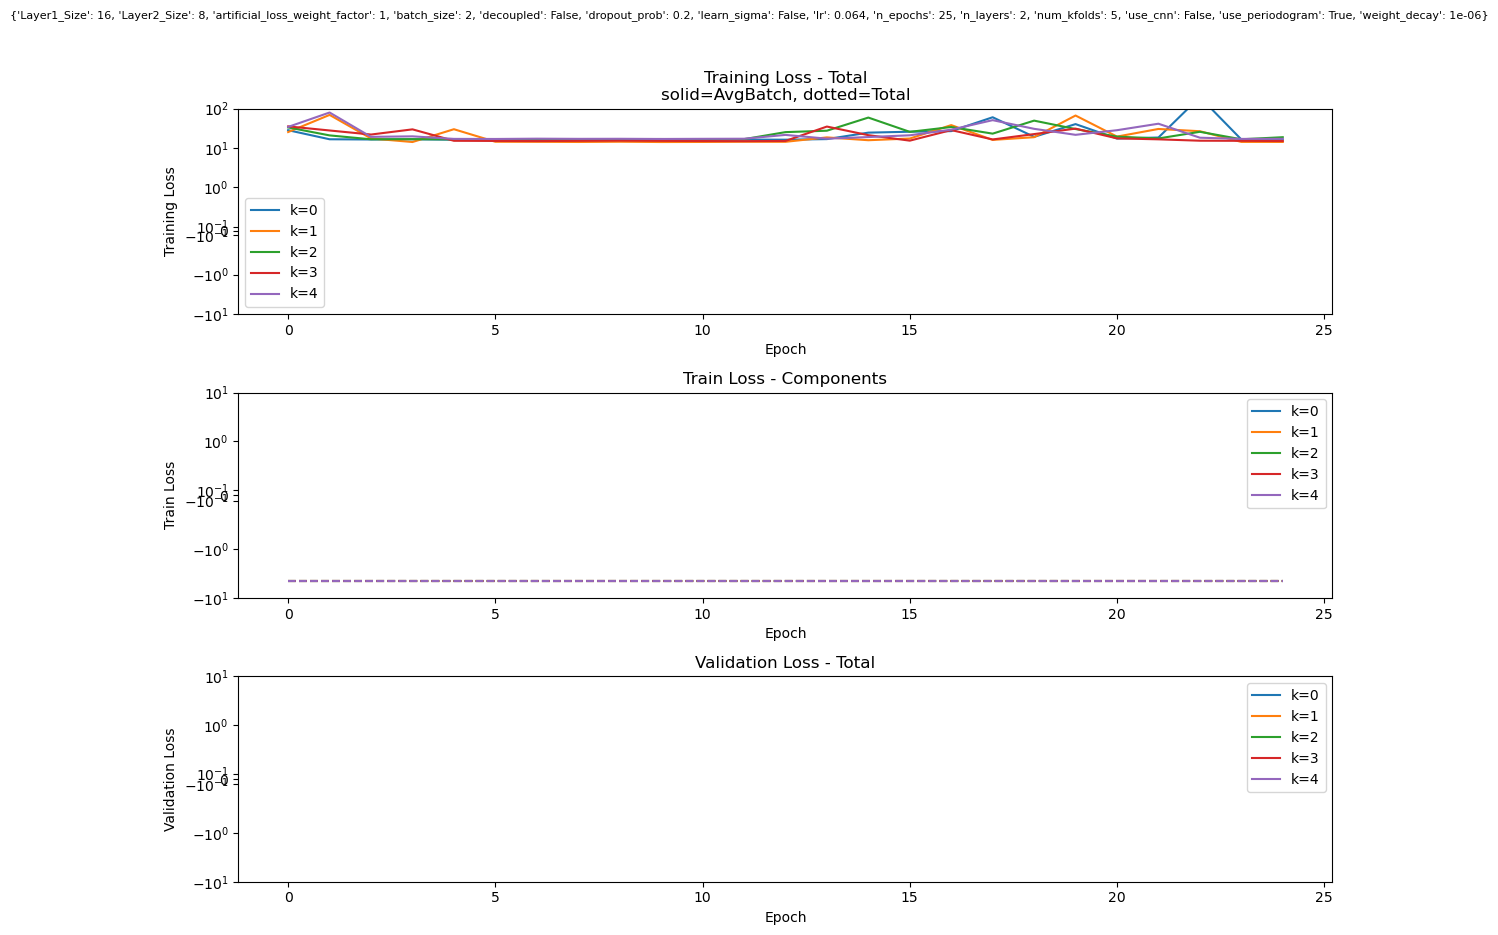

  Run # 4 , Params: {'Layer1_Size': 16, 'Layer2_Size': 8, 'artificial_loss_weight_factor': 1, 'batch_size': 2, 'decoupled': False, 'dropout_prob': 0.2, 'learn_sigma': False, 'lr': 0.128, 'n_epochs': 25, 'n_layers': 2, 'num_kfolds': 5, 'use_cnn': False, 'use_periodogram': True, 'weight_decay': 1e-06}
[11:17:56] Starting 5-fold cross-validation on device: cpu

[11:17:56] FOLD 1/5 STARTING
Validation clusters: 55 clusters
[11:17:56] [EPOCH START] Epoch 0, Total batches: 1261
[11:18:03] [EPOCH START] Epoch 10, Total batches: 1261
[11:18:11] [EPOCH START] Epoch 20, Total batches: 1261

[11:18:15] FOLD 1/5 COMPLETE
   Final batch loss: 18.5403, Train loss: 32.1539, Val loss: 27.8212
   Fold time: 0.3min, Avg fold time: 0.3min
   Total elapsed: 0.3min, Est. remaining: 1.3min


[11:18:15] FOLD 2/5 STARTING
Validation clusters: 55 clusters
[11:18:15] [EPOCH START] Epoch 0, Total batches: 1261
[11:18:23] [EPOCH START] Epoch 10, Total batches: 1261
[11:18:31] [EPOCH START] Epoch 20, Total batches

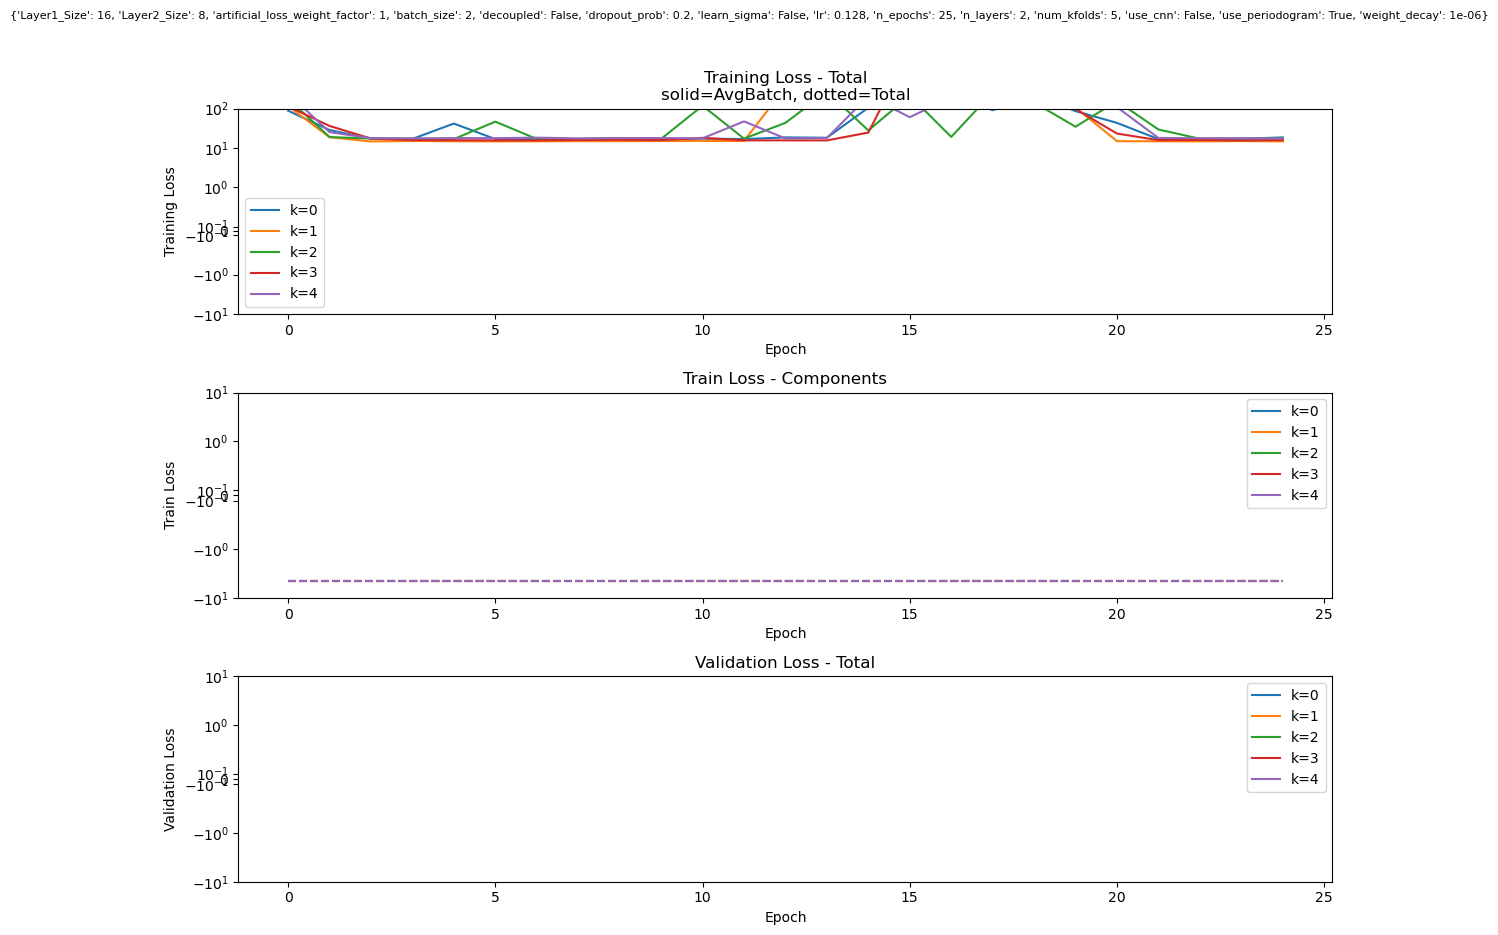

  Run # 5 , Params: {'Layer1_Size': 16, 'Layer2_Size': 8, 'artificial_loss_weight_factor': 1, 'batch_size': 8, 'decoupled': False, 'dropout_prob': 0.2, 'learn_sigma': False, 'lr': 0.001, 'n_epochs': 25, 'n_layers': 2, 'num_kfolds': 5, 'use_cnn': False, 'use_periodogram': True, 'weight_decay': 1e-06}
[11:19:35] Starting 5-fold cross-validation on device: cpu

[11:19:35] FOLD 1/5 STARTING
Validation clusters: 55 clusters
[11:19:35] [EPOCH START] Epoch 0, Total batches: 316
[11:19:38] [EPOCH START] Epoch 10, Total batches: 316
[11:19:41] [EPOCH START] Epoch 20, Total batches: 316

[11:19:42] FOLD 1/5 COMPLETE
   Final batch loss: 6.4789, Train loss: 8.7265, Val loss: 24.6376
   Fold time: 0.1min, Avg fold time: 0.1min
   Total elapsed: 0.1min, Est. remaining: 0.5min


[11:19:42] FOLD 2/5 STARTING
Validation clusters: 55 clusters
[11:19:42] [EPOCH START] Epoch 0, Total batches: 316
[11:19:45] [EPOCH START] Epoch 10, Total batches: 316
[11:19:48] [EPOCH START] Epoch 20, Total batches: 316



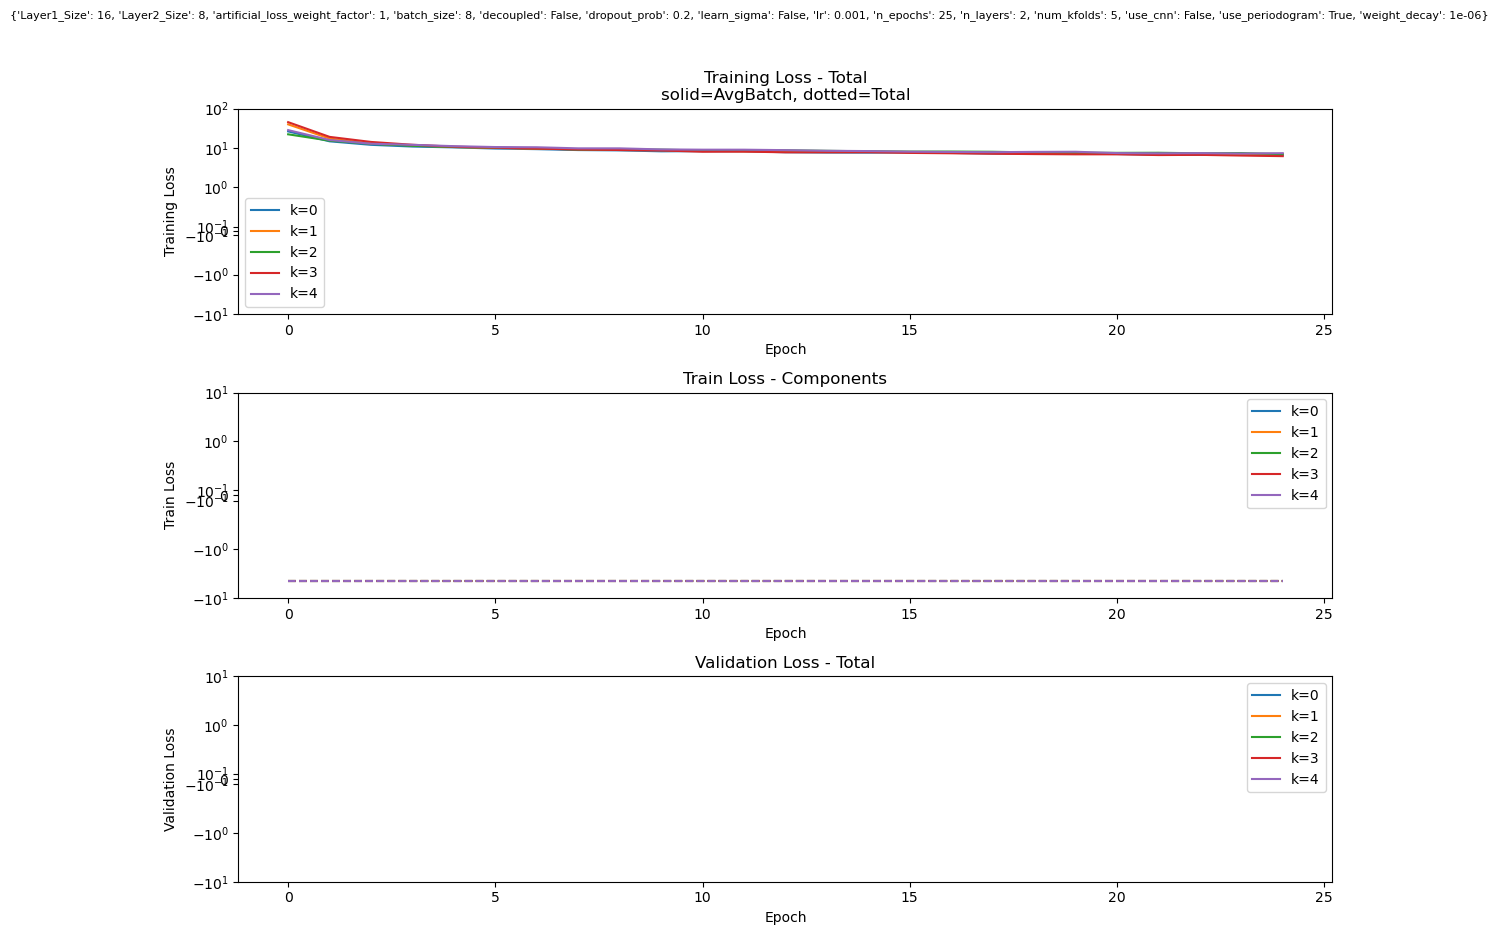

  Run # 6 , Params: {'Layer1_Size': 16, 'Layer2_Size': 8, 'artificial_loss_weight_factor': 1, 'batch_size': 8, 'decoupled': False, 'dropout_prob': 0.2, 'learn_sigma': False, 'lr': 0.004, 'n_epochs': 25, 'n_layers': 2, 'num_kfolds': 5, 'use_cnn': False, 'use_periodogram': True, 'weight_decay': 1e-06}
[11:20:12] Starting 5-fold cross-validation on device: cpu

[11:20:12] FOLD 1/5 STARTING
Validation clusters: 55 clusters
[11:20:12] [EPOCH START] Epoch 0, Total batches: 316
[11:20:15] [EPOCH START] Epoch 10, Total batches: 316
[11:20:18] [EPOCH START] Epoch 20, Total batches: 316

[11:20:19] FOLD 1/5 COMPLETE
   Final batch loss: 6.4595, Train loss: 8.2713, Val loss: 37.5002
   Fold time: 0.1min, Avg fold time: 0.1min
   Total elapsed: 0.1min, Est. remaining: 0.5min


[11:20:19] FOLD 2/5 STARTING
Validation clusters: 55 clusters
[11:20:19] [EPOCH START] Epoch 0, Total batches: 316
[11:20:22] [EPOCH START] Epoch 10, Total batches: 316
[11:20:25] [EPOCH START] Epoch 20, Total batches: 316



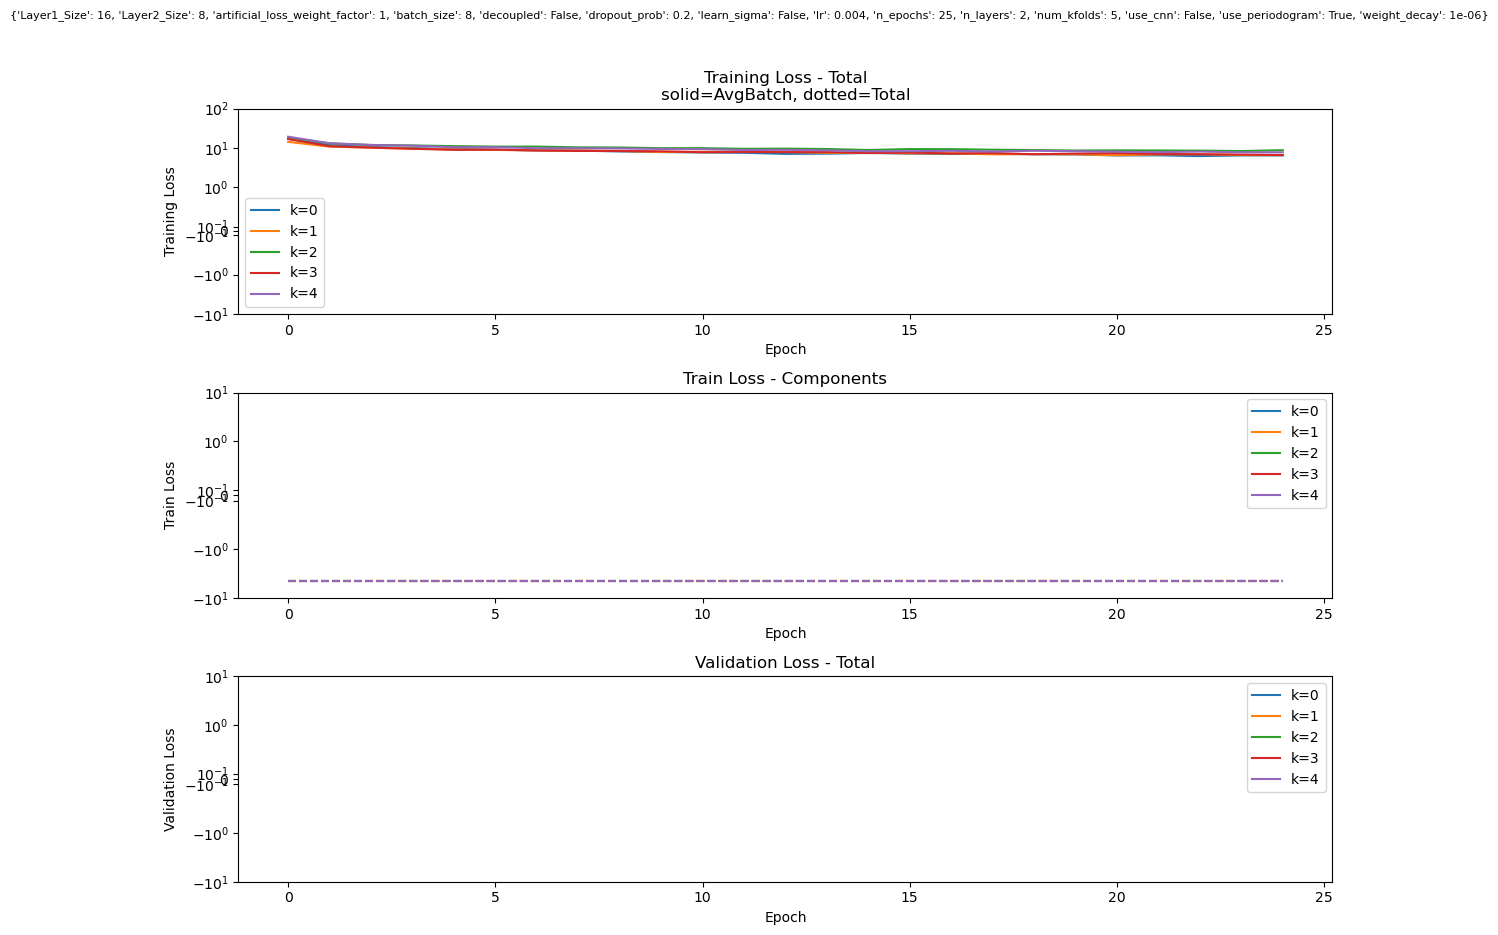

  Run # 7 , Params: {'Layer1_Size': 16, 'Layer2_Size': 8, 'artificial_loss_weight_factor': 1, 'batch_size': 8, 'decoupled': False, 'dropout_prob': 0.2, 'learn_sigma': False, 'lr': 0.016, 'n_epochs': 25, 'n_layers': 2, 'num_kfolds': 5, 'use_cnn': False, 'use_periodogram': True, 'weight_decay': 1e-06}
[11:20:49] Starting 5-fold cross-validation on device: cpu

[11:20:49] FOLD 1/5 STARTING
Validation clusters: 55 clusters
[11:20:49] [EPOCH START] Epoch 0, Total batches: 316
[11:20:52] [EPOCH START] Epoch 10, Total batches: 316
[11:20:55] [EPOCH START] Epoch 20, Total batches: 316

[11:20:56] FOLD 1/5 COMPLETE
   Final batch loss: 10.0852, Train loss: 14.7864, Val loss: 24.2927
   Fold time: 0.1min, Avg fold time: 0.1min
   Total elapsed: 0.1min, Est. remaining: 0.5min


[11:20:56] FOLD 2/5 STARTING
Validation clusters: 55 clusters
[11:20:56] [EPOCH START] Epoch 0, Total batches: 316
[11:20:59] [EPOCH START] Epoch 10, Total batches: 316
[11:21:02] [EPOCH START] Epoch 20, Total batches: 316

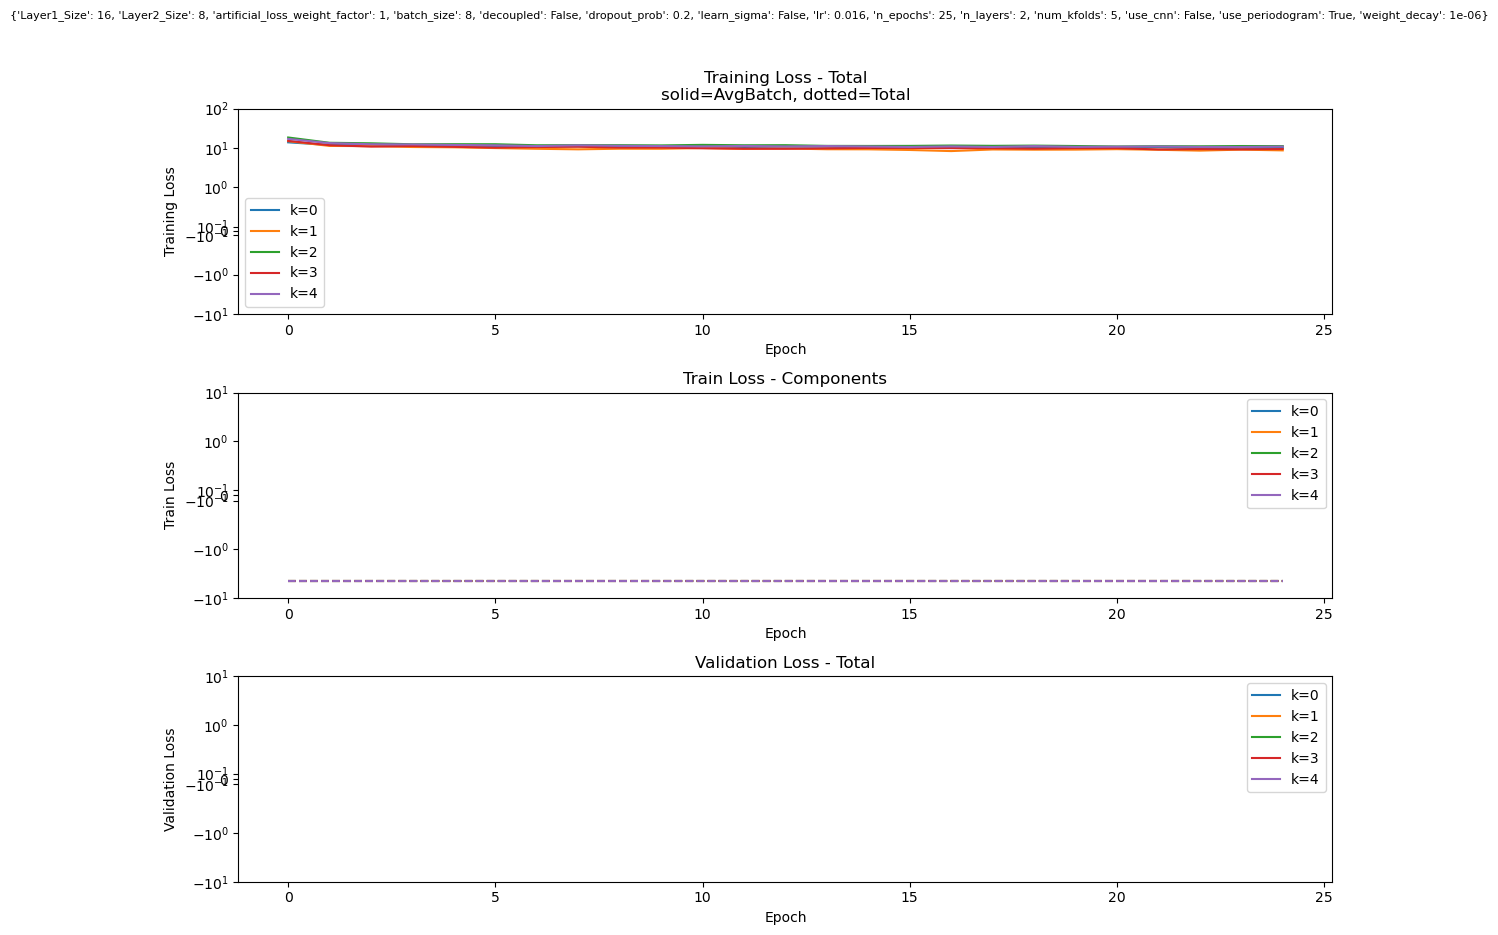

  Run # 8 , Params: {'Layer1_Size': 16, 'Layer2_Size': 8, 'artificial_loss_weight_factor': 1, 'batch_size': 8, 'decoupled': False, 'dropout_prob': 0.2, 'learn_sigma': False, 'lr': 0.064, 'n_epochs': 25, 'n_layers': 2, 'num_kfolds': 5, 'use_cnn': False, 'use_periodogram': True, 'weight_decay': 1e-06}
[11:21:26] Starting 5-fold cross-validation on device: cpu

[11:21:26] FOLD 1/5 STARTING
Validation clusters: 55 clusters
[11:21:26] [EPOCH START] Epoch 0, Total batches: 316
[11:21:29] [EPOCH START] Epoch 10, Total batches: 316
[11:21:31] [EPOCH START] Epoch 20, Total batches: 316

[11:21:33] FOLD 1/5 COMPLETE
   Final batch loss: 18.9274, Train loss: 32.6109, Val loss: 28.2638
   Fold time: 0.1min, Avg fold time: 0.1min
   Total elapsed: 0.1min, Est. remaining: 0.5min


[11:21:33] FOLD 2/5 STARTING
Validation clusters: 55 clusters
[11:21:33] [EPOCH START] Epoch 0, Total batches: 316
[11:21:36] [EPOCH START] Epoch 10, Total batches: 316
[11:21:39] [EPOCH START] Epoch 20, Total batches: 316

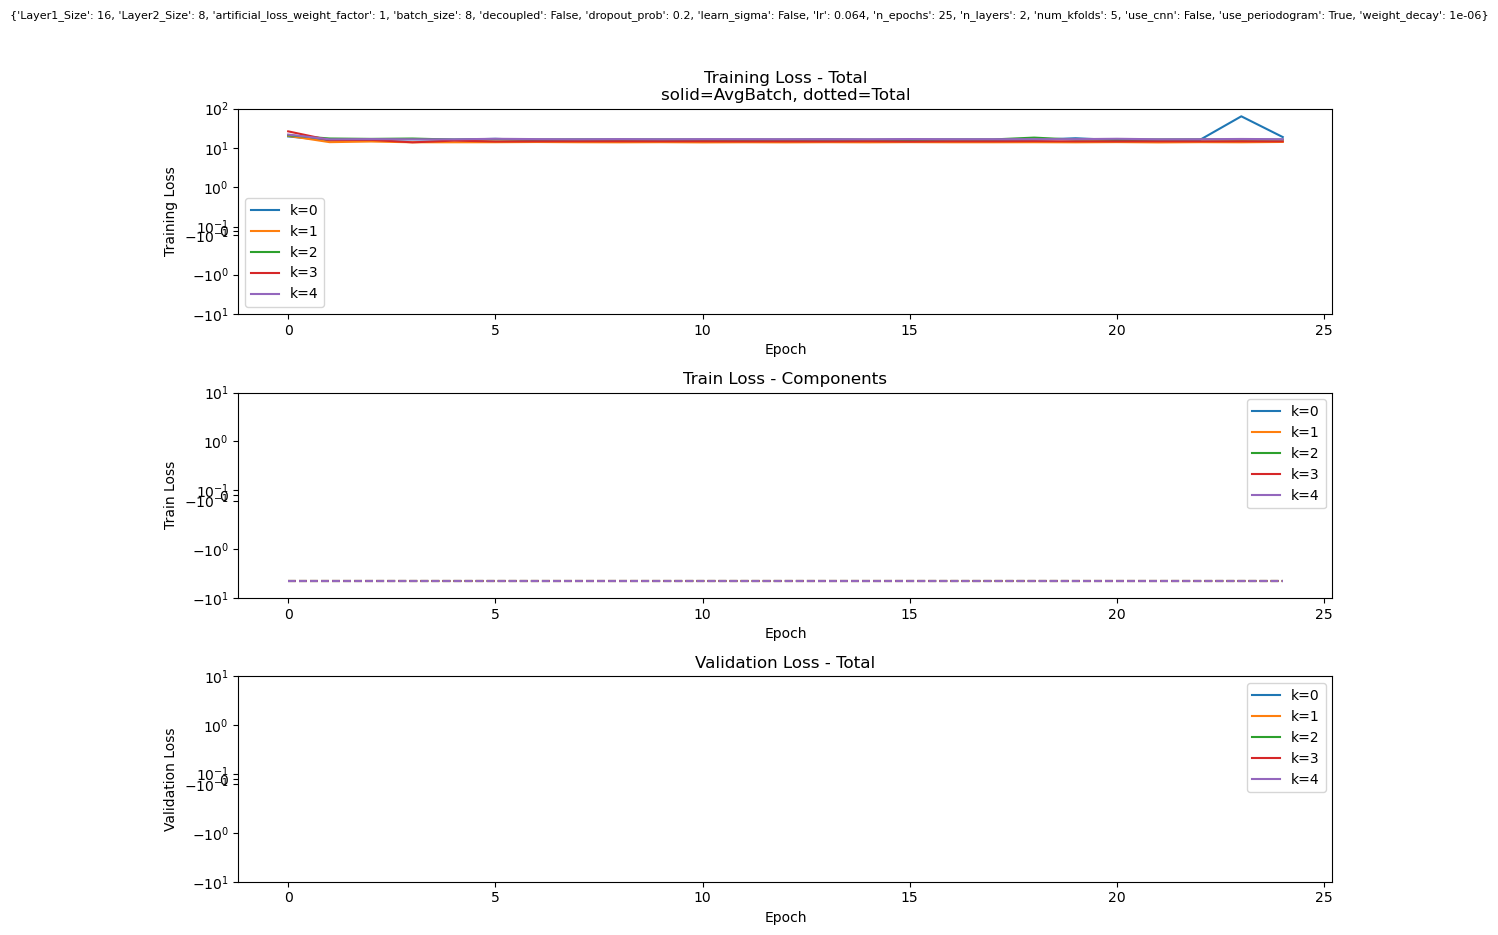

  Run # 9 , Params: {'Layer1_Size': 16, 'Layer2_Size': 8, 'artificial_loss_weight_factor': 1, 'batch_size': 8, 'decoupled': False, 'dropout_prob': 0.2, 'learn_sigma': False, 'lr': 0.128, 'n_epochs': 25, 'n_layers': 2, 'num_kfolds': 5, 'use_cnn': False, 'use_periodogram': True, 'weight_decay': 1e-06}
[11:22:03] Starting 5-fold cross-validation on device: cpu

[11:22:03] FOLD 1/5 STARTING
Validation clusters: 55 clusters
[11:22:03] [EPOCH START] Epoch 0, Total batches: 316
[11:22:05] [EPOCH START] Epoch 10, Total batches: 316
[11:22:08] [EPOCH START] Epoch 20, Total batches: 316

[11:22:10] FOLD 1/5 COMPLETE
   Final batch loss: 16.1511, Train loss: 29.8543, Val loss: 25.7928
   Fold time: 0.1min, Avg fold time: 0.1min
   Total elapsed: 0.1min, Est. remaining: 0.5min


[11:22:10] FOLD 2/5 STARTING
Validation clusters: 55 clusters
[11:22:10] [EPOCH START] Epoch 0, Total batches: 316
[11:22:13] [EPOCH START] Epoch 10, Total batches: 316
[11:22:16] [EPOCH START] Epoch 20, Total batches: 316

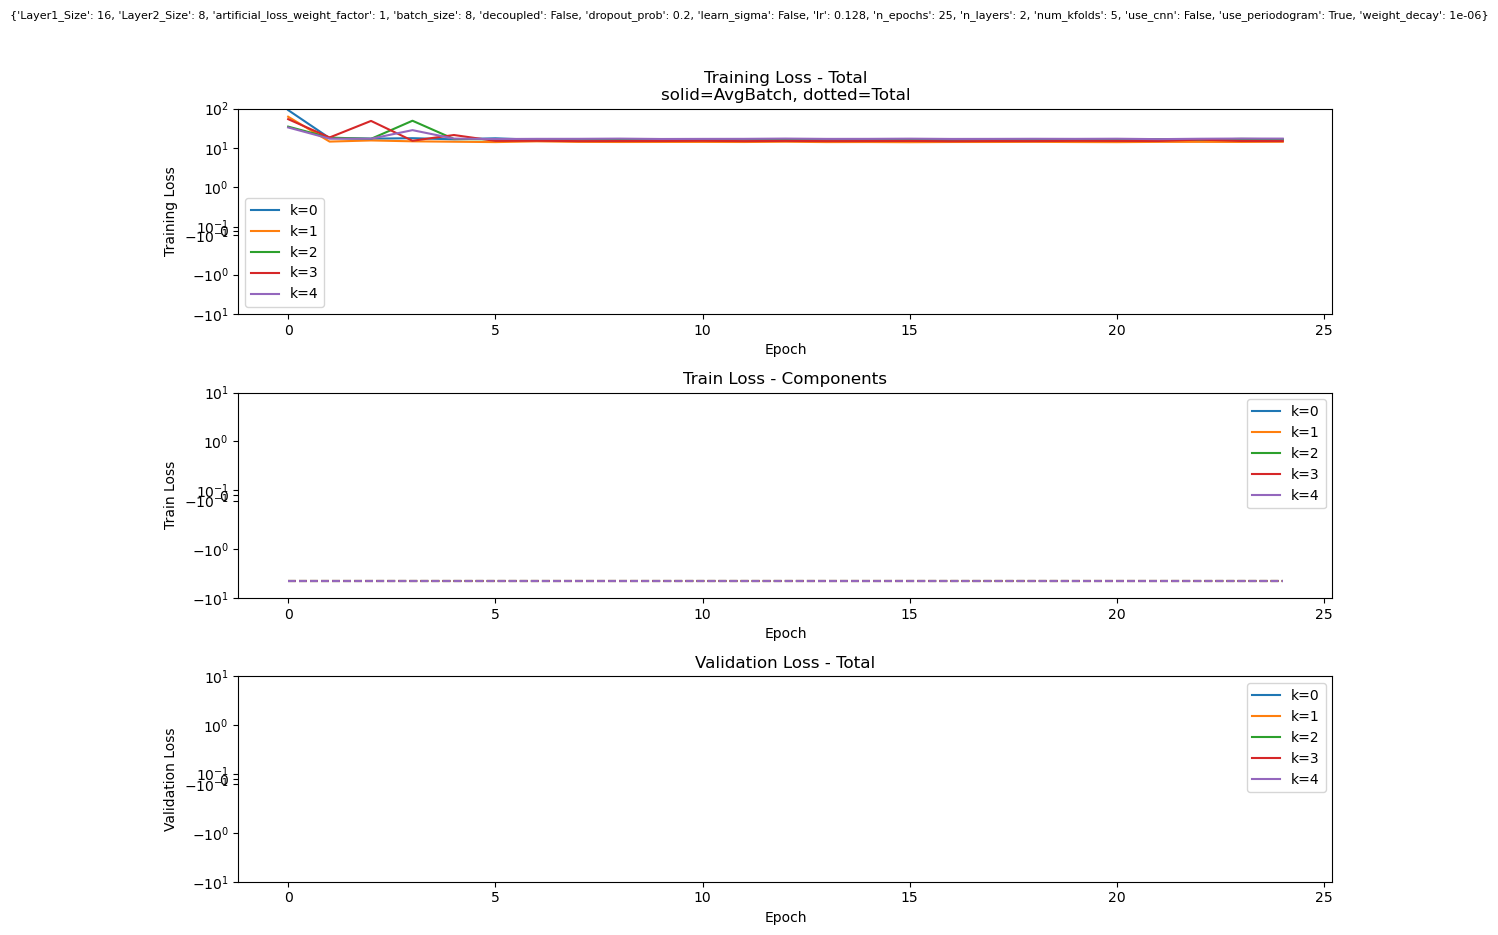

  Run # 10 , Params: {'Layer1_Size': 16, 'Layer2_Size': 8, 'artificial_loss_weight_factor': 1, 'batch_size': 64, 'decoupled': False, 'dropout_prob': 0.2, 'learn_sigma': False, 'lr': 0.001, 'n_epochs': 25, 'n_layers': 2, 'num_kfolds': 5, 'use_cnn': False, 'use_periodogram': True, 'weight_decay': 1e-06}
[11:22:39] Starting 5-fold cross-validation on device: cpu

[11:22:39] FOLD 1/5 STARTING
Validation clusters: 55 clusters
[11:22:39] [EPOCH START] Epoch 0, Total batches: 40
[11:22:41] [EPOCH START] Epoch 10, Total batches: 40
[11:22:42] [EPOCH START] Epoch 20, Total batches: 40

[11:22:43] FOLD 1/5 COMPLETE
   Final batch loss: 8.9018, Train loss: 13.4109, Val loss: 24.6070
   Fold time: 0.1min, Avg fold time: 0.1min
   Total elapsed: 0.1min, Est. remaining: 0.2min


[11:22:43] FOLD 2/5 STARTING
Validation clusters: 55 clusters
[11:22:43] [EPOCH START] Epoch 0, Total batches: 40
[11:22:44] [EPOCH START] Epoch 10, Total batches: 40
[11:22:46] [EPOCH START] Epoch 20, Total batches: 40

[11

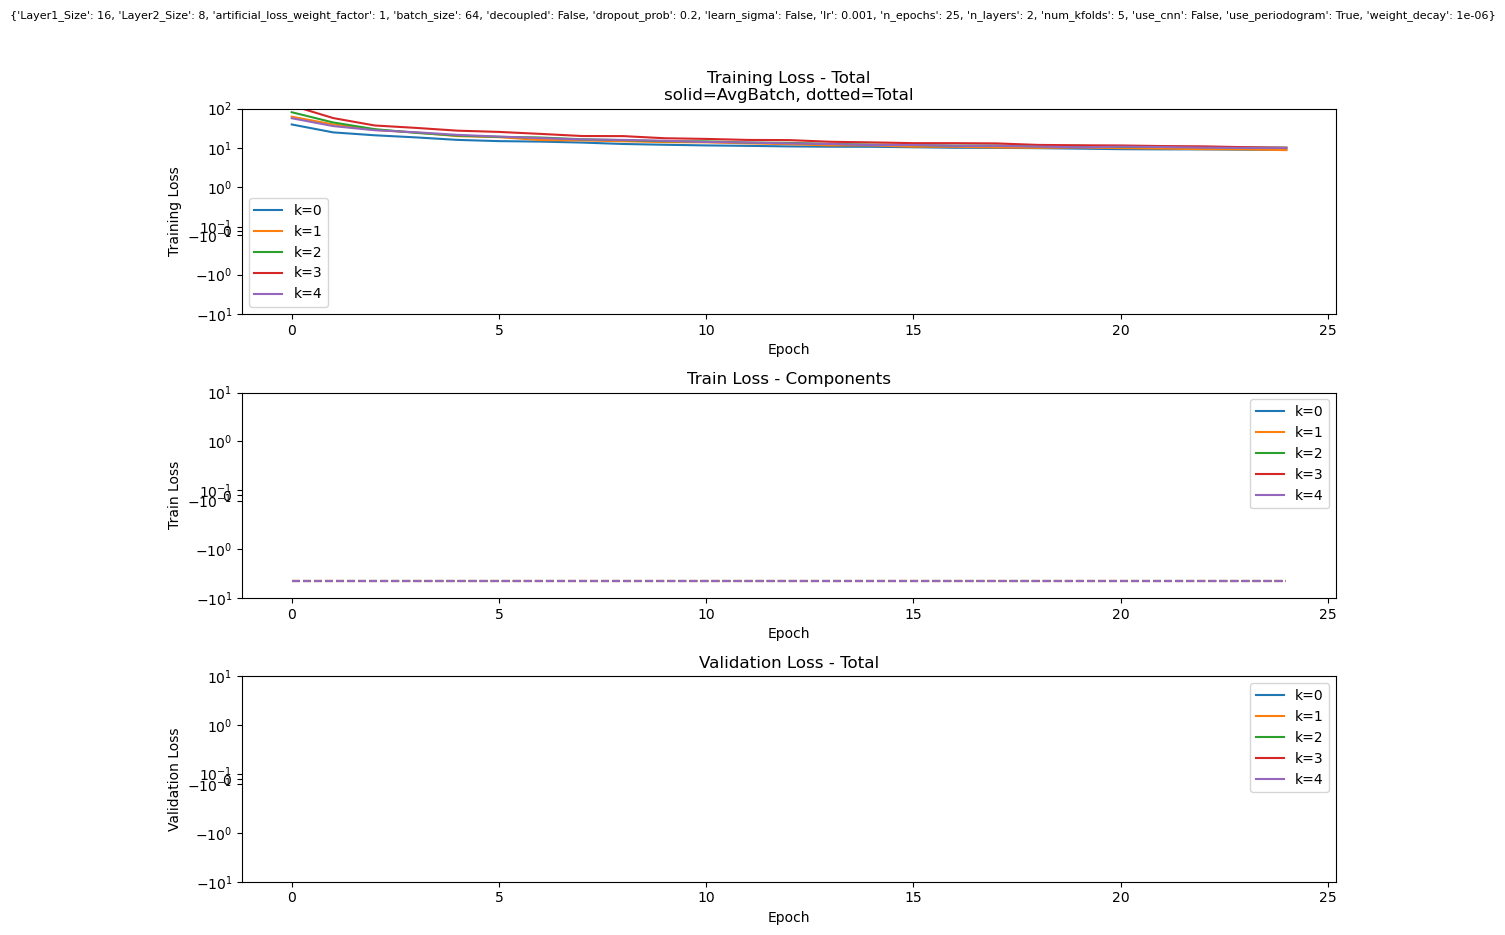

  Run # 11 , Params: {'Layer1_Size': 16, 'Layer2_Size': 8, 'artificial_loss_weight_factor': 1, 'batch_size': 64, 'decoupled': False, 'dropout_prob': 0.2, 'learn_sigma': False, 'lr': 0.004, 'n_epochs': 25, 'n_layers': 2, 'num_kfolds': 5, 'use_cnn': False, 'use_periodogram': True, 'weight_decay': 1e-06}
[11:22:57] Starting 5-fold cross-validation on device: cpu

[11:22:57] FOLD 1/5 STARTING
Validation clusters: 55 clusters
[11:22:57] [EPOCH START] Epoch 0, Total batches: 40
[11:22:58] [EPOCH START] Epoch 10, Total batches: 40
[11:23:00] [EPOCH START] Epoch 20, Total batches: 40

[11:23:01] FOLD 1/5 COMPLETE
   Final batch loss: 6.6502, Train loss: 8.8644, Val loss: 25.4252
   Fold time: 0.1min, Avg fold time: 0.1min
   Total elapsed: 0.1min, Est. remaining: 0.2min


[11:23:01] FOLD 2/5 STARTING
Validation clusters: 55 clusters
[11:23:01] [EPOCH START] Epoch 0, Total batches: 40
[11:23:02] [EPOCH START] Epoch 10, Total batches: 40
[11:23:03] [EPOCH START] Epoch 20, Total batches: 40

[11:

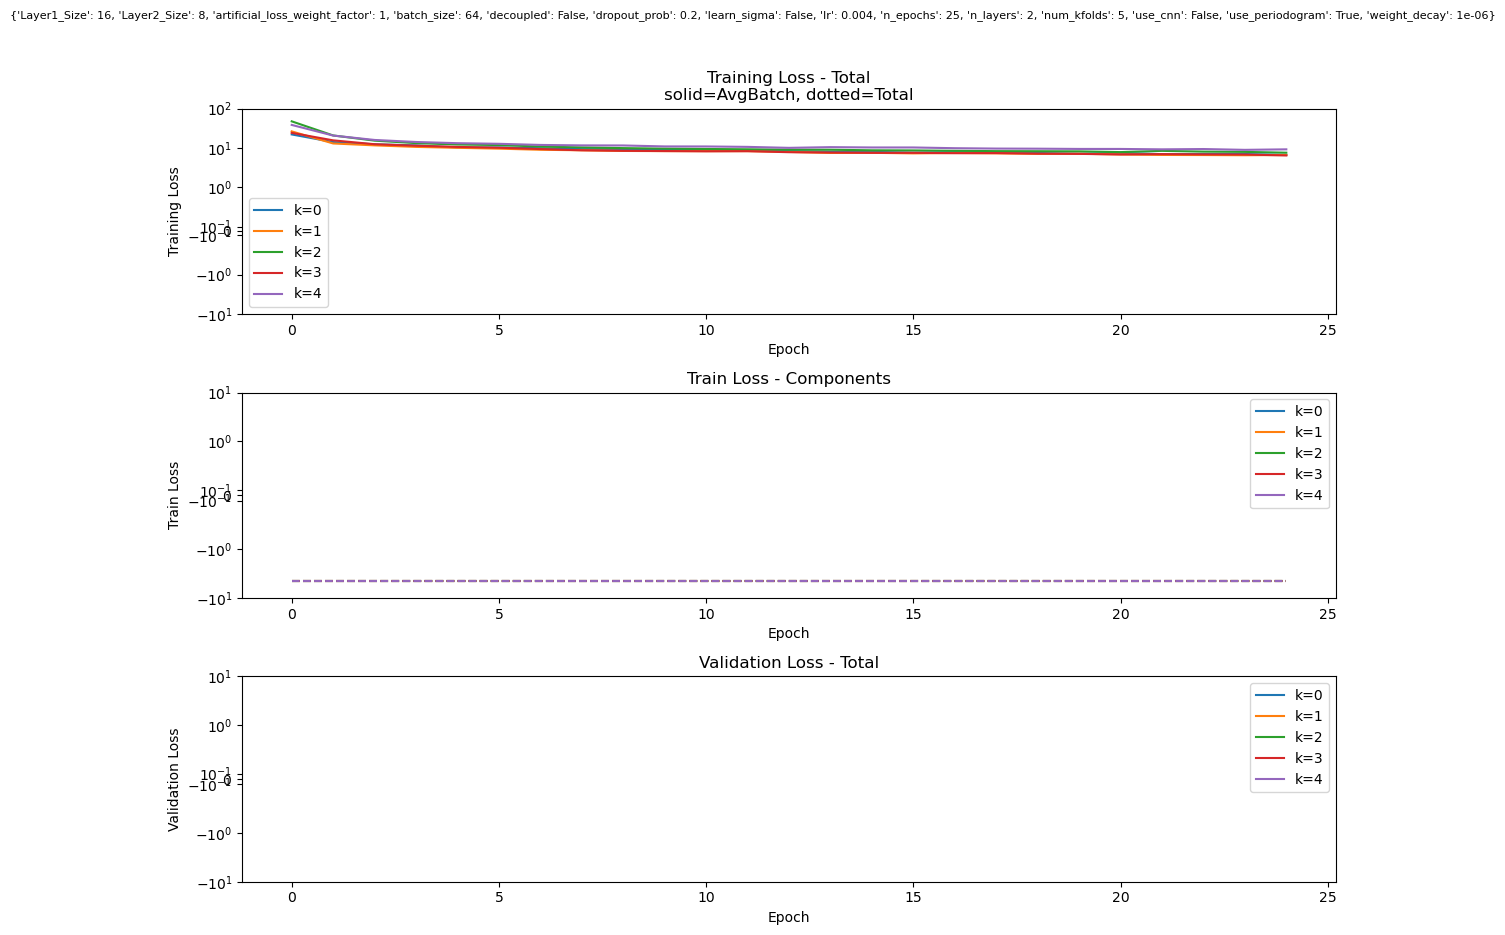

  Run # 12 , Params: {'Layer1_Size': 16, 'Layer2_Size': 8, 'artificial_loss_weight_factor': 1, 'batch_size': 64, 'decoupled': False, 'dropout_prob': 0.2, 'learn_sigma': False, 'lr': 0.016, 'n_epochs': 25, 'n_layers': 2, 'num_kfolds': 5, 'use_cnn': False, 'use_periodogram': True, 'weight_decay': 1e-06}
[11:23:15] Starting 5-fold cross-validation on device: cpu

[11:23:15] FOLD 1/5 STARTING
Validation clusters: 55 clusters
[11:23:15] [EPOCH START] Epoch 0, Total batches: 40
[11:23:16] [EPOCH START] Epoch 10, Total batches: 40
[11:23:18] [EPOCH START] Epoch 20, Total batches: 40

[11:23:19] FOLD 1/5 COMPLETE
   Final batch loss: 7.6938, Train loss: 11.0165, Val loss: 23.0748
   Fold time: 0.1min, Avg fold time: 0.1min
   Total elapsed: 0.1min, Est. remaining: 0.2min


[11:23:19] FOLD 2/5 STARTING
Validation clusters: 55 clusters
[11:23:19] [EPOCH START] Epoch 0, Total batches: 40
[11:23:20] [EPOCH START] Epoch 10, Total batches: 40
[11:23:21] [EPOCH START] Epoch 20, Total batches: 40

[11

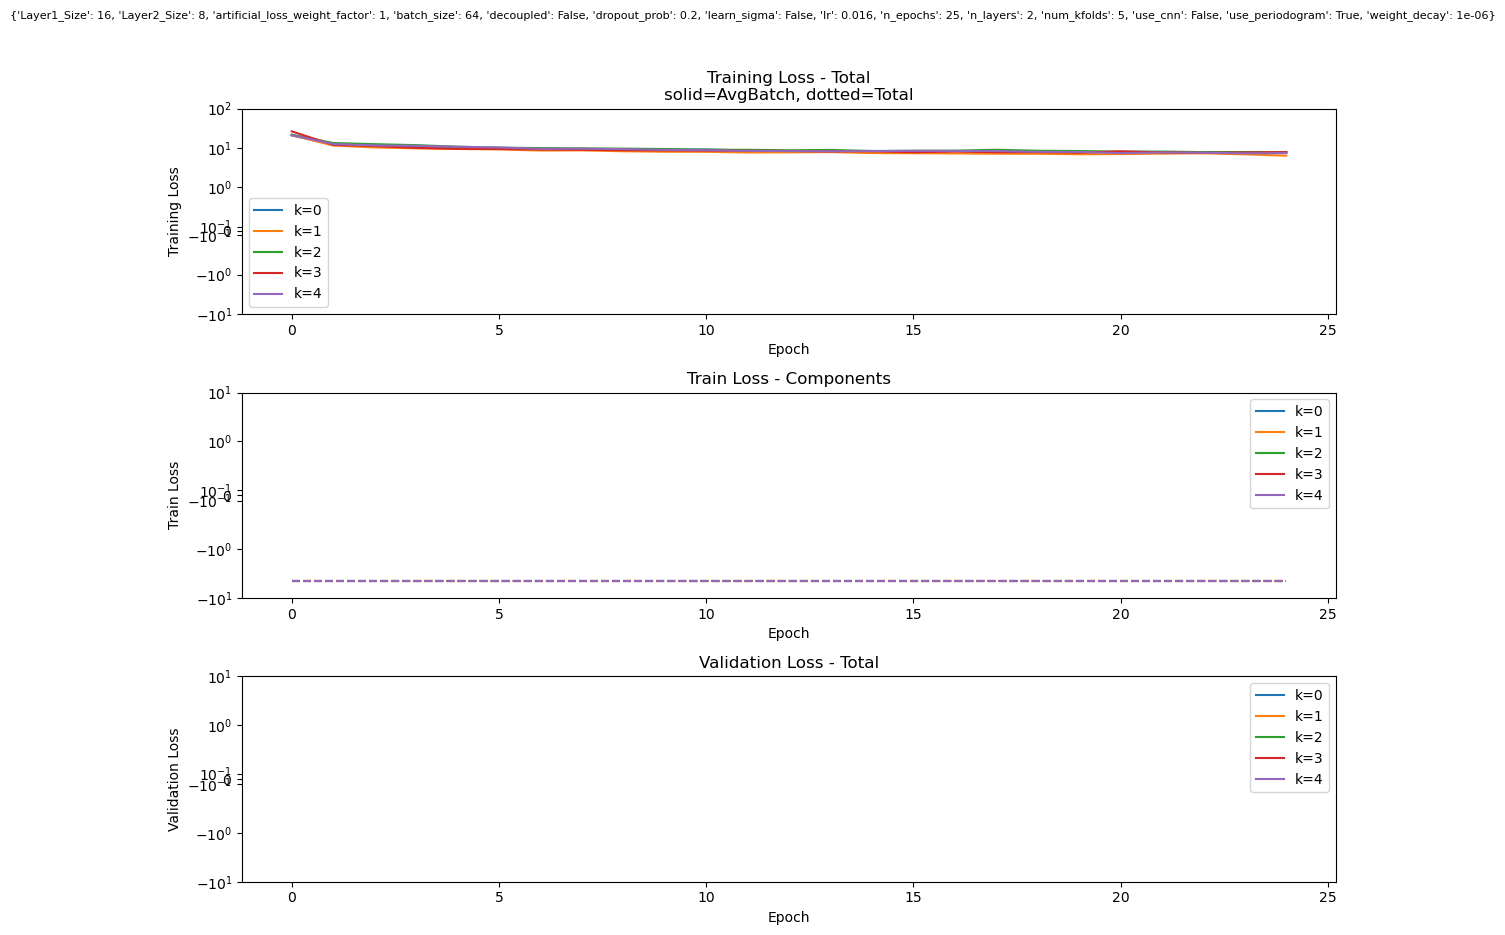

  Run # 13 , Params: {'Layer1_Size': 16, 'Layer2_Size': 8, 'artificial_loss_weight_factor': 1, 'batch_size': 64, 'decoupled': False, 'dropout_prob': 0.2, 'learn_sigma': False, 'lr': 0.064, 'n_epochs': 25, 'n_layers': 2, 'num_kfolds': 5, 'use_cnn': False, 'use_periodogram': True, 'weight_decay': 1e-06}
[11:23:33] Starting 5-fold cross-validation on device: cpu

[11:23:33] FOLD 1/5 STARTING
Validation clusters: 55 clusters
[11:23:33] [EPOCH START] Epoch 0, Total batches: 40
[11:23:34] [EPOCH START] Epoch 10, Total batches: 40
[11:23:36] [EPOCH START] Epoch 20, Total batches: 40

[11:23:36] FOLD 1/5 COMPLETE
   Final batch loss: 10.7948, Train loss: 18.2582, Val loss: 24.4667
   Fold time: 0.1min, Avg fold time: 0.1min
   Total elapsed: 0.1min, Est. remaining: 0.2min


[11:23:36] FOLD 2/5 STARTING
Validation clusters: 55 clusters
[11:23:36] [EPOCH START] Epoch 0, Total batches: 40
[11:23:38] [EPOCH START] Epoch 10, Total batches: 40
[11:23:39] [EPOCH START] Epoch 20, Total batches: 40

[1

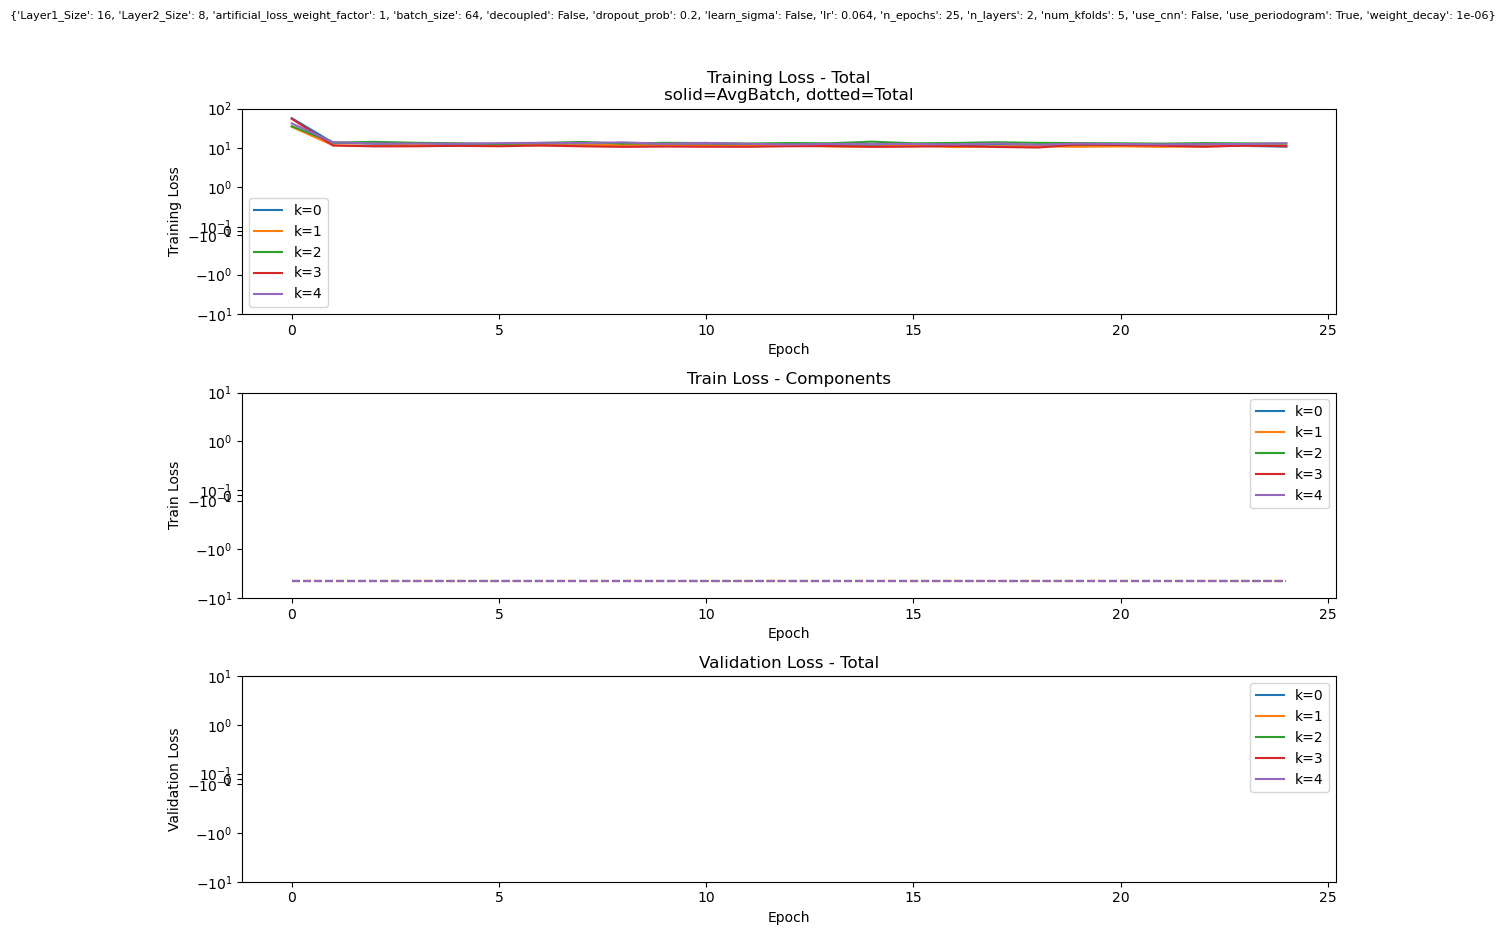

  Run # 14 , Params: {'Layer1_Size': 16, 'Layer2_Size': 8, 'artificial_loss_weight_factor': 1, 'batch_size': 64, 'decoupled': False, 'dropout_prob': 0.2, 'learn_sigma': False, 'lr': 0.128, 'n_epochs': 25, 'n_layers': 2, 'num_kfolds': 5, 'use_cnn': False, 'use_periodogram': True, 'weight_decay': 1e-06}
[11:23:51] Starting 5-fold cross-validation on device: cpu

[11:23:51] FOLD 1/5 STARTING
Validation clusters: 55 clusters
[11:23:51] [EPOCH START] Epoch 0, Total batches: 40
[11:23:52] [EPOCH START] Epoch 10, Total batches: 40
[11:23:53] [EPOCH START] Epoch 20, Total batches: 40

[11:23:54] FOLD 1/5 COMPLETE
   Final batch loss: 13.0204, Train loss: 23.0928, Val loss: 24.1744
   Fold time: 0.1min, Avg fold time: 0.1min
   Total elapsed: 0.1min, Est. remaining: 0.2min


[11:23:54] FOLD 2/5 STARTING
Validation clusters: 55 clusters
[11:23:54] [EPOCH START] Epoch 0, Total batches: 40
[11:23:55] [EPOCH START] Epoch 10, Total batches: 40
[11:23:57] [EPOCH START] Epoch 20, Total batches: 40

[1

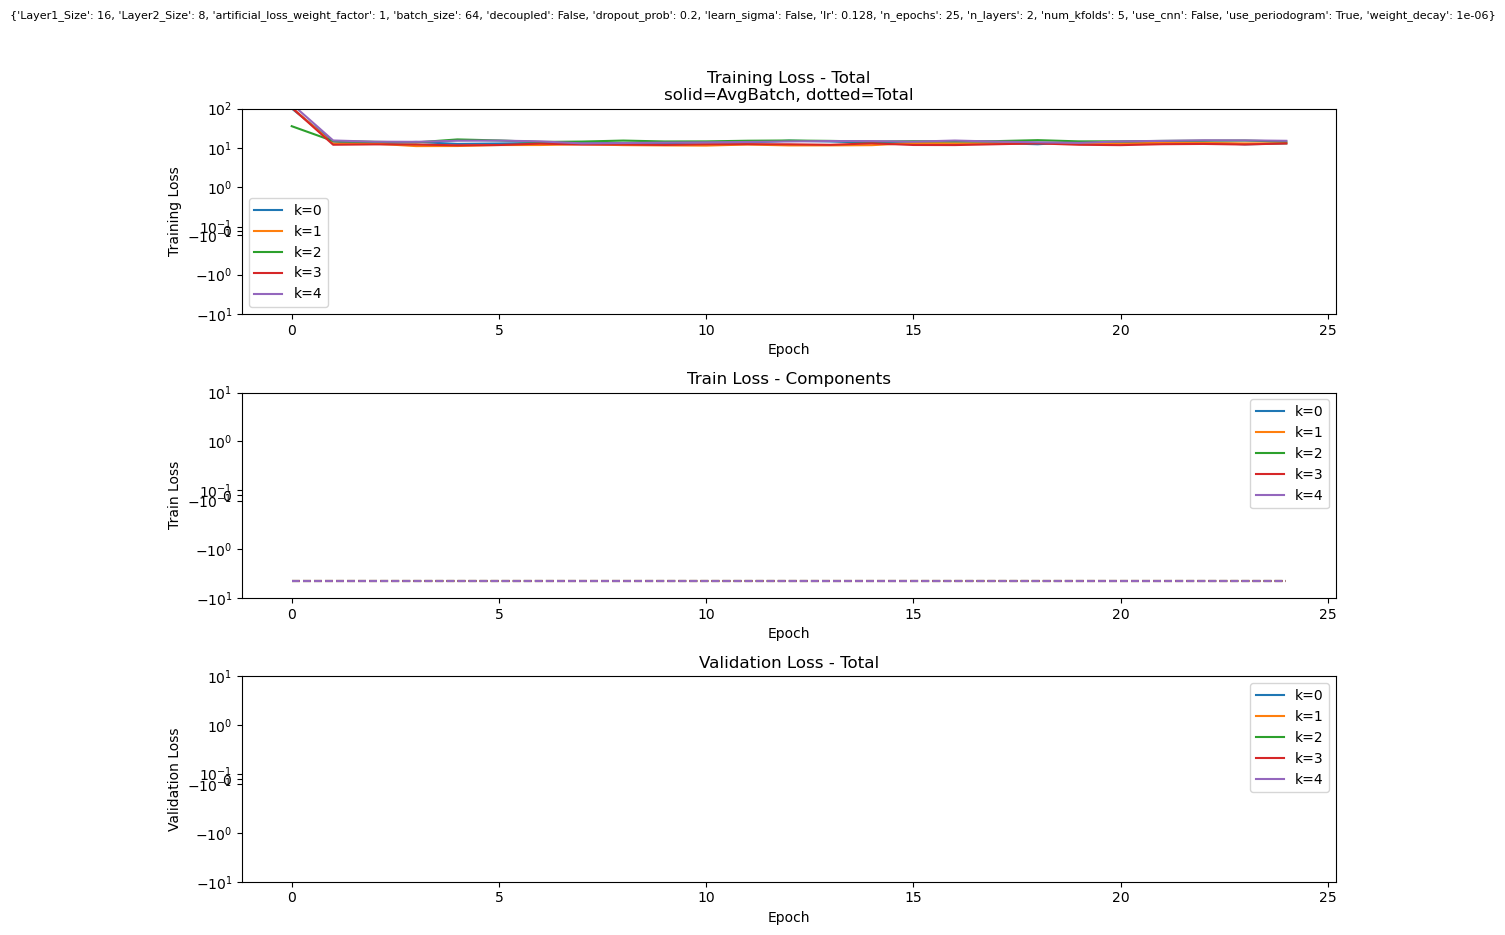

  Run # 15 , Params: {'Layer1_Size': 16, 'Layer2_Size': 8, 'artificial_loss_weight_factor': 1, 'batch_size': 256, 'decoupled': False, 'dropout_prob': 0.2, 'learn_sigma': False, 'lr': 0.001, 'n_epochs': 25, 'n_layers': 2, 'num_kfolds': 5, 'use_cnn': False, 'use_periodogram': True, 'weight_decay': 1e-06}
[11:24:09] Starting 5-fold cross-validation on device: cpu

[11:24:09] FOLD 1/5 STARTING
Validation clusters: 55 clusters
[11:24:09] [EPOCH START] Epoch 0, Total batches: 10
[11:24:10] [EPOCH START] Epoch 10, Total batches: 10
[11:24:11] [EPOCH START] Epoch 20, Total batches: 10

[11:24:12] FOLD 1/5 COMPLETE
   Final batch loss: 16.0617, Train loss: 22.6502, Val loss: 25.5875
   Fold time: 0.1min, Avg fold time: 0.1min
   Total elapsed: 0.1min, Est. remaining: 0.2min


[11:24:12] FOLD 2/5 STARTING
Validation clusters: 55 clusters
[11:24:12] [EPOCH START] Epoch 0, Total batches: 10
[11:24:13] [EPOCH START] Epoch 10, Total batches: 10
[11:24:14] [EPOCH START] Epoch 20, Total batches: 10

[

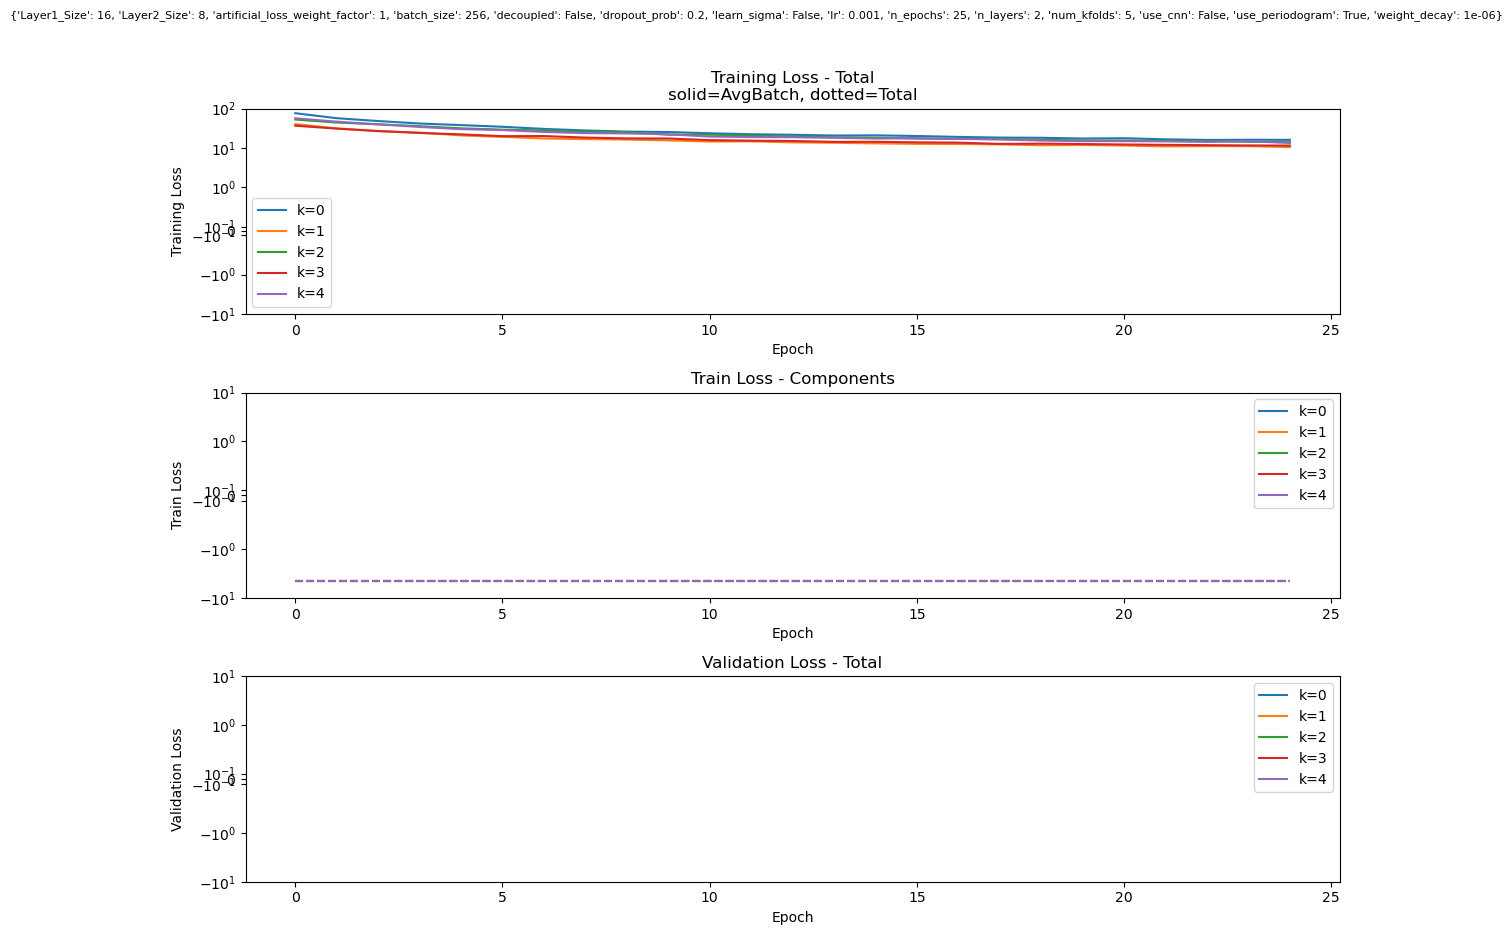

  Run # 16 , Params: {'Layer1_Size': 16, 'Layer2_Size': 8, 'artificial_loss_weight_factor': 1, 'batch_size': 256, 'decoupled': False, 'dropout_prob': 0.2, 'learn_sigma': False, 'lr': 0.004, 'n_epochs': 25, 'n_layers': 2, 'num_kfolds': 5, 'use_cnn': False, 'use_periodogram': True, 'weight_decay': 1e-06}
[11:24:24] Starting 5-fold cross-validation on device: cpu

[11:24:24] FOLD 1/5 STARTING
Validation clusters: 55 clusters
[11:24:24] [EPOCH START] Epoch 0, Total batches: 10
[11:24:26] [EPOCH START] Epoch 10, Total batches: 10
[11:24:27] [EPOCH START] Epoch 20, Total batches: 10

[11:24:27] FOLD 1/5 COMPLETE
   Final batch loss: 9.7091, Train loss: 15.0597, Val loss: 23.4596
   Fold time: 0.1min, Avg fold time: 0.1min
   Total elapsed: 0.1min, Est. remaining: 0.2min


[11:24:27] FOLD 2/5 STARTING
Validation clusters: 55 clusters
[11:24:28] [EPOCH START] Epoch 0, Total batches: 10
[11:24:29] [EPOCH START] Epoch 10, Total batches: 10
[11:24:30] [EPOCH START] Epoch 20, Total batches: 10

[1

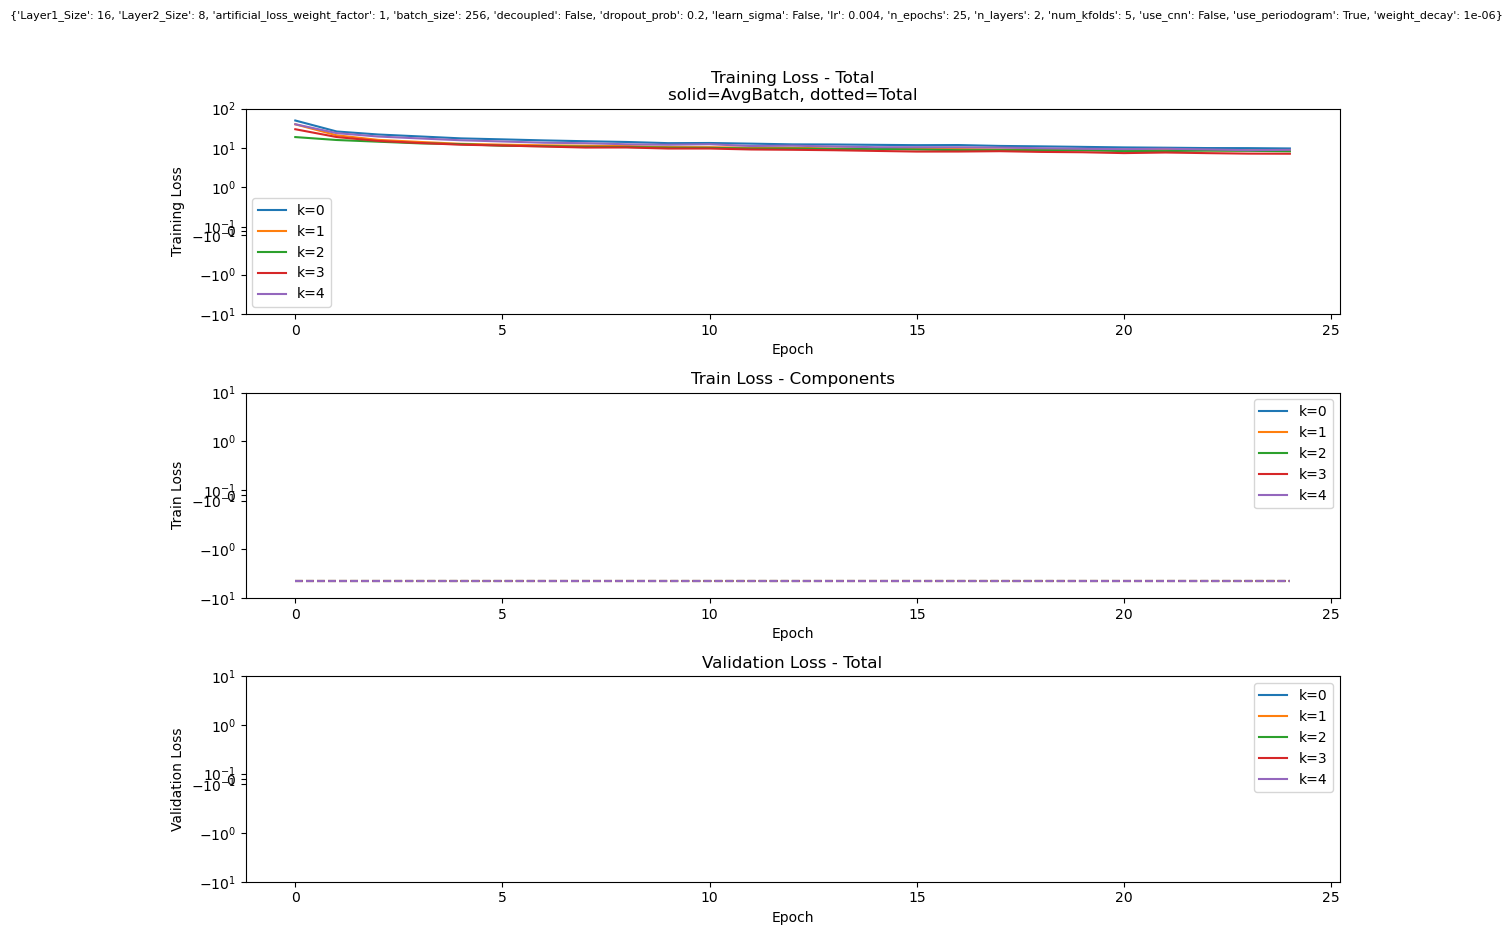

  Run # 17 , Params: {'Layer1_Size': 16, 'Layer2_Size': 8, 'artificial_loss_weight_factor': 1, 'batch_size': 256, 'decoupled': False, 'dropout_prob': 0.2, 'learn_sigma': False, 'lr': 0.016, 'n_epochs': 25, 'n_layers': 2, 'num_kfolds': 5, 'use_cnn': False, 'use_periodogram': True, 'weight_decay': 1e-06}
[11:24:40] Starting 5-fold cross-validation on device: cpu

[11:24:40] FOLD 1/5 STARTING
Validation clusters: 55 clusters
[11:24:40] [EPOCH START] Epoch 0, Total batches: 10
[11:24:41] [EPOCH START] Epoch 10, Total batches: 10
[11:24:43] [EPOCH START] Epoch 20, Total batches: 10

[11:24:44] FOLD 1/5 COMPLETE
   Final batch loss: 8.4748, Train loss: 12.5258, Val loss: 23.5710
   Fold time: 0.1min, Avg fold time: 0.1min
   Total elapsed: 0.1min, Est. remaining: 0.2min


[11:24:44] FOLD 2/5 STARTING
Validation clusters: 55 clusters
[11:24:44] [EPOCH START] Epoch 0, Total batches: 10
[11:24:45] [EPOCH START] Epoch 10, Total batches: 10
[11:24:46] [EPOCH START] Epoch 20, Total batches: 10

[1

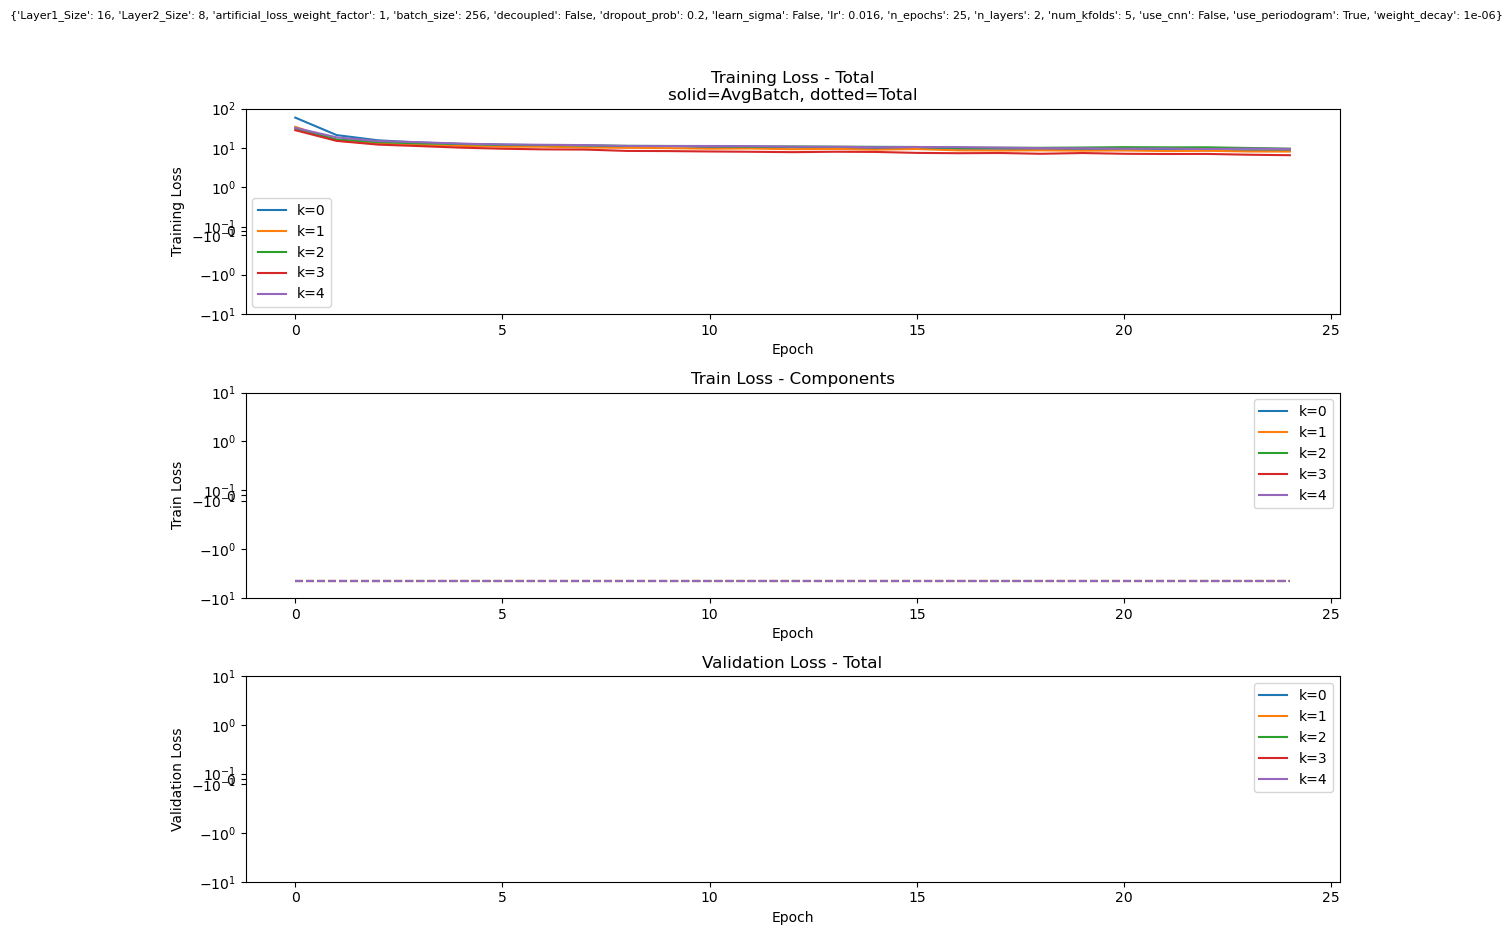

  Run # 18 , Params: {'Layer1_Size': 16, 'Layer2_Size': 8, 'artificial_loss_weight_factor': 1, 'batch_size': 256, 'decoupled': False, 'dropout_prob': 0.2, 'learn_sigma': False, 'lr': 0.064, 'n_epochs': 25, 'n_layers': 2, 'num_kfolds': 5, 'use_cnn': False, 'use_periodogram': True, 'weight_decay': 1e-06}
[11:24:56] Starting 5-fold cross-validation on device: cpu

[11:24:56] FOLD 1/5 STARTING
Validation clusters: 55 clusters
[11:24:56] [EPOCH START] Epoch 0, Total batches: 10
[11:24:58] [EPOCH START] Epoch 10, Total batches: 10
[11:24:59] [EPOCH START] Epoch 20, Total batches: 10

[11:24:59] FOLD 1/5 COMPLETE
   Final batch loss: 9.9261, Train loss: 15.3024, Val loss: 23.6012
   Fold time: 0.0min, Avg fold time: 0.0min
   Total elapsed: 0.0min, Est. remaining: 0.2min


[11:24:59] FOLD 2/5 STARTING
Validation clusters: 55 clusters
[11:24:59] [EPOCH START] Epoch 0, Total batches: 10
[11:25:01] [EPOCH START] Epoch 10, Total batches: 10
[11:25:02] [EPOCH START] Epoch 20, Total batches: 10

[1

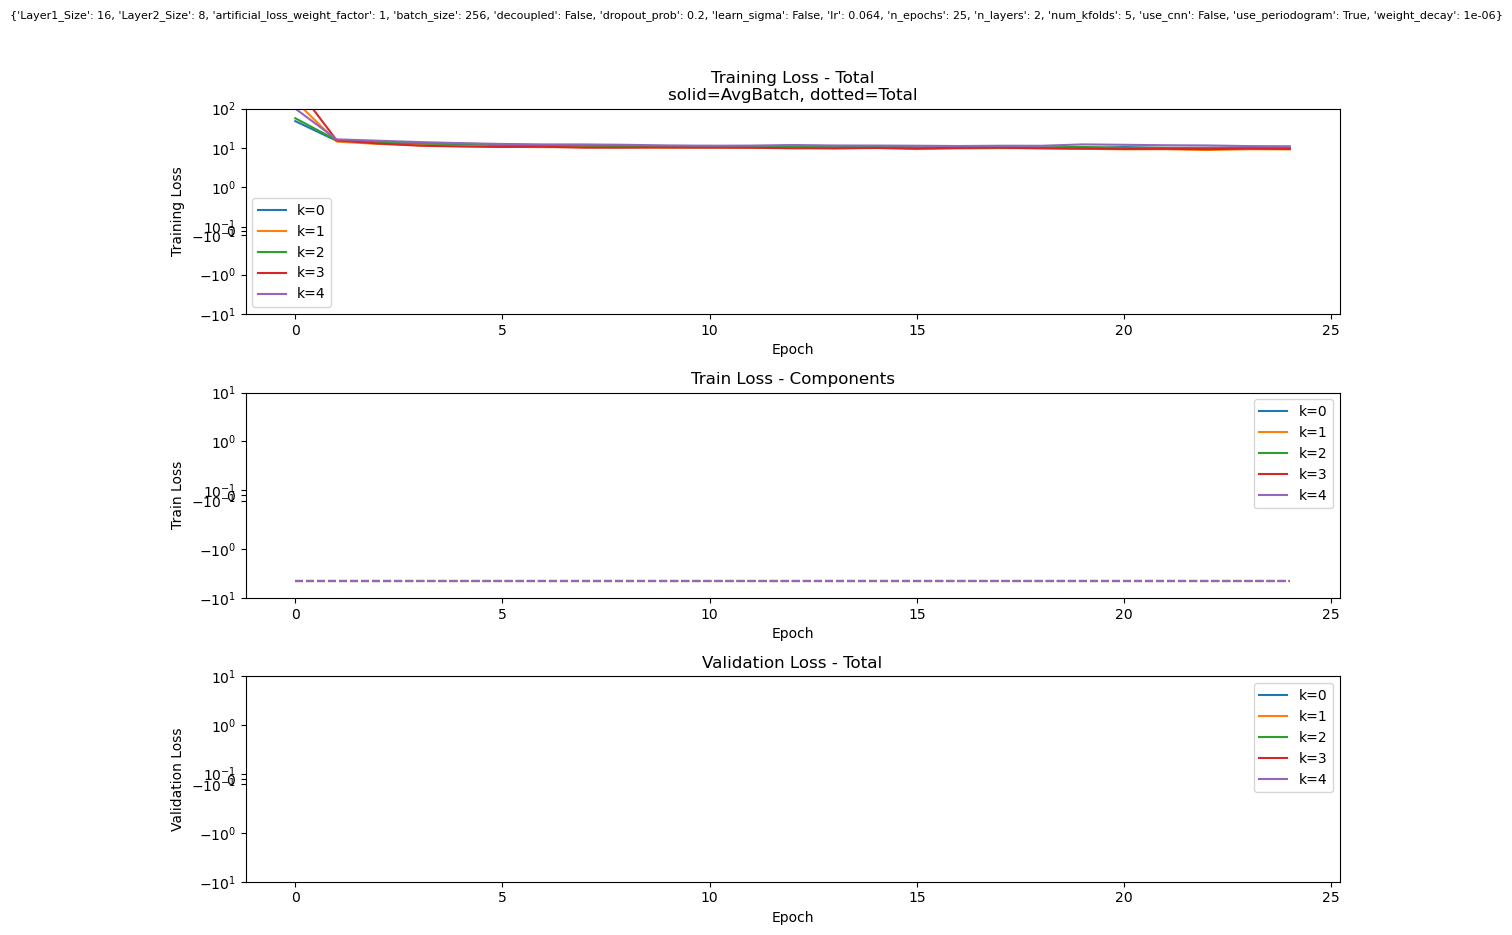

  Run # 19 , Params: {'Layer1_Size': 16, 'Layer2_Size': 8, 'artificial_loss_weight_factor': 1, 'batch_size': 256, 'decoupled': False, 'dropout_prob': 0.2, 'learn_sigma': False, 'lr': 0.128, 'n_epochs': 25, 'n_layers': 2, 'num_kfolds': 5, 'use_cnn': False, 'use_periodogram': True, 'weight_decay': 1e-06}
[11:25:12] Starting 5-fold cross-validation on device: cpu

[11:25:12] FOLD 1/5 STARTING
Validation clusters: 55 clusters
[11:25:12] [EPOCH START] Epoch 0, Total batches: 10
[11:25:13] [EPOCH START] Epoch 10, Total batches: 10
[11:25:15] [EPOCH START] Epoch 20, Total batches: 10

[11:25:15] FOLD 1/5 COMPLETE
   Final batch loss: 11.0001, Train loss: 17.7409, Val loss: 24.4761
   Fold time: 0.1min, Avg fold time: 0.1min
   Total elapsed: 0.1min, Est. remaining: 0.2min


[11:25:15] FOLD 2/5 STARTING
Validation clusters: 55 clusters
[11:25:15] [EPOCH START] Epoch 0, Total batches: 10
[11:25:16] [EPOCH START] Epoch 10, Total batches: 10
[11:25:18] [EPOCH START] Epoch 20, Total batches: 10

[

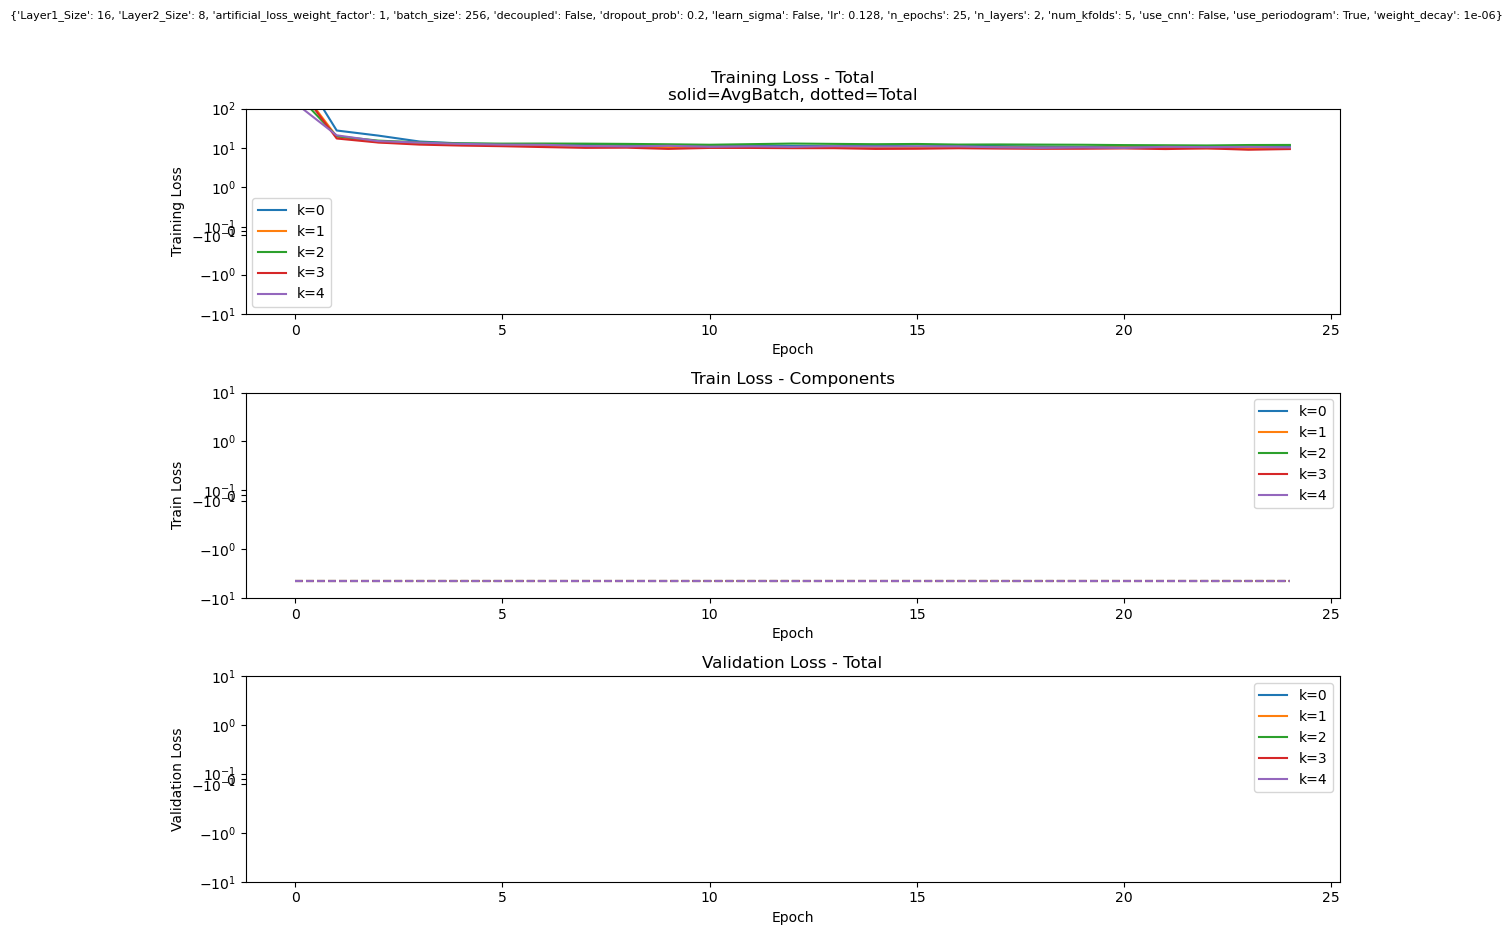

In [127]:
import time

save_path = temp_files_path+'ModelGridLogs/'
file_name = 'GondorTest_007_noSigma.pkl'


# Define the same hyperparameter grid as local training
params = {
    'use_periodogram': [True],
    'use_cnn': [False],
    'decoupled': [False],
    'learn_sigma': [False],
    
    'n_layers': [2],
    'Layer1_Size': [16],
    'Layer2_Size': [8],
    
    'dropout_prob': [0.2],
    'lr':   [1e-3, 4e-3, 16e-3, 64e-3, 128e-3],
    'batch_size': [2, 8, 64, 256],
    
    'n_epochs': [25],
    'artificial_loss_weight_factor': [1],
    'weight_decay': [1e-6],
    'num_kfolds': [5]
}

# Define which datasets you wish to use.
# Here there is just one, but the code could handle more if you specify different ones here.

summary_stat_dims = [X_train.shape[1]]
periodogram_dims = [period_train.shape[1]]

model_train_data_statistics   = [X_train]
model_train_data_periodogram  = [period_train]
model_train_data_Y            = [y_train]
model_train_data_clusternames = [train_cluster_names]

model_test_data_statistics    = [X_test]
model_test_data_periodogram   = [period_test]
model_test_data_Y             = [y_test]

model_names = ['Test_Model']

empty_train_log = {
        "epoch" : [], 
        "mean_batch_loss" : [], 
        "train_errLoss" : [], 
        "train_sigmaLoss" : [], 
        "train_Loss" : [], 
        "train_MAE"  : [], 
        "train_RMSE" : [], 
        "train_median_sigma" : [], 
        "train_mean_sigma" : [], 
        "train_Coverage68" : [], 
        "train_Coverage95" : [], 
        "train_CRPS" : [], 
        "valid_errLoss" : [], 
        "valid_sigmaLoss" : [], 
        "valid_Loss" : [], 
        "valid_MAE"  : [], 
        "valid_RMSE" : [], 
        "valid_median_sigma" : [], 
        "valid_mean_sigma" : [], 
        "valid_Coverage68" : [], 
        "valid_Coverage95" : [], 
        "valid_CRPS" : [], 
}               

all_runs_log = {
    model_name: {
        run_id: {
            **{
                "params": config_dict,
            },
            **{
                k_id: {
                    "model": None,
                    "log": copy.deepcopy(empty_train_log)
                } for k_id in range(config_dict['num_kfolds'])
            }
        } for run_id, config_dict in enumerate(ParameterGrid(params))
        # SHOULD ADD THE MODEL DATA HERE, wont be memory efficient but much cleaner code for plotting and our data is small.
    } for model_name in model_names
    
}



for i, model_name in enumerate(model_names):    
    stats_dim = summary_stat_dims[i] # X_train.shape[1]
    period_dim = periodogram_dims[i] # period_train.shape[1]
    
    X_stats  = model_train_data_statistics[i]
    X_period = model_train_data_periodogram[i]
    X_cluster_names = model_train_data_clusternames[i]
    Y        = model_train_data_Y[i]
    
    test_X_stats  = model_test_data_statistics[i]
    test_X_period = model_test_data_periodogram[i]
    test_Y        = model_test_data_Y[i]


    if torch.isnan(X_stats).any():
        print("Warning: NaNs detected in X_train")
    
    if torch.isnan(X_test).any():
        print("Warning: NaNs detected in X_test")
    
    run_id = 0
    for Params in ParameterGrid(params):
        
        print('  Run #', run_id, ', Params:', Params)
        model_class = DualInputNN

        all_runs_log[model_name][run_id] = kfold_cross_validation(X_stats, X_period, X_cluster_names, Y,
                                                                model_class, Params, 
                                                                all_runs_log[model_name][run_id], 
                                                                device=device,  # Use auto-detected device
                                                                seed=42,
                                                                verbose=1)
        
        ## Probably should add a plotting function call here to show how the different folds compare against eachother. ##
        plot_run_log(all_runs_log[model_name][run_id])
        
        run_id += 1

    
### Export the Training log

# Not to be used for long-term saving as the dataset is also relevent, but useful for experimenting and not having to retrain models and such.

with open(save_path+file_name, 'wb') as f:
    pickle.dump(all_runs_log, f)

In [129]:
print('hi')

hi


In [ ]:
print('hi2')

hi2


In [130]:
# Load training results from local save

#GondorTest_005 - large LR/BS grid
#GondorTest_006 - narrow LR/BS grid
#GondorTest_006 - narrow LR/BS grid, for sigma=0.
#GondorTest_007_noSigma - narrow LR/BS grid, for sigma=0.


load_from_save = False
if load_from_save:
    save_path = temp_files_path+'ModelGridLogs/'
    file_name = 'GondorTest_007_noSigma.pkl'
    
    with open(save_path+file_name, 'rb') as f:
        all_runs_log = pickle.load(f)
    print(f"Loaded {len(all_runs_log)} model configurations from {file_name}")


In [ ]:
print(np.__version__)

# Plot the Model Performance

In [117]:
# Enable autoreload - automatically reloads modules when they change
%load_ext autoreload
%autoreload 2 

# Load in yt datasets
import sys
sys.path.append(project_dir_path)

from Kfold_PlottingFcns import plot_trainval_loss_evolution, plot_all_metric_evolution
import SingleFold_PlottingFcns
from SingleFold_PlottingFcns import print_and_plot_summary_stats, plot_2d_statistics

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Test_Model


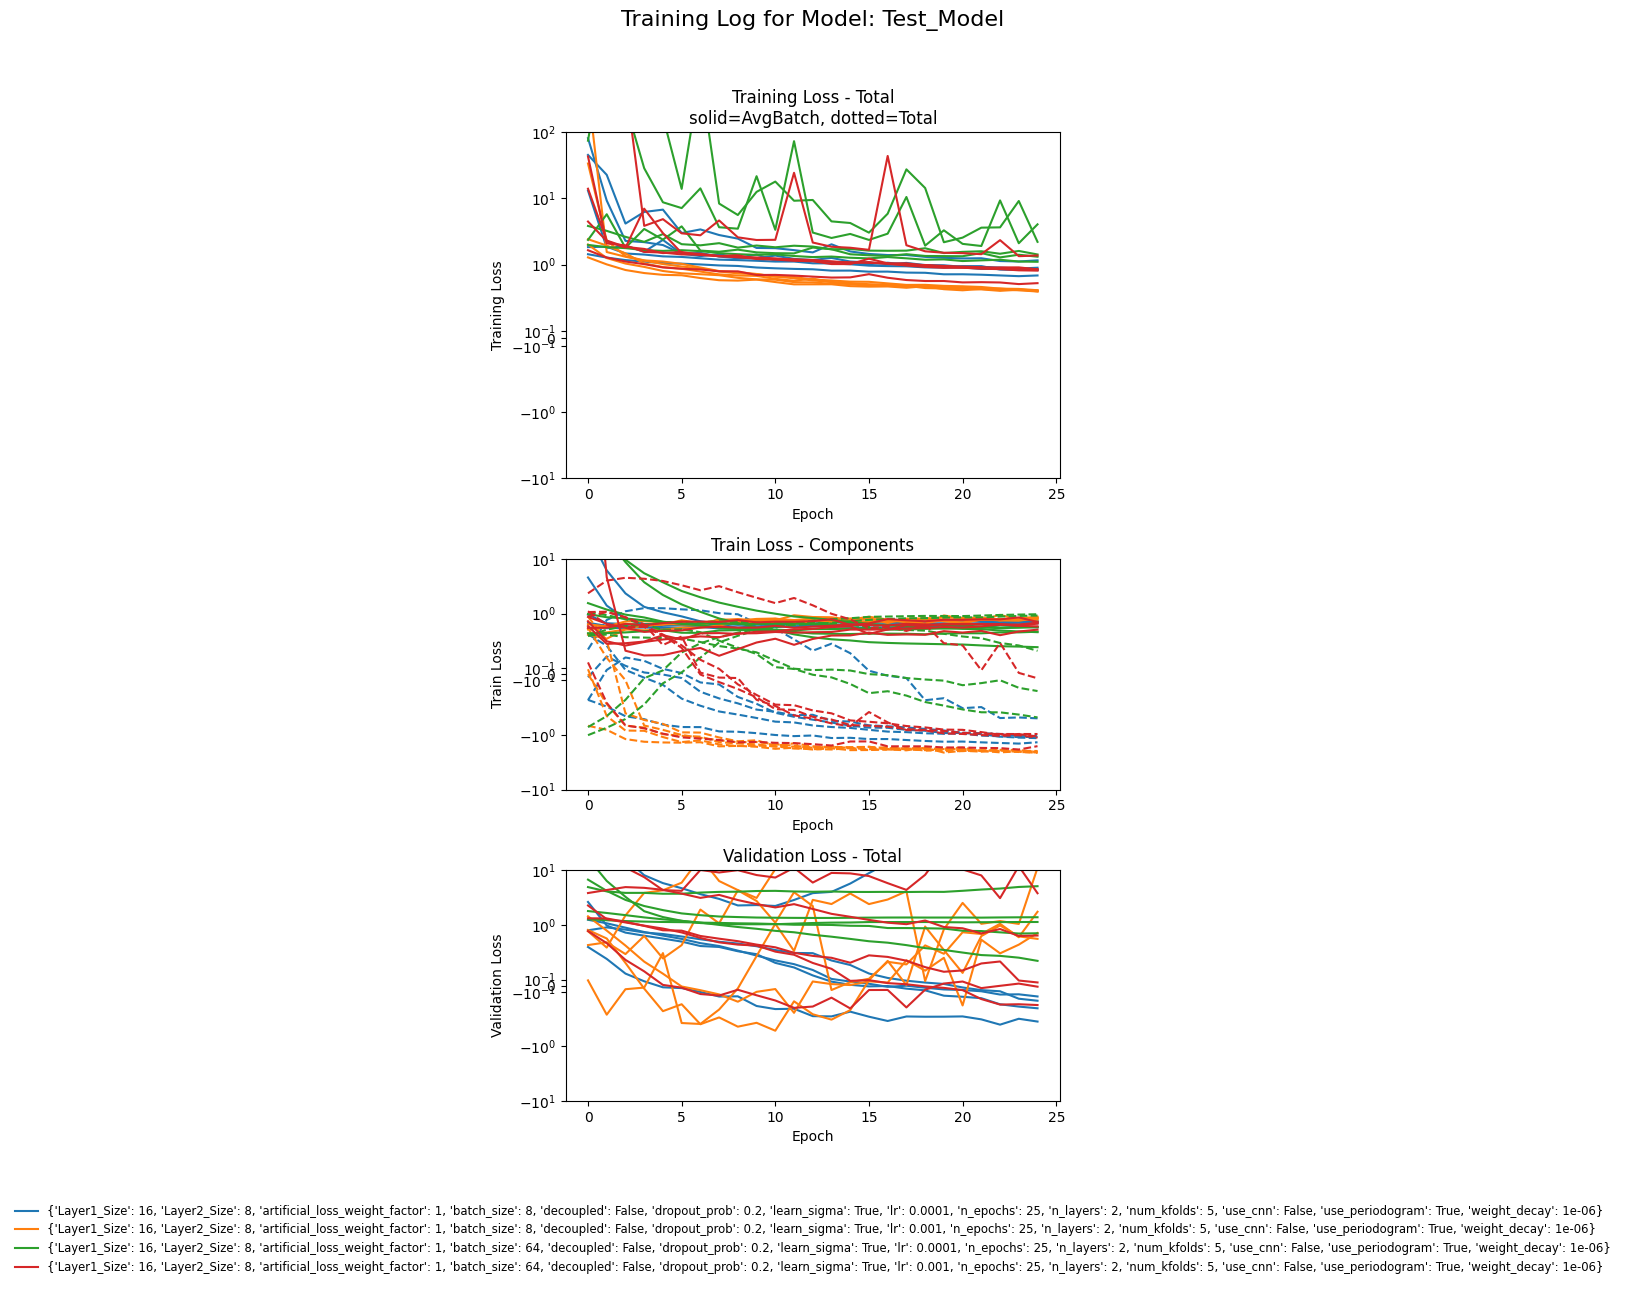

In [43]:

# First Simply Plot the Loss Vs. Epoch
plot_trainval_loss_evolution(all_runs_log)

Test_Model
Run_id 0
      train_Loss = 7.812272; epoch = 23
      mean_batch_loss = 6.496532; epoch = 24
      train_Loss = 7.812272; epoch = 23
      valid_Loss = 22.254225; epoch = 5
      train_errLoss = 12.417443; epoch = 23
      valid_errLoss = 26.859396; epoch = 5
      train_sigmaLoss = -4.605171; epoch = 0
      valid_sigmaLoss = -4.605171; epoch = 0
Run_id 1
      train_Loss = 10.963539; epoch = 23
      mean_batch_loss = 8.232286; epoch = 24
      train_Loss = 10.963539; epoch = 23
      valid_Loss = 21.076597; epoch = 9
      train_errLoss = 15.568710; epoch = 23
      valid_errLoss = 25.681768; epoch = 9
      train_sigmaLoss = -4.605171; epoch = 0
      valid_sigmaLoss = -4.605171; epoch = 0
Run_id 2
      train_Loss = 20.773691; epoch = 21
      mean_batch_loss = 12.616552; epoch = 14
      train_Loss = 20.773691; epoch = 21
      valid_Loss = 23.284472; epoch = 17
      train_errLoss = 25.378862; epoch = 21
      valid_errLoss = 27.889643; epoch = 17
      train_sigmaLo

/astro/users/cgwill/TESS_Cluster_Age_ML/GaussianNN_CGW/Model_Pipeline/Kfold_PlottingFcns.py:351: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  axs[metric_id].fill_between(x, y_lower, y_upper, color=color, alpha=0.3)


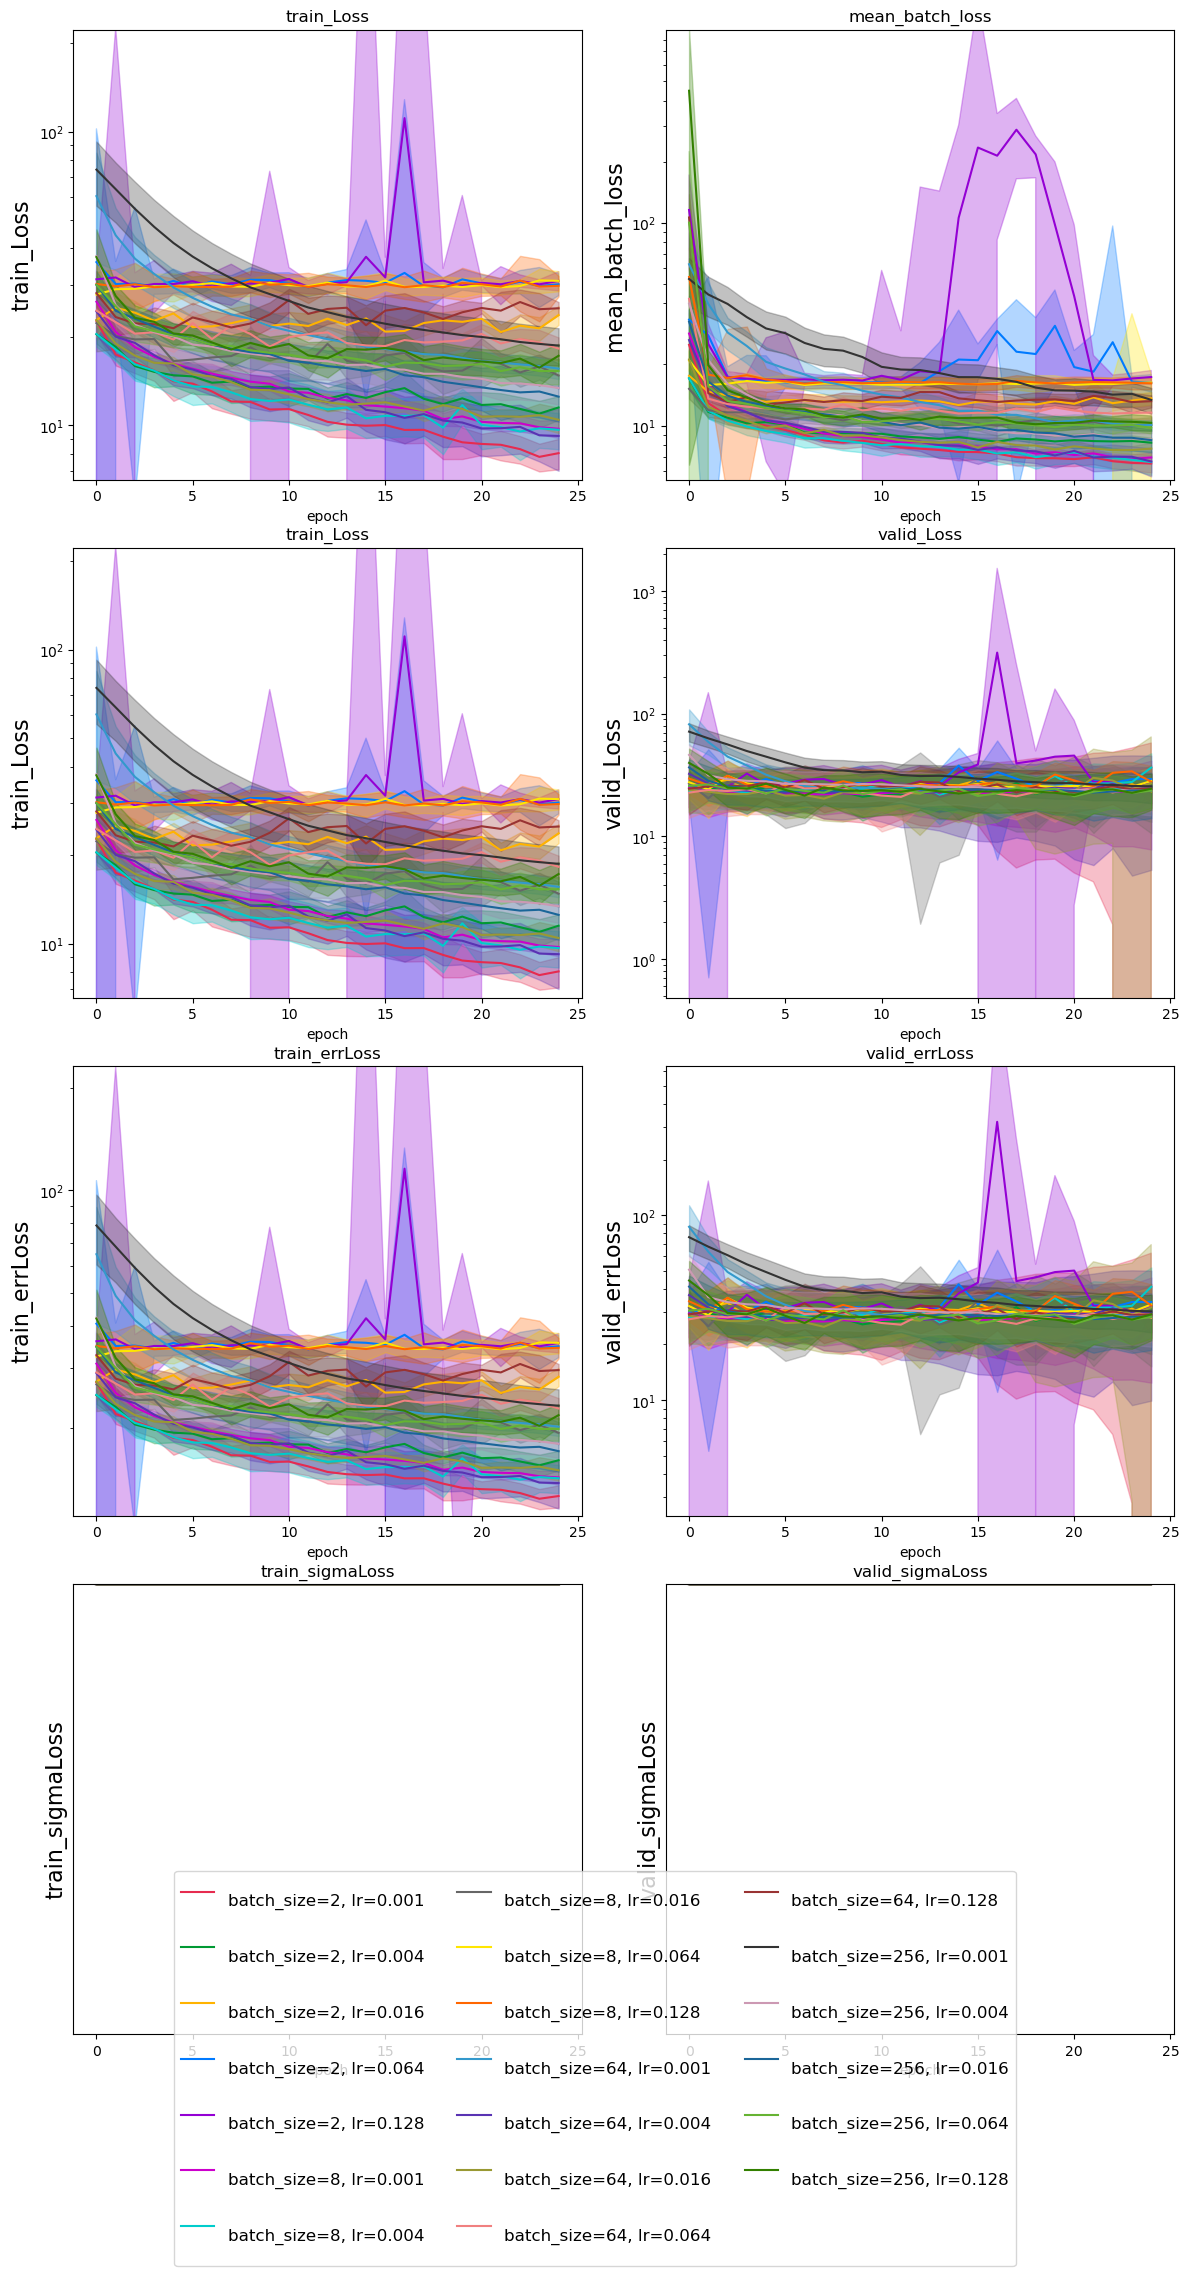

Test_Model
Run_id 0
      train_RMSE = 0.352384; epoch = 23
      valid_RMSE = 0.518261; epoch = 5
      train_MAE = 0.257138; epoch = 23
      valid_MAE = 0.351454; epoch = 10
      train_median_sigma = 0.100000; epoch = 0
      valid_median_sigma = 0.100000; epoch = 0
      train_mean_sigma = 0.100000; epoch = 0
      valid_mean_sigma = 0.100000; epoch = 0
Run_id 1
      train_RMSE = 0.394572; epoch = 23
      valid_RMSE = 0.506772; epoch = 9
      train_MAE = 0.281041; epoch = 24
      valid_MAE = 0.339611; epoch = 9
      train_median_sigma = 0.100000; epoch = 0
      valid_median_sigma = 0.100000; epoch = 0
      train_mean_sigma = 0.100000; epoch = 0
      valid_mean_sigma = 0.100000; epoch = 0
Run_id 2
      train_RMSE = 0.503774; epoch = 21
      valid_RMSE = 0.528107; epoch = 17
      train_MAE = 0.370602; epoch = 19
      valid_MAE = 0.362573; epoch = 0
      train_median_sigma = 0.100000; epoch = 0
      valid_median_sigma = 0.100000; epoch = 0
      train_mean_sigma = 0.100

/astro/users/cgwill/TESS_Cluster_Age_ML/GaussianNN_CGW/Model_Pipeline/Kfold_PlottingFcns.py:390: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  axs[metric_id].set_ylim(new_ymin, new_ymax)


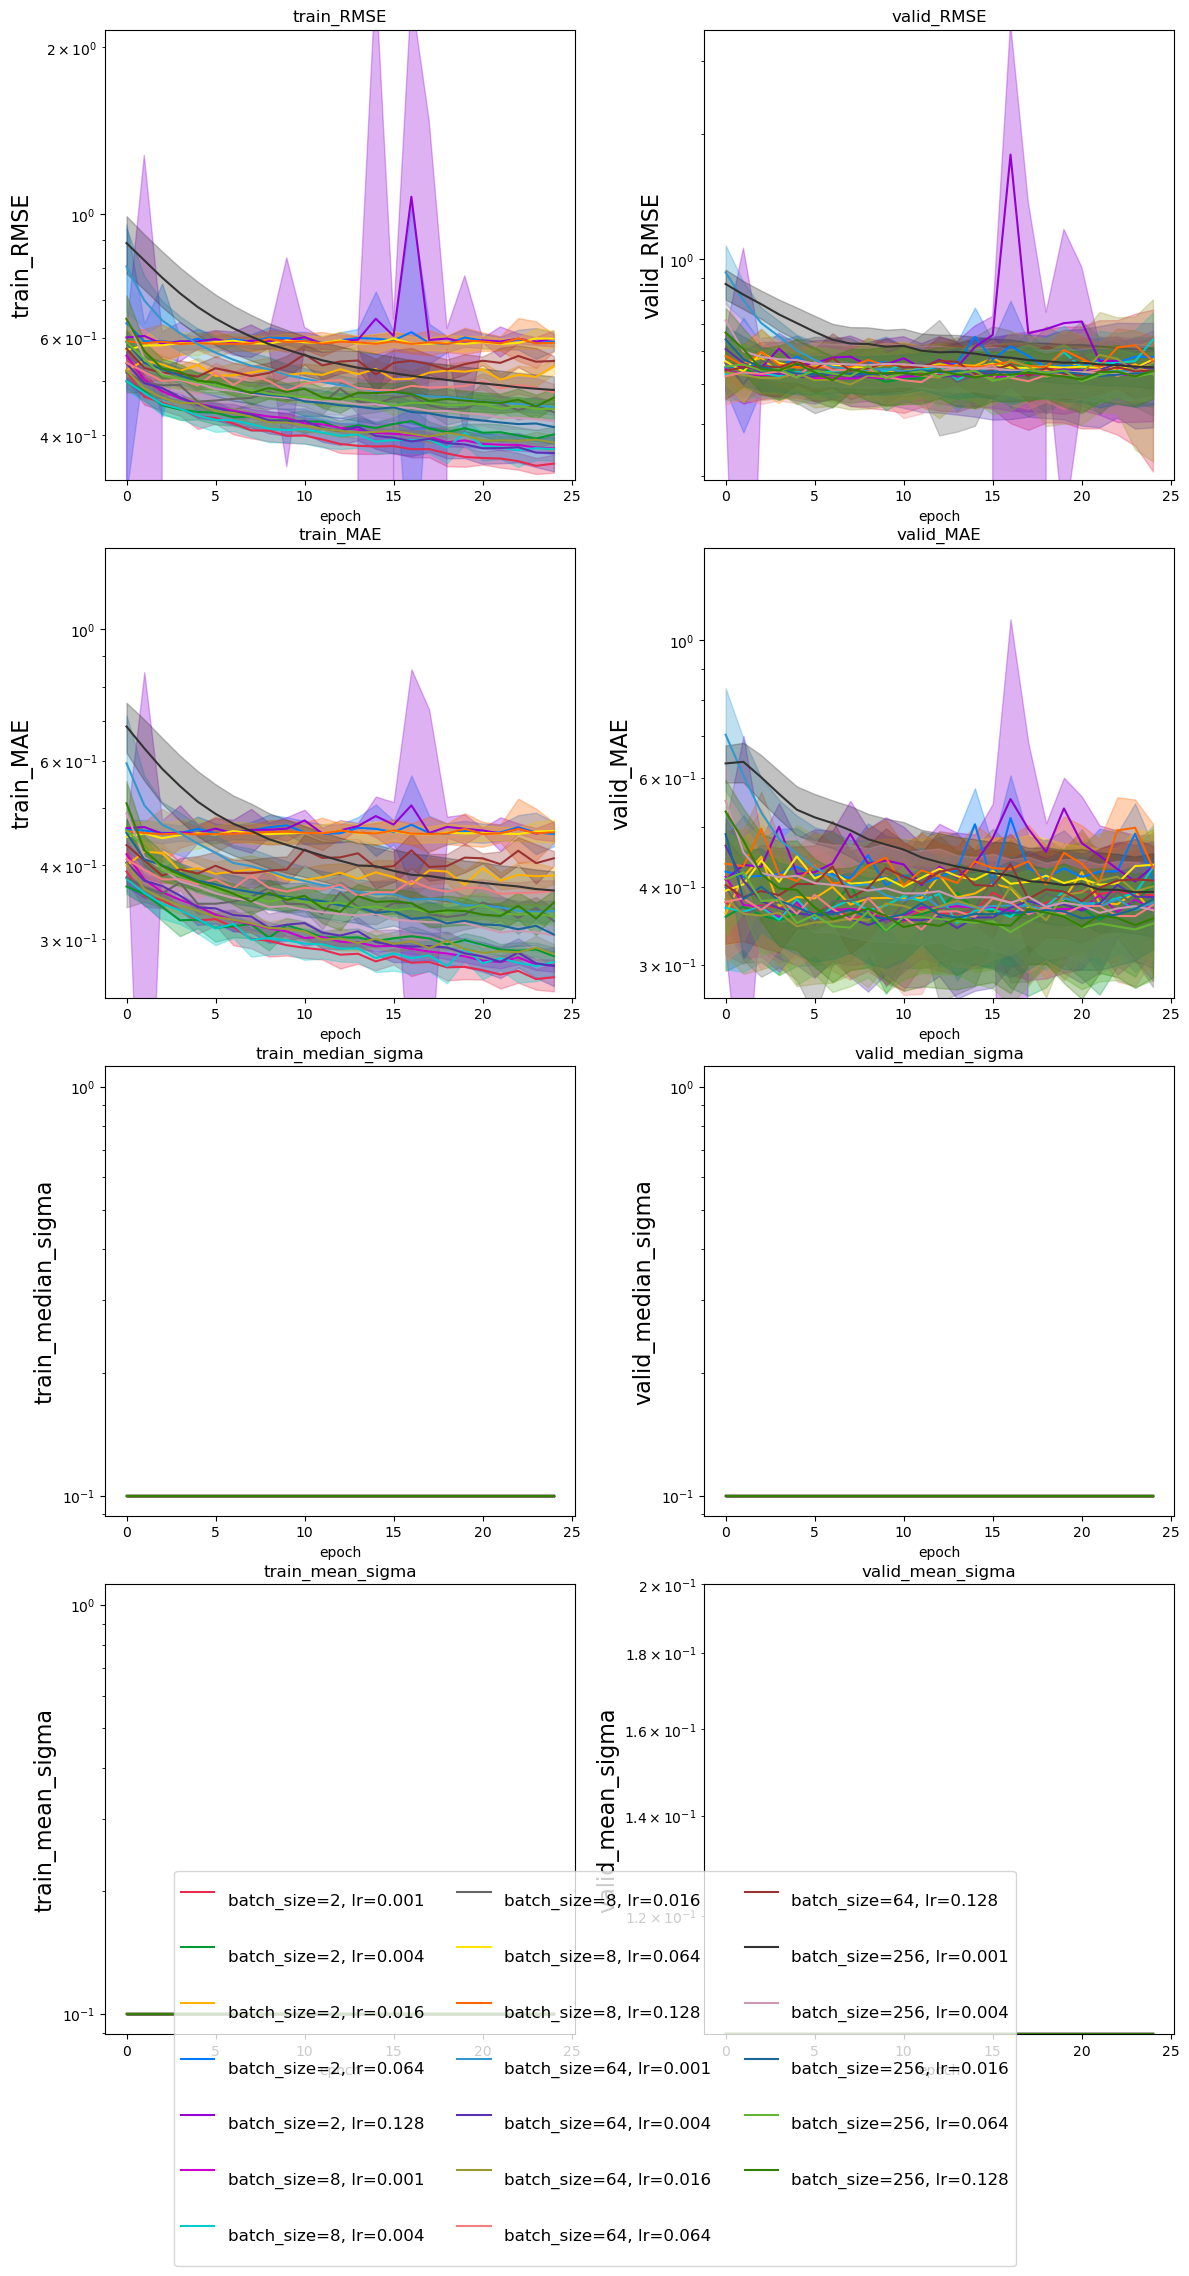

Test_Model
Run_id 0
      train_Coverage68 = 0.401649; epoch = 23
      valid_Coverage68 = 0.483797; epoch = 11
      train_Coverage95 = 0.444057; epoch = 23
      valid_Coverage95 = 0.549684; epoch = 11
      train_CRPS = 0.214553; epoch = 23
      valid_CRPS = 0.304923; epoch = 10
Run_id 1
      train_Coverage68 = 0.422472; epoch = 22
      valid_Coverage68 = 0.448254; epoch = 9
      train_Coverage95 = 0.471791; epoch = 22
      valid_Coverage95 = 0.526190; epoch = 5
      train_CRPS = 0.238064; epoch = 24
      valid_CRPS = 0.295703; epoch = 9
Run_id 2
      train_Coverage68 = 0.492054; epoch = 8
      valid_Coverage68 = 0.478413; epoch = 12
      train_Coverage95 = 0.583518; epoch = 13
      valid_Coverage95 = 0.523016; epoch = 4
      train_CRPS = 0.323748; epoch = 16
      valid_CRPS = 0.315912; epoch = 0
Run_id 3
      train_Coverage68 = 0.493640; epoch = 8
      valid_Coverage68 = 0.433165; epoch = 4
      train_Coverage95 = 0.620364; epoch = 5
      valid_Coverage95 = 0.58607

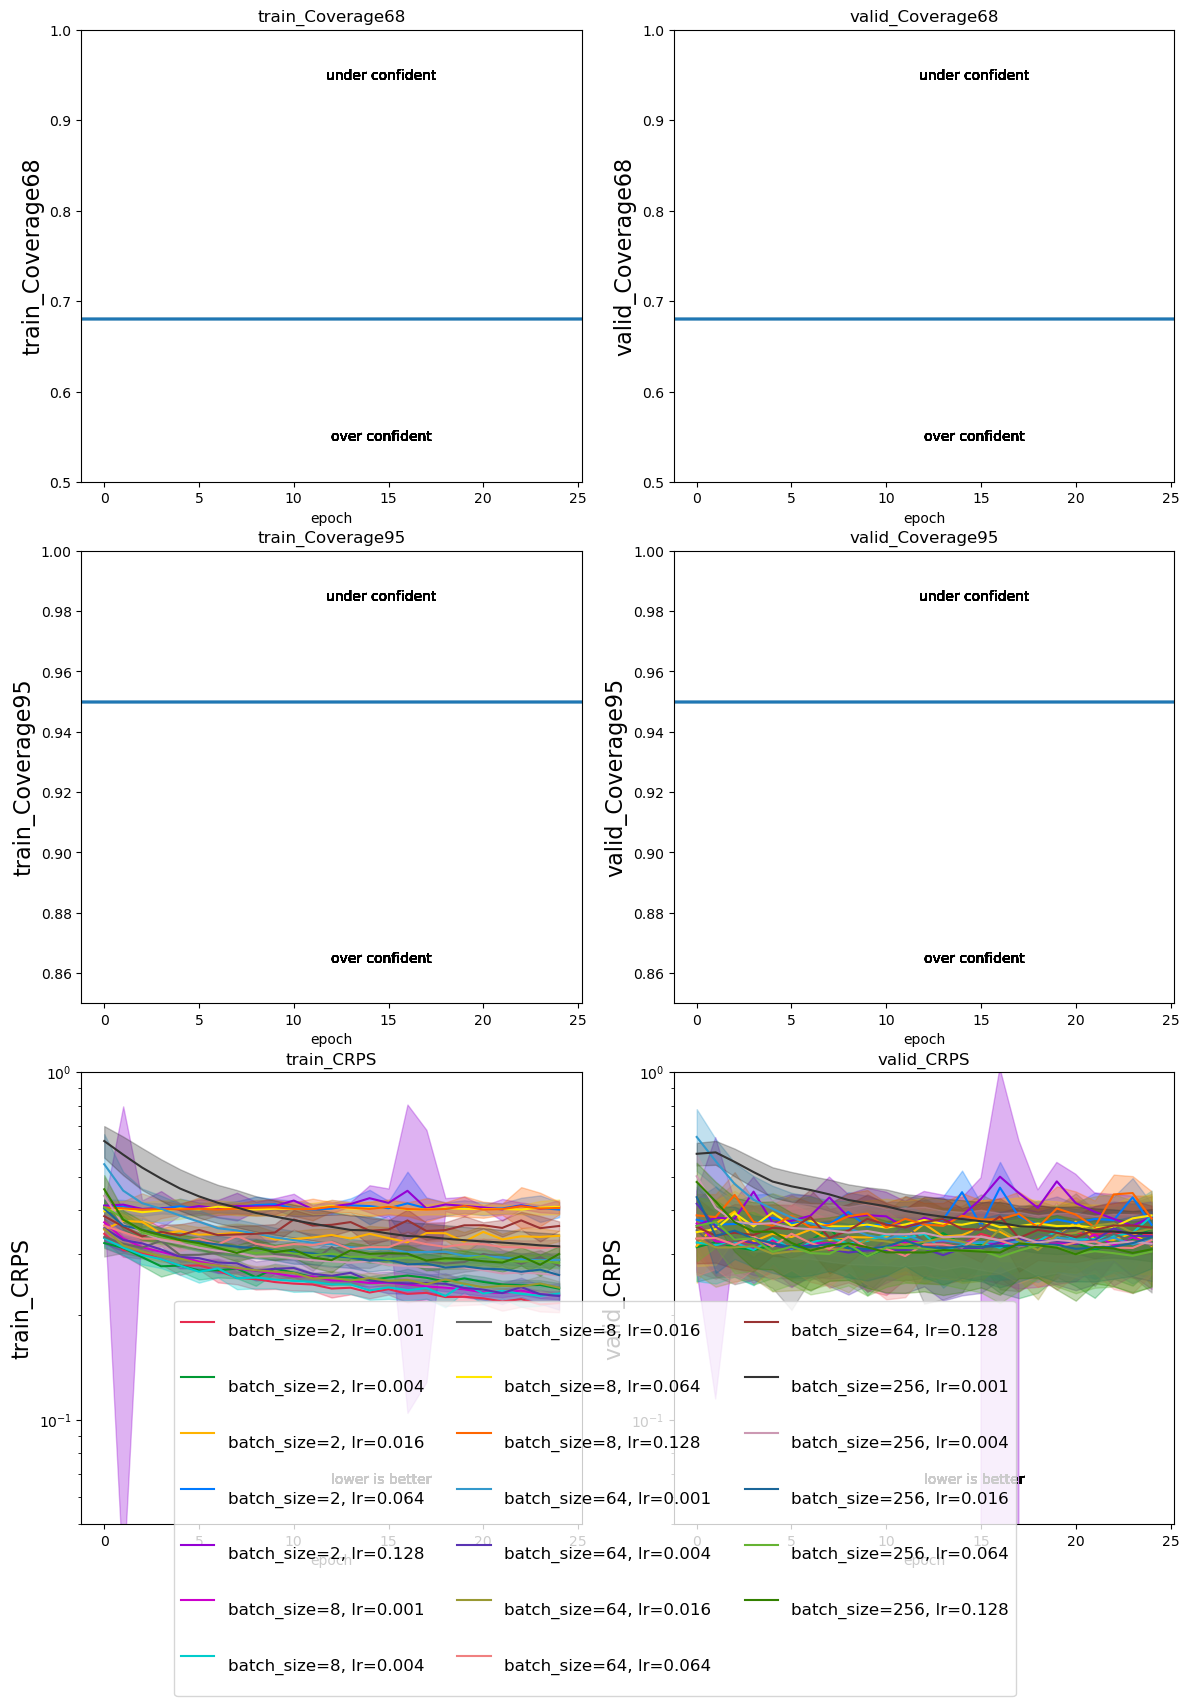

In [132]:

# between dropout prob of .2 and .4, .2 is better but .4 looks more stable.
plot_all_metric_evolution(all_runs_log, 
                           #specific_lr=1e-3, 
                           #specific_batchsize=20, 
                           #specific_dropout=0.2,
                           #use_minmax_spread=True
                          )

--- Test_Model ---


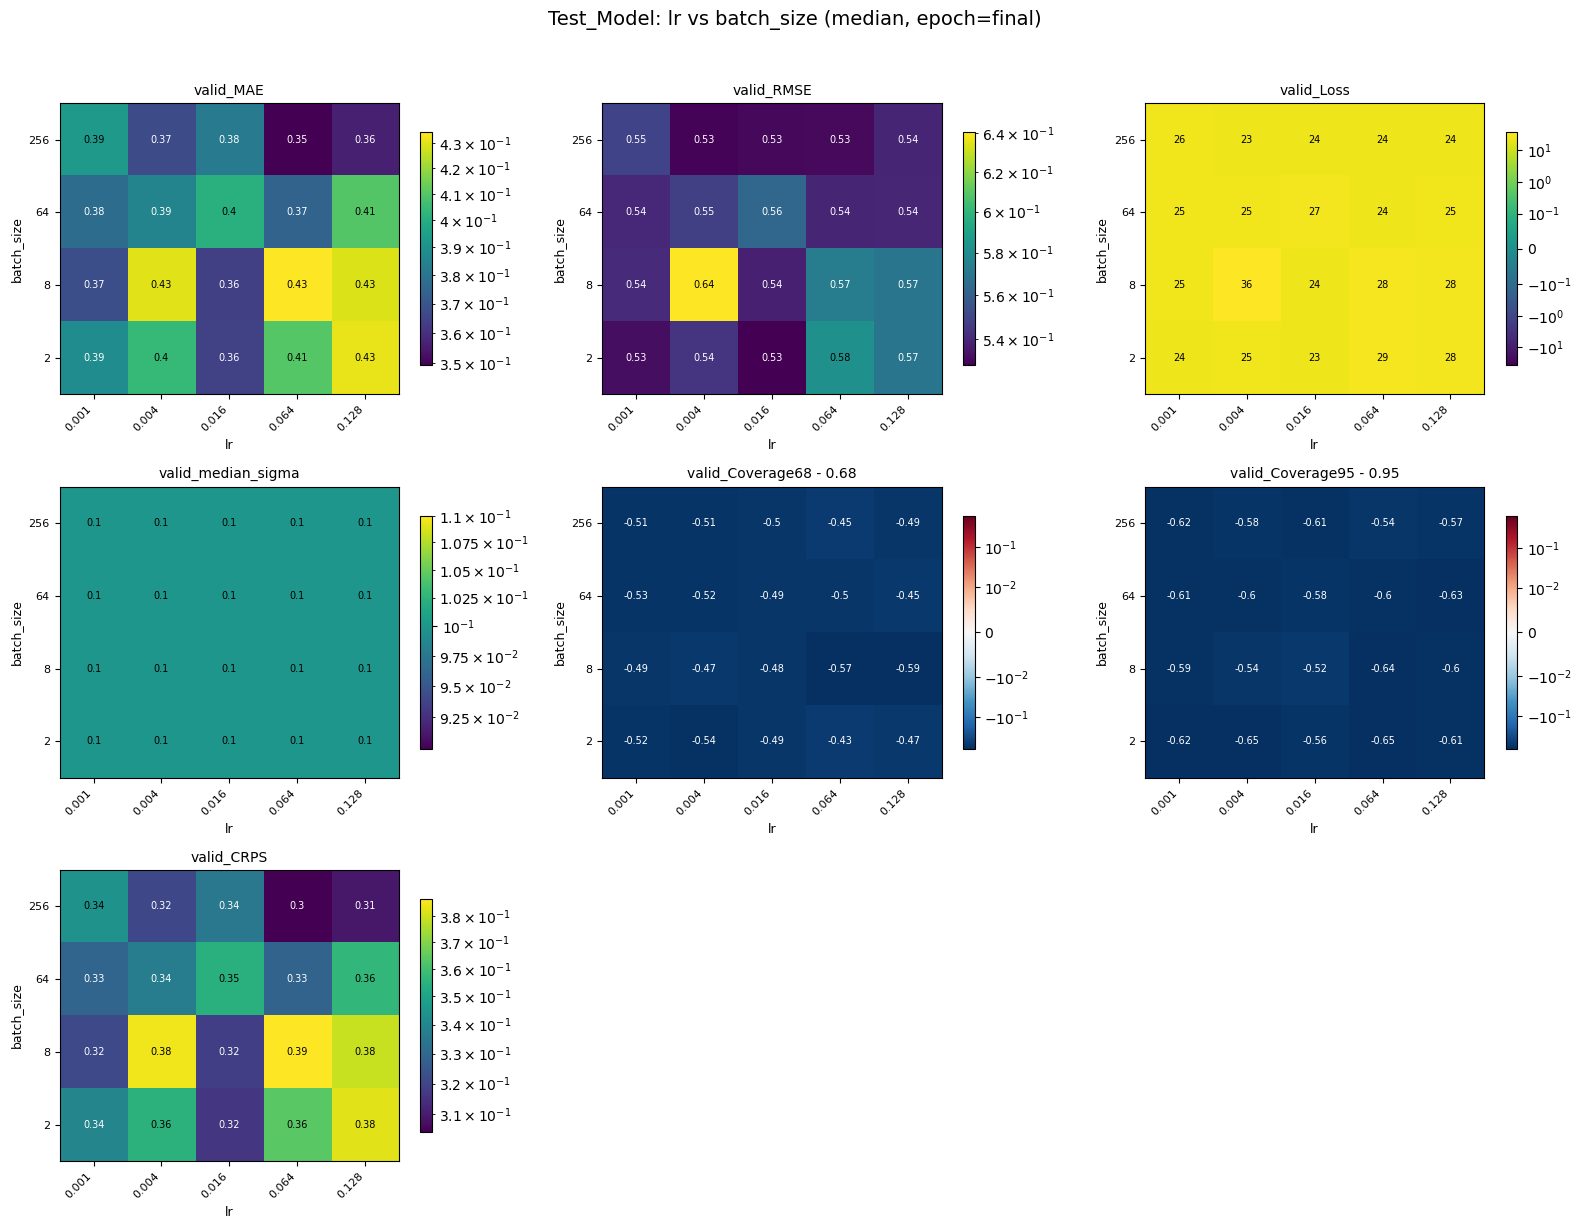

In [131]:
plot_2d_statistics(all_runs_log, 'lr', 'batch_size',
                           fold_agg='median',
                           epoch_select='final')

In [114]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

# ==========================================================
# Utility helpers
# ==========================================================

def smooth_curve(y, window=5):
    """
    Moving average smoothing with edge handling: only average available points.
    """
    y = np.array(y)
    n = len(y)
    if n == 0:
        return y
    smoothed = np.zeros_like(y)
    for i in range(n):
        start = max(0, i - window // 2)
        end = min(n, i + window // 2 + 1)
        smoothed[i] = np.mean(y[start:end])
    return smoothed


def average_kfold_logs(run_entry):
    """Average metrics over all k-folds in a single run."""
    logs = [v['log'] for k, v in run_entry.items() if isinstance(k, int)]
    if not logs:
        return {}
    keys = logs[0].keys()
    avg_log = {}
    for key in keys:
        arrays = [np.array(log[key]) for log in logs if len(log[key]) > 0]
        if arrays:
            # Only stack if we have valid arrays with data
            stacked = np.stack(arrays)
            if stacked.size > 0:
                with np.errstate(all='ignore'):  # Suppress warnings for empty slices
                    avg_log[key] = np.nanmean(stacked, axis=0)
            else:
                avg_log[key] = np.array([])
        else:
            avg_log[key] = np.array([])
    return avg_log


def get_kfold_array(run_data, key):
    """Return array shaped (kfold, epoch) for a given metric, aligned to shortest fold."""
    curves = []
    for k, v in run_data.items():
        if isinstance(k, int) and key in v['log'] and len(v['log'][key]) > 0:
            curves.append(np.asarray(v['log'][key], dtype=float))
    if not curves:
        return None
    L = min(len(c) for c in curves)      # align folds
    if L == 0:
        return None
    return np.stack([c[:L] for c in curves], axis=0)

# ==========================================================
# Ranking function
# ==========================================================

def rank_models_by_validation(all_runs_log, smooth_window=5,
                              weights={'loss':2, 'cov68':1, 'cov95':1, 'err1':1, 'err2':1},
                              err_metric1='valid_RMSE', err_metric2='valid_MAE',
                              color_by='rank'):
    """
    Find best epoch per model/run using smoothed validation loss,
    compute composite score using loss, coverage, and error metrics,
    then rank models and plot summary.
    """

    records = []

    for model_name, runs in all_runs_log.items():
        for run_id, run_data in runs.items():
            params = run_data['params']
            avg_log = average_kfold_logs(run_data)

            if not avg_log or 'valid_Loss' not in avg_log:
                print(f"Skipping {model_name} run {run_id}: missing log data")
                continue

            # Check if valid_Loss has data
            if len(avg_log['valid_Loss']) == 0:
                print(f"Skipping {model_name} run {run_id}: empty valid_Loss")
                continue

            val_loss = avg_log['valid_Loss']
            cov68    = avg_log['valid_Coverage68']
            cov95    = avg_log['valid_Coverage95']
            err1     = avg_log.get(err_metric1, np.zeros_like(val_loss))
            err2     = avg_log.get(err_metric2, np.zeros_like(val_loss))

            # Find best epoch using fold stability (mean + lam*std)
            loss_folds = get_kfold_array(run_data, 'valid_Loss')
            if loss_folds is None:
                print(f"Skipping {model_name} run {run_id}: missing fold loss data")
                continue
            
            lam = 0.5  # bigger = penalize fold-to-fold instability more
            mean_loss = np.nanmean(loss_folds, axis=0)
            std_loss  = np.nanstd(loss_folds, axis=0)
            
            # Check for all-NaN before calling nanargmin
            combined_loss = mean_loss + lam * std_loss
            if np.all(np.isnan(combined_loss)):
                print(f"Skipping {model_name} run {run_id}: all-NaN loss data")
                continue
            
            best_epoch = int(np.nanargmin(combined_loss))
            best_loss  = float(mean_loss[best_epoch])   # use raw mean, not smoothed

            #Given best epoch identify metrics.
            best_loss = val_loss[best_epoch]
            best_cov68 = cov68[best_epoch]
            best_cov95 = cov95[best_epoch]
            best_err1 = err1[best_epoch]
            best_err2 = err2[best_epoch]

            # Compute a composite score
            score = (
                weights['loss'] * best_loss +
                weights['cov68'] * abs(best_cov68 - 0.68) +
                weights['cov95'] * abs(best_cov95 - 0.95) +
                weights['err1'] * best_err1 +
                weights['err2'] * best_err2
            )

            records.append({
                'model': model_name,
                'run_id': run_id,
                'params': params,
                'best_epoch': best_epoch,
                'best_loss': best_loss,
                'best_cov68': best_cov68,
                'best_cov95': best_cov95,
                'best_err1': best_err1,
                'best_err2': best_err2,
                'score': score
            })

    df = pd.DataFrame(records)
    if df.empty:
        print("No valid data found.")
        return df

    df_sorted = df.sort_values('score', ascending=True).reset_index(drop=True)
    df_sorted['rank'] = np.arange(1, len(df_sorted) + 1)
    
    print("=== Ranked Models ===")
    for _, row in df_sorted.iterrows():
        print(f"Rank {row['rank']:02d}: {row['model']} "
              f"(score={row['score']:.4f}, epoch={row['best_epoch']})")
        print(f"     params: {row['params']}")
    print("============================================\n")

    return df_sorted


# ==========================================================
# Plotting function
# ==========================================================
def plot_ranked_model_metrics(all_runs_log, df_sorted, err_metric1, err_metric2,
                              weights=None, smooth_window=5, color_by='rank',
                             range_n_models=[0, 1e20],
                              err1_lims=None, err2_lims=None, loss_lims=None,
                              
                             log_colorbar=False):
    """
    Plot 6 metrics for ranked models:
    1) Weighted summed evaluation metric (symlog)
    2) Validation loss (symlog)
    3) Coverage68
    4) Coverage95
    5) Error metric 1
    6) Error metric 2

    Each model colored by rank or score. Best epoch is marked on all plots.
    """

    if weights is None:
        weights = {'loss':2, 'cov68':1, 'cov95':1, 'err1':1, 'err2':1}

    cmap = plt.colormaps.get_cmap('RdYlGn_r')  # green=good, red=bad


    # CLEAN MODELS for Nan and Outliers
    valid_mask = ~df_sorted[color_by].isna()
    df_sorted = df_sorted[valid_mask].copy()

    #  Remove extreme outliers (>2 orders of magnitude larger than median), Compute median of the remaining valid values
    median_val = np.median(df_sorted[color_by].values)
    outlier_mask = df_sorted[color_by] <= median_val * 1e2
    df_sorted = df_sorted[outlier_mask].copy()
    
    # Extract the cleaned color values
    values = df_sorted[color_by].values


    
    if range_n_models[0] >= np.nanmin(values):
        color_norm_min = range_n_models[0]
    else:
        color_norm_min = np.nanmin(values)
        
    if range_n_models[1] < np.nanmax(values):
        color_norm_max = range_n_models[1]
    else:
        color_norm_max = np.nanmax(values)
    print('Color MinMax:', color_norm_min, color_norm_max)
    norm = Normalize(vmin=color_norm_min, vmax=color_norm_max)
    sm = ScalarMappable(norm=norm, cmap=cmap)

    fig, axs = plt.subplots(3, 2, figsize=(14, 12))
    ax_metric, ax_loss, ax_cov68, ax_cov95, ax_err1, ax_err2 = axs.flatten()
    color_label = 'Model Rank' if color_by == 'rank' else 'Composite Score'

    for i, row in df_sorted.iterrows():
        if i < range_n_models[0] or i >= range_n_models[1]: #Only Plot models in the specified range
            continue
            
        model = row['model']
        run_id = row['run_id']
        best_epoch = row['best_epoch']
        avg_log = average_kfold_logs(all_runs_log[model][run_id])
        if not avg_log or 'valid_Loss' not in avg_log:
            continue


        

        color_value = row[color_by]     # guaranteed correct
        color = cmap(norm(color_value))
        
        epochs = np.arange(len(avg_log['valid_Loss']))

        
        val_loss = avg_log['valid_Loss']
        #if np.nanmin(val_loss_smooth) > 5:
        #    continue

        cov68 = avg_log['valid_Coverage68']
        cov95 = avg_log['valid_Coverage95']
        err1  = avg_log.get(err_metric1, np.zeros_like(val_loss))
        err2  = avg_log.get(err_metric2, np.zeros_like(val_loss))

        # Weighted summed evaluation metric
        summed_metric = (
            weights.get('loss',1) * val_loss +
            weights.get('cov68',1) * abs(cov68 - 0.68) +
            weights.get('cov95',1) * abs(cov95 - 0.95) +
            weights.get('err1',1) * err1 +
            weights.get('err2',1) * err2
        )

        # --- Plots ---
        for ax, metric_data in zip(
            [ax_metric, ax_loss, ax_cov68, ax_cov95, ax_err1, ax_err2],
            [summed_metric, val_loss, cov68, cov95, err1, err2]
        ):
            ax.plot(epochs, metric_data, color=color)
            if i==0:
                ax.scatter(best_epoch, metric_data[best_epoch], color='magenta', edgecolor='k', s=40, zorder=3)
            else:
                ax.scatter(best_epoch, metric_data[best_epoch], color=color, edgecolor='k', s=40, zorder=3)

        # Set symlog axes for relevant plots
        ax_metric.set_yscale('symlog', linthresh=1e-2)
        ax_loss.set_yscale('symlog')
        ax_loss.set_ylim(top=1e4)

        # Add horizontal reference lines for coverage
        ax_cov68.axhline(0.68, color='k', linestyle=':', lw=1)
        ax_cov95.axhline(0.95, color='k', linestyle=':', lw=1)

    # --- Labels and formatting ---
    ax_metric.set_title("Weighted Summed Evaluation Metric vs Epoch (symlog)")
    ax_loss.set_title("Validation Loss (symlog) vs Epoch")
    ax_cov68.set_title("Coverage68 vs Epoch")
    ax_cov95.set_title("Coverage95 vs Epoch")
    ax_err1.set_title(f"{err_metric1} vs Epoch")
    ax_err2.set_title(f"{err_metric2} vs Epoch")

    if err1_lims is not None:
        ax_err1.set_ylim(err1_lims)
    if err2_lims is not None:
        ax_err2.set_ylim(err2_lims)
    if loss_lims is not None:
        ax_loss.set_ylim(loss_lims)


    for ax in [ax_metric, ax_loss, ax_cov68, ax_cov95, ax_err1, ax_err2]:
        ax.set_xlabel("Epoch")
        ax.grid(True, alpha=0.3)

    # --- Colorbar without overlapping ---
    import matplotlib.colors as mcolors
    
    if log_colorbar:
        norm = mcolors.LogNorm(vmin=color_norm_min, vmax=color_norm_max)
    else:
        norm = mcolors.Normalize(vmin=color_norm_min, vmax=color_norm_max)
    
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    
    cbar = fig.colorbar(sm, ax=axs.ravel(), location='right', fraction=0.03, pad=0.02)
    cbar.set_label(color_label)
    
    fig.tight_layout(rect=[0, 0, 0.95, 1])  # leave space on the right for colorbar
    plt.show()

=== Ranked Models ===
Rank 01: Test_Model (score=1.2100, epoch=24)
     params: {'Layer1_Size': 16, 'Layer2_Size': 8, 'artificial_loss_weight_factor': 1, 'batch_size': 256, 'decoupled': False, 'dropout_prob': 0.2, 'learn_sigma': False, 'lr': 0.064, 'n_epochs': 25, 'n_layers': 2, 'num_kfolds': 5, 'use_cnn': False, 'use_periodogram': True, 'weight_decay': 1e-06}
Rank 02: Test_Model (score=1.2221, epoch=8)
     params: {'Layer1_Size': 16, 'Layer2_Size': 8, 'artificial_loss_weight_factor': 1, 'batch_size': 2, 'decoupled': False, 'dropout_prob': 0.2, 'learn_sigma': False, 'lr': 0.004, 'n_epochs': 25, 'n_layers': 2, 'num_kfolds': 5, 'use_cnn': False, 'use_periodogram': True, 'weight_decay': 1e-06}
Rank 03: Test_Model (score=1.2267, epoch=12)
     params: {'Layer1_Size': 16, 'Layer2_Size': 8, 'artificial_loss_weight_factor': 1, 'batch_size': 64, 'decoupled': False, 'dropout_prob': 0.2, 'learn_sigma': False, 'lr': 0.064, 'n_epochs': 25, 'n_layers': 2, 'num_kfolds': 5, 'use_cnn': False, 'use_pe

/tmp/ipykernel_1820641/2444444870.py:314: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, 0.95, 1])  # leave space on the right for colorbar


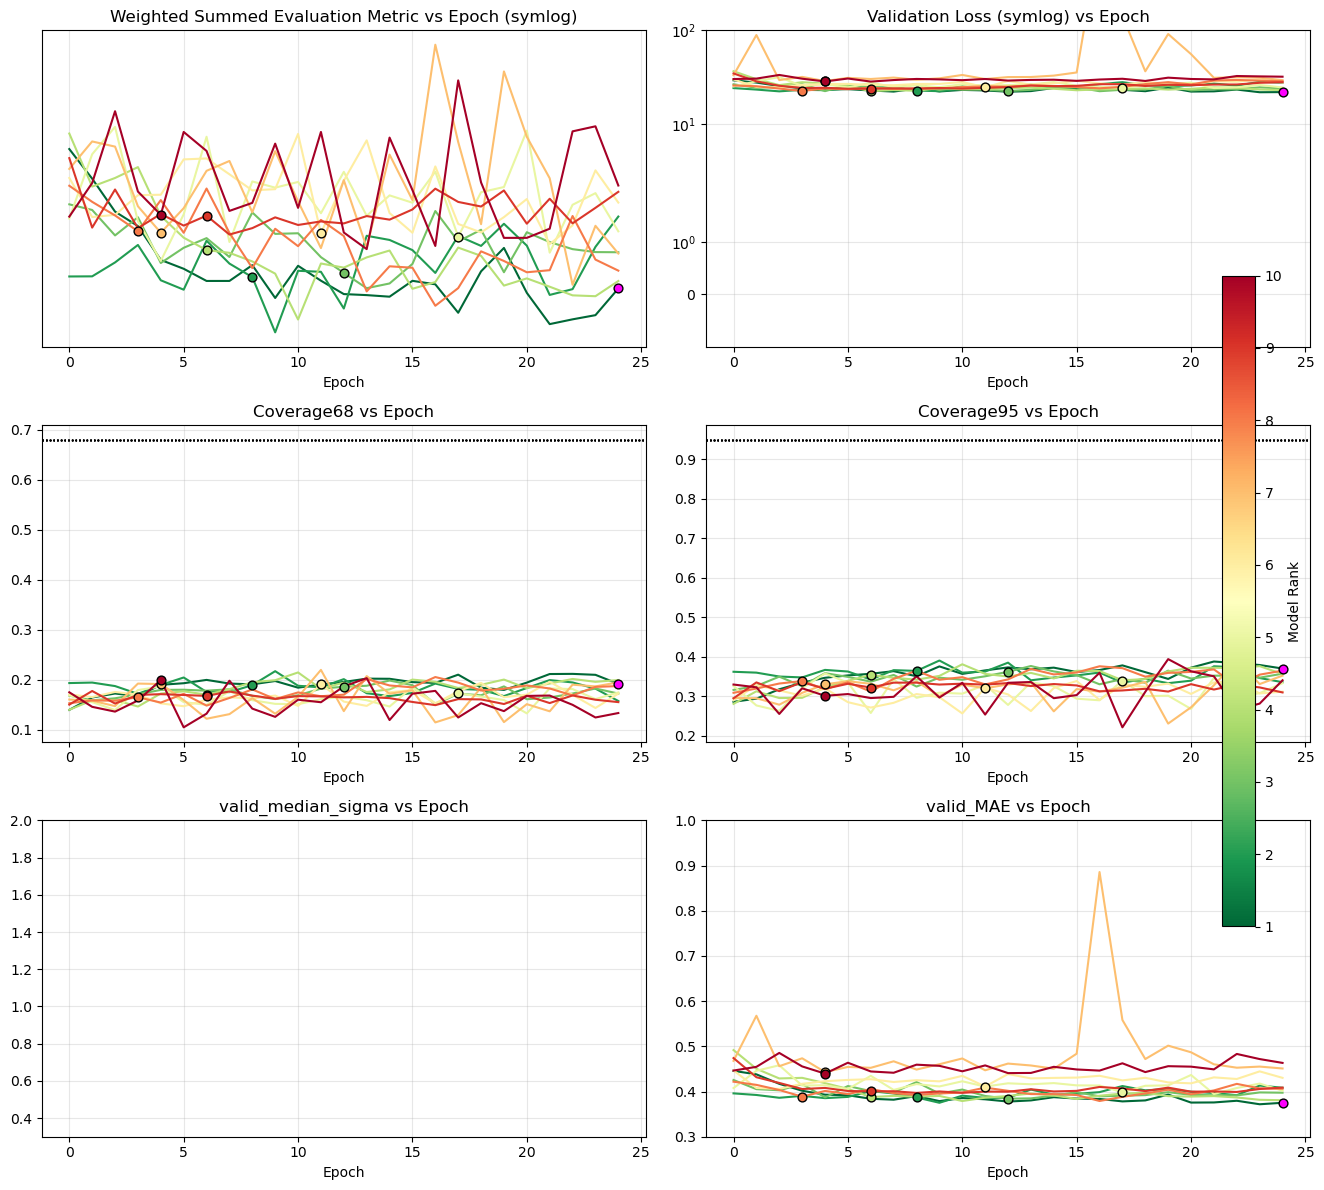

In [133]:


metric_weights = {'loss':0, 'cov68':1, 'cov95':1, 'err1':3e-1, 'err2':3e-1}
err_metric1 = 'valid_median_sigma'
err_metric2 = 'valid_MAE'
smooth_window = 7
df_ranked = rank_models_by_validation(all_runs_log, smooth_window=smooth_window, 
                                      weights=metric_weights,
                                      err_metric1=err_metric1, err_metric2=err_metric2)


kwargs = dict(range_n_models=[0, 10], color_by='rank', 
              err1_lims=[0.3, 2], err2_lims=[0.3, 1], loss_lims=[-1, 100],
             log_colorbar=False,
             )

plot_ranked_model_metrics(all_runs_log, df_ranked, err_metric1, err_metric2,
                              weights=metric_weights, smooth_window=smooth_window, **kwargs)



In [41]:
# ============================================================
# EXPORT BEST MODEL PARAMETERS
# ============================================================

# Extract best model (rank 1 = row 0)
best_model_info = df_ranked.iloc[0]
best_params = best_model_info['params']
best_epoch = best_model_info['best_epoch']

# Display results
print("\n" + "="*70)
print("✅ BEST MODEL IDENTIFIED")
print("="*70)
print(f"Model Name:      {best_model_info['model']}")
print(f"Run ID:          {best_model_info['run_id']}")
print(f"Rank:            {best_model_info['rank']}")
print(f"Composite Score: {best_model_info['score']:.4f}")
print(f"Best Epoch:      {best_epoch}")
print(f"\nValidation Metrics @ Best Epoch:")
print(f"  Loss:          {best_model_info['best_loss']:.4f}")
print(f"  Coverage@68%:  {best_model_info['best_cov68']:.4f} (target: 0.68)")
print(f"  Coverage@95%:  {best_model_info['best_cov95']:.4f} (target: 0.95)")
print(f"  {err_metric1}: {best_model_info['best_err1']:.4f}")
print(f"  {err_metric2}: {best_model_info['best_err2']:.4f}")

print(f"\nHyperparameters:")
for key, value in best_params.items():
    print(f"  {key:30s} = {value}")
print("="*70)

# Export to file
import pickle
import os

# Ensure TempFiles directory exists
os.makedirs(temp_files_path, exist_ok=True)

export_data = {
    'params': best_params,
    'best_epoch': best_epoch,
    'model_name': best_model_info['model'],
    'run_id': best_model_info['run_id'],
    'composite_score': best_model_info['score'],
    'metrics': {
        'loss': best_model_info['best_loss'],
        'cov68': best_model_info['best_cov68'],
        'cov95': best_model_info['best_cov95'],
        'err1': best_model_info['best_err1'],
        'err2': best_model_info['best_err2'],
        'err_metric1_name': err_metric1,
        'err_metric2_name': err_metric2
    },
    'ranking_info': {
        'metric_weights': metric_weights,
        'smooth_window': smooth_window,
        'total_models_evaluated': len(df_ranked)
    }
}

output_file = temp_files_path + 'best_model_params.pkl'
with open(output_file, 'wb') as f:
    pickle.dump(export_data, f)

print(f"\n✅ Best model parameters saved to: {output_file}")
print(f"   Ready for use in 2_TrainBestModel.ipynb")
print("="*70 + "\n")


✅ BEST MODEL IDENTIFIED
Model Name:      Test_Model
Run ID:          5
Rank:            1
Composite Score: 0.2715
Best Epoch:      7

Validation Metrics @ Best Epoch:
  Loss:          -0.3470
  Coverage@68%:  0.6738 (target: 0.68)
  Coverage@95%:  0.9262 (target: 0.95)
  valid_median_sigma: 0.4165
  valid_MAE: 0.3883

Hyperparameters:
  Layer1_Size                    = 16
  Layer2_Size                    = 8
  artificial_loss_weight_factor  = 1
  batch_size                     = 4
  decoupled                      = False
  dropout_prob                   = 0.2
  learn_sigma                    = True
  lr                             = 0.003
  n_epochs                       = 30
  n_layers                       = 2
  num_kfolds                     = 5
  use_cnn                        = False
  use_periodogram                = True
  weight_decay                   = 1e-06

✅ Best model parameters saved to: /astro/users/cgwill/TESS_Cluster_Age_ML/GaussianNN_CGW/Model_Pipeline/TempFiles/bes

# MCMC Dropout Figs




## MCMC Dropout


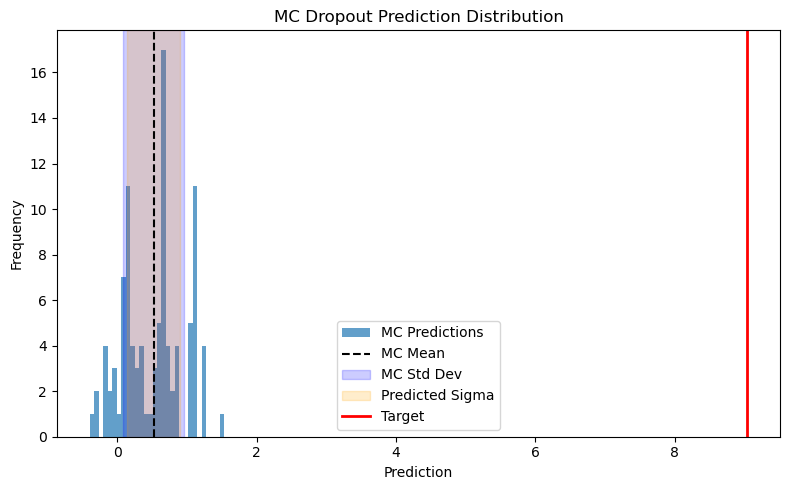

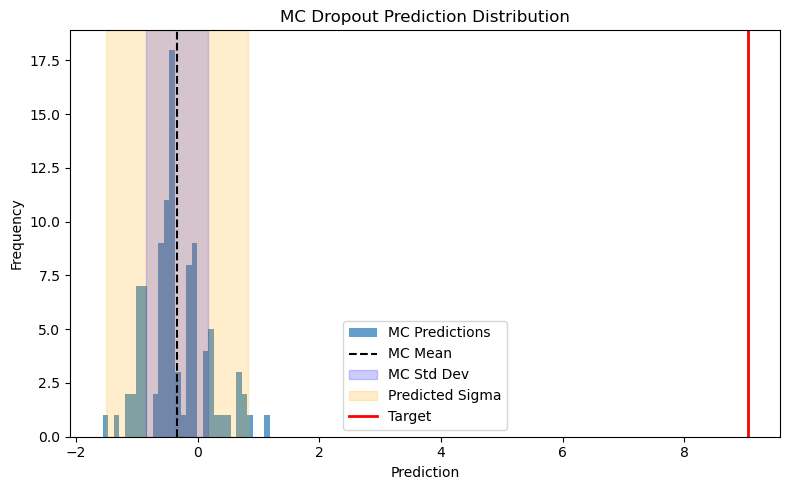

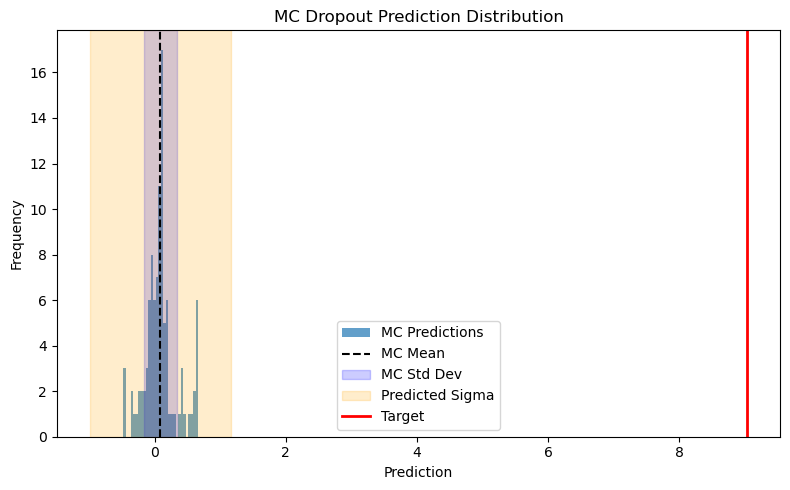

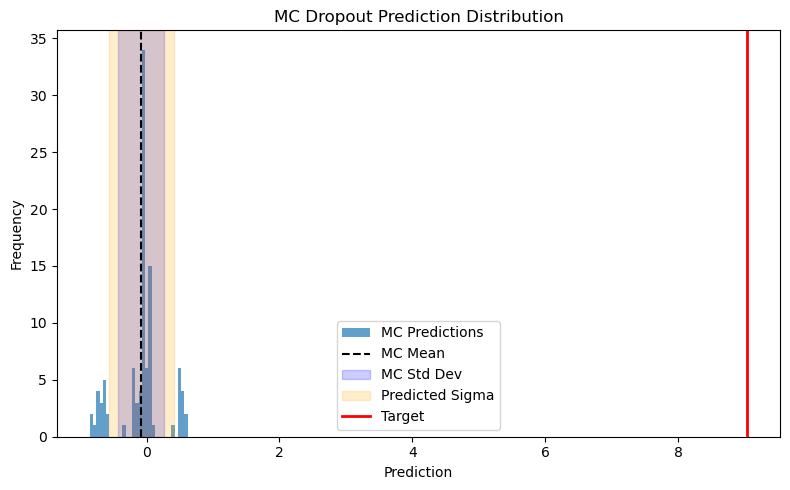

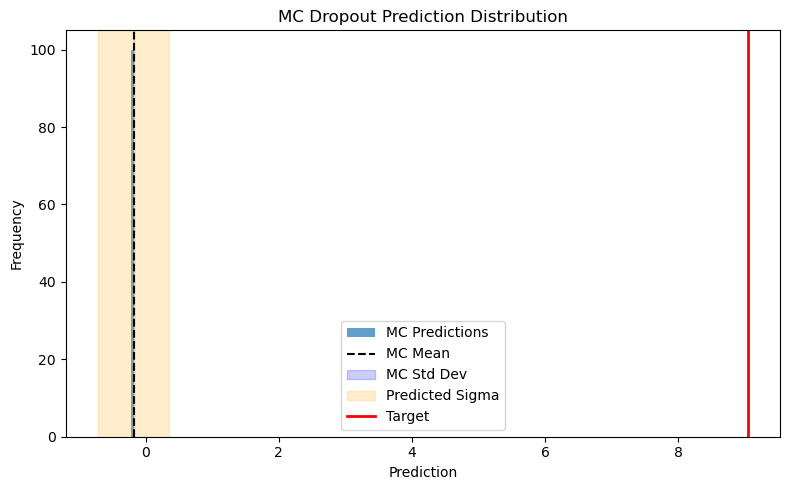

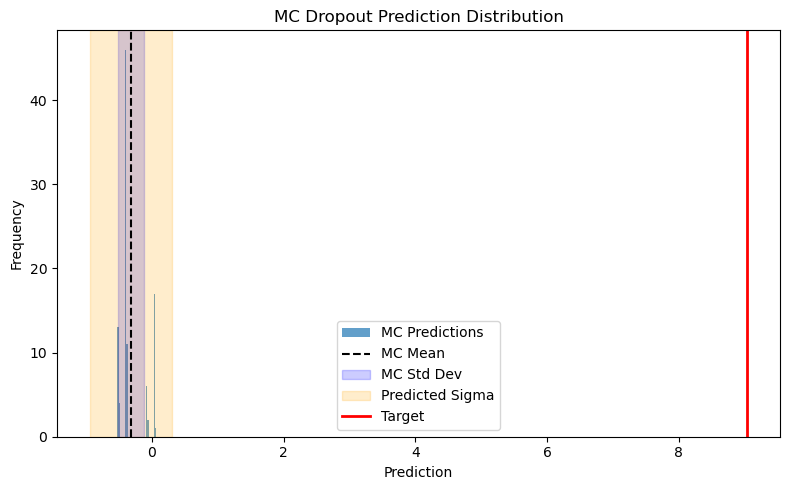

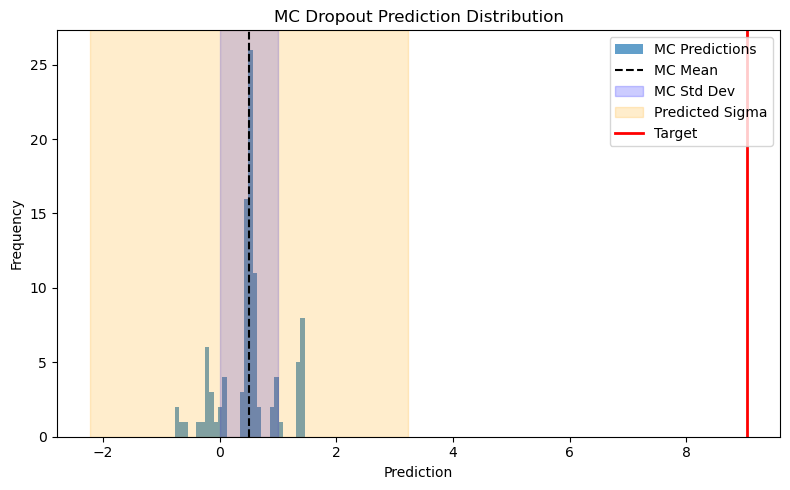

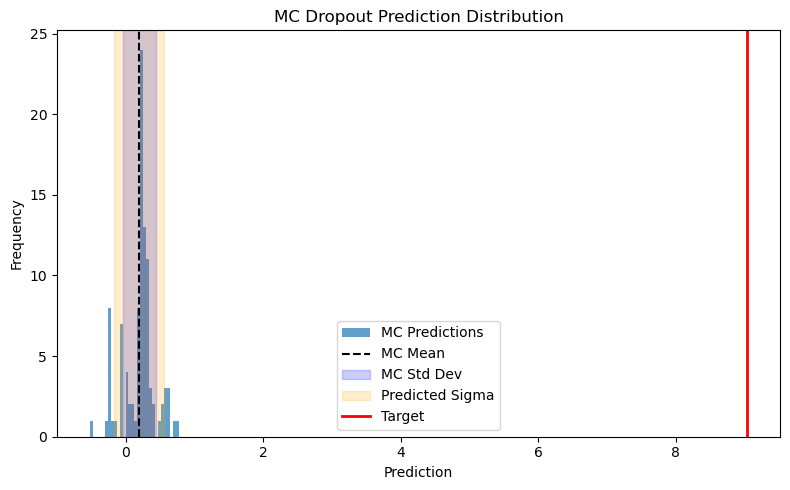

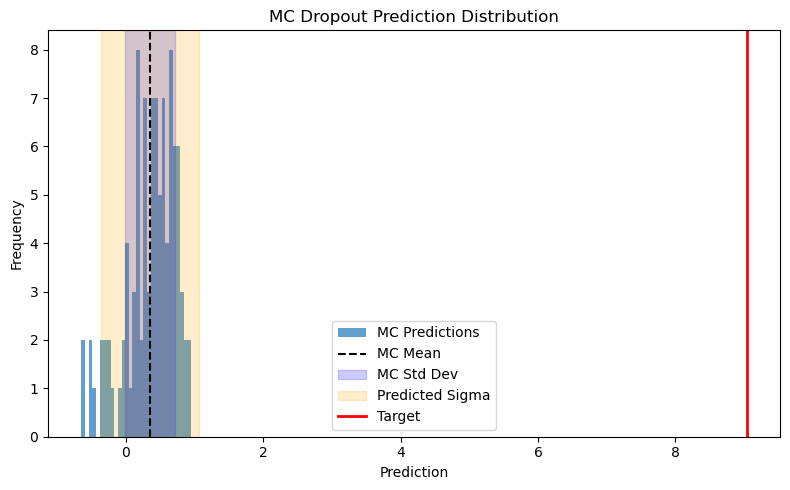

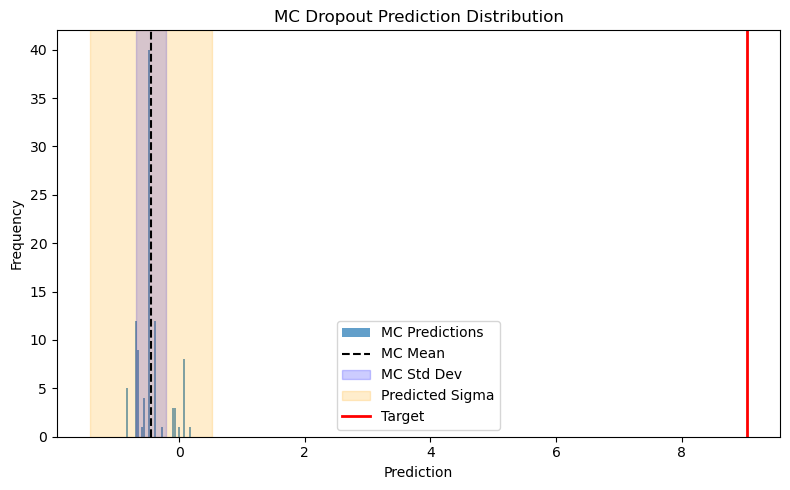

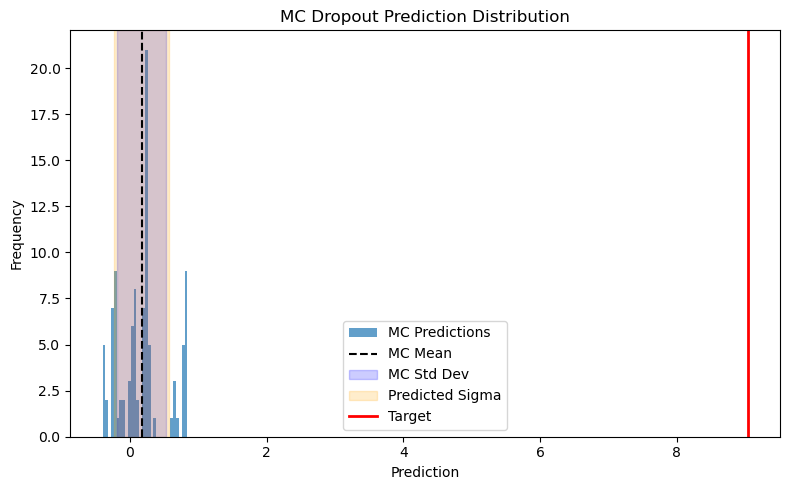

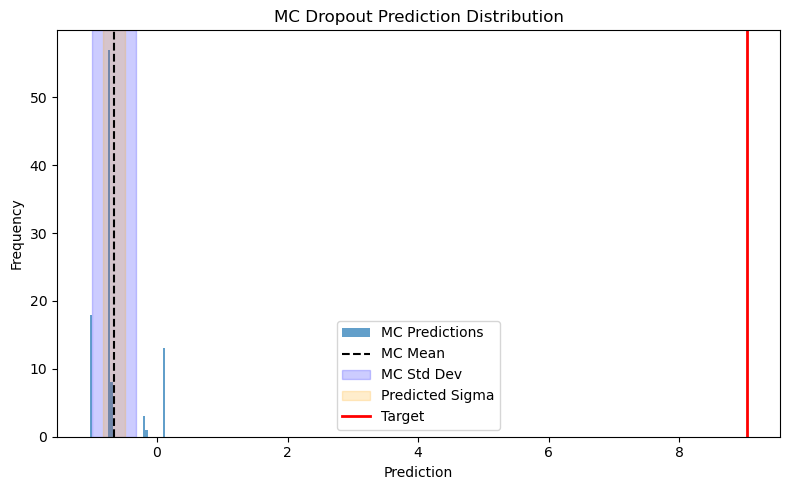

In [23]:
# TRY MCMC DROPOUT
import torch
import matplotlib.pyplot as plt

def enable_dropout(model):
    for m in model.modules():
        if isinstance(m, torch.nn.Dropout):
            m.train()

def disable_dropout(model):
    for m in model.modules():
        if isinstance(m, torch.nn.Dropout):
            m.eval()

def visualize_mc_dropout(model, X, X_period, num_samples=100, target=None):
    """
    Runs MC dropout and visualizes prediction distribution and uncertainties.
    
    Assumes the model returns two tensors per input:
    - mean prediction: shape (batch_size, ...)
    - predicted std/uncertainty: shape (batch_size, ...)
    
    Arguments:
    - model: a PyTorch model
    - input_tensor: shape (batch_size, input_dim)
    - num_samples: number of MC dropout samples
    - target: optional ground-truth tensor for comparison
    """
    model.eval()
    enable_dropout(model)
    
    pred_list = []
    sigma_list = []

    with torch.no_grad():
        for _ in range(num_samples):
            pred, sigma = model( X, X_period)
            pred_list.append(pred.unsqueeze(0))    # [1, batch_size, ...]
            sigma_list.append(sigma.unsqueeze(0))  # [1, batch_size, ...]

    preds = torch.cat(pred_list, dim=0)   # [num_samples, batch_size, ...]
    sigmas = torch.cat(sigma_list, dim=0) # [num_samples, batch_size, ...]

    mean_pred = preds.mean(dim=0)
    std_pred = preds.std(dim=0)
    mean_sigma = sigmas.mean(dim=0)

    # Plot for batch_size = 1 (or pick one example if batched)
    idx = 100
    fig, ax = plt.subplots(figsize=(8, 5))
    
    ax.hist(preds[:, idx].cpu().numpy(), bins=30, alpha=0.7, label="MC Predictions")
    ax.axvline(mean_pred[idx].item(), color='k', linestyle='--', label='MC Mean')
    ax.axvspan(mean_pred[idx].item() - std_pred[idx].item(),
               mean_pred[idx].item() + std_pred[idx].item(),
               color='blue', alpha=0.2, label='MC Std Dev')
    
    ax.axvspan(mean_pred[idx].item() - mean_sigma[idx].item(),
               mean_pred[idx].item() + mean_sigma[idx].item(),
               color='orange', alpha=0.2, label='Predicted Sigma')

    if target is not None:
        ax.axvline(target[idx].item(), color='red', label='Target', linewidth=2)

    ax.set_title("MC Dropout Prediction Distribution")
    ax.set_xlabel("Prediction")
    ax.set_ylabel("Frequency")
    ax.legend()
    plt.tight_layout()
    plt.show()


    # Disable dropouts:
    model.eval()
    return



print('\n\n\n## MCMC Dropout')
SumStats_list = []    
flattened_name_list = []
for i, model_name in enumerate(model_names):
    ##, X_period, Y = model_train_data_statistics[i], model_train_data_periodogram[i], model_train_data_Y[i] 
    X, X_period, Y = model_test_data_statistics[i], model_test_data_periodogram[i], model_test_data_Y[i] 
    #X, X_period, Y = model_valid_data_statistics[i], model_valid_data_periodogram[i], model_valid_data_Y[i] 
    
    for run_id in all_runs_log[model_name].keys():
        #if (config_dict['batch_size']==1000) and (config_dict['lr']<1e-3):
        model = all_runs_log[model_name][run_id][4]['model']
        #flattened_name_list.append(str(config_dict))
        #SumStats_list.append(SummaryStats(model,  X_test, y_test))
        visualize_mc_dropout(model, X, X_period, num_samples=100, target=Y)



In [24]:
model_test_data_Y

[tensor([[ 8.3000],
         [ 8.3000],
         [ 8.3000],
         [ 8.3000],
         [ 8.3000],
         [ 8.3000],
         [ 8.3000],
         [ 8.3000],
         [ 8.3000],
         [ 8.3000],
         [ 8.3000],
         [ 8.3000],
         [ 8.3000],
         [ 8.3000],
         [ 8.3000],
         [ 8.3000],
         [ 8.3000],
         [ 8.3000],
         [ 8.3000],
         [ 8.3000],
         [ 8.3000],
         [ 8.3000],
         [ 8.3000],
         [ 8.3000],
         [ 8.3000],
         [ 8.3000],
         [ 8.3000],
         [ 8.3000],
         [ 8.3000],
         [ 8.3000],
         [ 8.3000],
         [ 8.3000],
         [ 8.4000],
         [ 8.4000],
         [ 8.4000],
         [ 8.4000],
         [ 8.4000],
         [ 8.4000],
         [ 8.4000],
         [ 8.4000],
         [ 8.4000],
         [ 8.4000],
         [ 8.4000],
         [ 8.4000],
         [ 8.4000],
         [ 8.4000],
         [ 8.4000],
         [ 8.4000],
         [ 8.4000],
         [ 8.4000],


In [ ]:
all_runs_log[model_name][run_id][0].keys()

In [ ]:
import torch
import matplotlib.pyplot as plt

def visualize_mc_dropout_batch(model, X, X_period, num_samples=1000, targets=None, sort_x=False):
    """
    Run MC Dropout on a batch of inputs and visualize prediction mean + uncertainty.
    
    Assumes model returns (prediction, predicted_sigma).
    
    Parameters:
    - model: PyTorch model
    - input_tensor: Tensor of shape [batch_size, input_dim]
    - num_samples: number of stochastic forward passes
    - targets: optional tensor of shape [batch_size]
    - sort_x: if True, will sort x-axis by mean prediction
    """
    model.eval()
    enable_dropout(model)

    pred_list = []
    sigma_list = []

    with torch.no_grad():
        for _ in range(num_samples):
            pred, sigma = model(X, X_period)
            pred_list.append(pred.unsqueeze(0))    # [1, batch_size]
            sigma_list.append(sigma.unsqueeze(0))  # [1, batch_size]

    preds = torch.cat(pred_list, dim=0)   # [num_samples, batch_size]
    sigmas = torch.cat(sigma_list, dim=0) # [num_samples, batch_size]

    mean_pred = preds.mean(dim=0).squeeze(-1).cpu().numpy() # Mean all the predictions (for each point)
    std_pred = preds.std(dim=0).squeeze(-1).cpu().numpy()   # Std of all the predicitons (for each point)
    mean_sigma = sigmas.mean(dim=0).squeeze(-1).cpu().numpy() # Avg model uncertainty from each prediction (for each point)

    x = torch.arange(len(mean_pred))  # default x-axis = index

    if sort_x and (targets is not None):
        print(type(mean_pred), type(std_pred), type(mean_sigma), type(x), type(targets))
        print(np.shape(mean_pred), np.shape(std_pred), np.shape(mean_sigma), np.shape(x), np.shape(targets))

        targets = targets.squeeze(-1).cpu().numpy()
        sort_idx = targets.argsort()
        targets = targets[sort_idx]

        mean_pred = mean_pred[sort_idx]
        std_pred = std_pred[sort_idx]
        mean_sigma = mean_sigma[sort_idx]
        # x = x.squeeze(-1).cpu().numpy()
        # print(x)
        # #x = x[sort_idx]
    
        #if targets is not None:
        print(type(mean_pred), type(std_pred), type(mean_sigma), type(x), type(targets))
        print(np.shape(mean_pred), np.shape(std_pred), np.shape(mean_sigma), np.shape(x), np.shape(targets))

    # Plot
    plt.figure(figsize=(10, 6))
    plt.errorbar(x, mean_pred, yerr=std_pred, fmt='o', label='MC Mean ± Std (Epistemic)', alpha=0.7, ms=0.01)

    # Optional predicted uncertainty
    plt.fill_between(x, mean_pred - mean_sigma, mean_pred + mean_sigma, 
                     color='orange', alpha=0.2, label='Predicted Sigma (Aleatoric)')

    if targets is not None:
        plt.plot(x, targets, 'r--', label='Target')

    plt.xlabel("Data Point Index" + (" (sorted)" if sort_x else ""))
    plt.ylabel("Prediction")
    plt.title("MC Dropout Predictions with Uncertainty")
    plt.legend()
    plt.tight_layout()
    plt.ylim(-2, 2.5)
    plt.show()

    # Disable dropouts:
    model.eval()
    return




print('\n\n\n## MCMC Dropout')
SumStats_list = []    
flattened_name_list = []
for i, model_name in enumerate(model_names):
    #X, X_period, Y = model_train_data_statistics[i], model_train_data_periodogram[i], model_train_data_Y[i] 
    X, X_period, Y = model_test_data_statistics[i], model_test_data_periodogram[i], model_test_data_Y[i] 
    #X, X_period, Y = model_valid_data_statistics[i], model_valid_data_periodogram[i], model_valid_data_Y[i] 
    
    for run_id in all_runs_log[model_name].keys():
        model = all_runs_log[model_name][run_id][0]['model']
        visualize_mc_dropout_batch(model, X, X_period, num_samples=100, targets=Y, sort_x=True)



# Retrain the best model params on full set

In [ ]:
#all_runs_log['Test_Model'][run_id].keys()

In [ ]:

# import time

# #Define which datasets you wish to use. 
# #Here there is just one, but the code could handle more if you specifiy different ones here.

# summary_stat_dims = [X_train.shape[1]]
# periodogram_dims = [period_train.shape[1]]

# model_train_data_statistics  = [X_train]
# model_train_data_periodogram = [period_train]
# model_train_data_Y           = [y_train]

# model_test_data_statistics   = [X_test]
# model_test_data_periodogram  = [period_test]
# model_test_data_Y            = [y_test]

# model_names = ['Test_Model']


# #### Define the model Hyperparameters. A grid of all cominations will be run.
# params = {
# 'use_periodogram': [True], # If True, Runs the model with the periodigram data
# 'use_cnn': [False],        # If True, Runs the periodigram data using 
# 'decoupled': [False],
# 'learn_sigma': [True],
    
# 'n_layers': [2],
# 'Layer1_Size': [32],
# 'Layer2_Size': [16],

# 'dropout_prob': [0.3],
# 'lr':   [1e-3],    # np.logspace(-2, -3, 2), #[1e-2, 1e-3, 1e-4], np.logspace(-2, -4, 5)
# 'batch_size': [2, 16], #np.logspace(3, 4, 2), #

# 'n_epochs': [75],
# 'artificial_loss_weight_factor': [1],
# 'weight_decay': [1e-6],
# 'num_kfolds': [5]
# }

# # self,
# # summary_dim,              # Input size for summary stats
# # periodogram_dim=0,        # Input size for periodogram (only used if enabled)
# # x1=64,                    # Hidden layer size
# # dropout_prob=0.3,
# # use_periodogram=True,
# # periodogram_use_cnn=False):

# empty_train_log = {
#         "epoch" : [], 
#         "mean_batch_loss" : [], 
#         "train_errLoss" : [], 
#         "train_sigmaLoss" : [], 
#         "train_Loss" : [], 
#         "train_MAE"  : [], 
#         "train_RMSE" : [], 
#         "train_median_sigma" : [], 
#         "train_mean_sigma" : [], 
#         "train_Coverage68" : [], 
#         "train_Coverage95" : [], 
#         "train_CRPS" : [], 
#         "valid_errLoss" : [], 
#         "valid_sigmaLoss" : [], 
#         "valid_Loss" : [], 
#         "valid_MAE"  : [], 
#         "valid_RMSE" : [], 
#         "valid_median_sigma" : [], 
#         "valid_mean_sigma" : [], 
#         "valid_Coverage68" : [], 
#         "valid_Coverage95" : [], 
#         "valid_CRPS" : [], 
# }               

# all_runs_log = {
#     model_name: {
#         run_id: {
#             **{
#                 "params": config_dict,
#             },
#             **{
#                 k_id: {
#                     "model": None,
#                     "log": copy.deepcopy(empty_train_log)
#                 } for k_id in range(config_dict['num_kfolds'])
#             }
#         } for run_id, config_dict in enumerate(ParameterGrid(params))
#         # SHOULD ADD THE MODEL DATA HERE, wont be memory efficient but much cleaner code for plotting and our data is small.
#     } for model_name in model_names
    
# }



# for i, model_name in enumerate(model_names):    
#     stats_dim = summary_stat_dims[i] # X_train.shape[1]
#     period_dim = periodogram_dims[i] # period_train.shape[1]
    
#     X_stats  = model_train_data_statistics[i]
#     X_period = model_train_data_periodogram[i]
#     Y        = model_train_data_Y[i]

#     test_X_stats  = model_test_data_statistics[i]
#     test_X_period = model_test_data_periodogram[i]
#     test_Y        = model_test_data_Y[i]


#     if torch.isnan(X_stats).any():
#         print("Warning: NaNs detected in X_train")
    
#     if torch.isnan(X_test).any():
#         print("Warning: NaNs detected in X_test")
    
#     run_id = 0
#     for Params in ParameterGrid(params): 
#         fold_id = 0
#         print('  Run #', run_id, ', Params:', Params)
#         model_class = DualInputNN

#          # Subset the data
#         training_data   = (X_stats, X_period, Y)
#         validation_data = (X_stats, X_period, Y)
        
#         # Initialize a new model for this fold
#         model_inputs = (stats_dim, period_dim, Params['Layer1_Size'], Params['dropout_prob'], 
#                         Params['use_periodogram'], Params['use_cnn'], Params['learn_sigma'])
#         model = model_class(*model_inputs)
        
#         # TRAIN THE MODEL
#         training_log = all_runs_log[model_name][run_id][fold_id]['log'] # Points directly to the log location
#         model, all_runs_log[model_name][run_id][fold_id]['log'], _ = Train_Model(model, training_data, validation_data, Params, training_log)
#         all_runs_log[model_name][run_id][fold_id]['model'] = model
        
#         ## Probably should add a plotting function call here to show how the different folds compare against eachother. ##
#         plot_run_log(all_runs_log[model_name][run_id])
        
#         run_id += 1
    
#     # results_array[i, :] = test_model(model, 
#     #                              X_test_tensor, y_test_tensor, 
#     #                              X_test_BDATA_tensor, y_test_BDATA_tensor)

    
